Multiplexing notebook

In [1]:
#@title Imports
%%capture

!pip install imread
!pip install tifffile


import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from IPython.display import HTML

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import pandas   
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import os
import tqdm.notebook as tq
import PIL
import ipywidgets as widgets
from ipywidgets import interact
import imread
import cv2
import skimage.io as io
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

import argparse
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

#if tf.test.gpu_device_name():
#    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
#else:
#    print("no connection to gpu")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, AveragePooling1D, Conv1D, LeakyReLU, Lambda
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn import mixture

from keras.models import load_model

import matplotlib.animation as animation
from tqdm.notebook import tqdm as tqdm_notebook



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#@title plotting options
from cycler import cycler
########################################
dark = False
if not dark:
    colors = ['#ef476f', '#073b4c','#06d6a0','#7400b8','#073b4c', '#118ab2',]
else:
    plt.style.use('dark_background')
    plt.rcParams.update({'axes.facecolor'      : '#131313'  , 
'figure.facecolor' : '#131313' ,
'figure.edgecolor' : '#131313' , 
'savefig.facecolor' : '#131313'  , 
'savefig.edgecolor' :'#131313'})


    colors = ['#118ab2','#57ffcd', '#ff479d', '#ffe869','#ff8c00','#04756f']

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

save = False

plt.rcParams.update({'font.size': 12, 'font.weight':'bold','font.family':'normal'  }   )
plt.rcParams.update({'axes.prop_cycle':cycler(color=colors)})

plt.rcParams.update({'axes.prop_cycle':cycler(color=colors)})
plt.rcParams.update({'axes.prop_cycle':cycler(color=colors)})


plt.rcParams.update({'xtick.major.width'   : 2.8 })
plt.rcParams.update({'xtick.labelsize'   : 12 })



plt.rcParams.update({'ytick.major.width'   : 2.8 })
plt.rcParams.update({'ytick.labelsize'   : 12})

plt.rcParams.update({'axes.titleweight'   : 'bold'})
plt.rcParams.update({'axes.titlesize'   : 10})
plt.rcParams.update({'axes.labelweight'   : 'bold'})
plt.rcParams.update({'axes.labelsize'   : 12})

plt.rcParams.update({'axes.linewidth':2.8})
plt.rcParams.update({'axes.labelpad':8})
plt.rcParams.update({'axes.titlepad':10})
plt.rcParams.update({'figure.dpi':300})

In [3]:
#@title mc_core

# -*- coding: utf-8 -*-
"""
Created on Fri Mar 25 13:51:22 2022

@author: wsraymon
"""

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample

class multiplexing_core:
    '''
    over head class containing some consistent functions to make the multiplexing easier / more
    cogiant. 
    '''
    def __init__(self):
        pass
    
    
    def get_acc2(self, data, trunc=False):
        '''
        return autocorrelation from a data vector via Fourier transform
    
        Parameters
        ----------
        data : ndarray
            numpy array of data to get the correlation from.
        trunc : bool, optional
            Remove non zero entries and only return decreasing entries.
            The default is False.
    
        Returns
        -------
        autocorrelation : ndarray
            autocorrelation function.
    
        '''
    
        N = len(data)
        fvi = np.fft.fft(data, n=2*N)
        acf = fvi*np.conjugate(fvi)
        acf = np.fft.ifft(acf)
        acf = np.real(acf[:N])/float(N)
        if trunc:
            acf[acf < 0] = 0
            for i in range(1, len(acf)):
                if acf[i] > acf[i-1]:
                    acf[i] = acf[i-1]
        return acf
    
    
    def get_autocov(self,intensity_vec, norm='global'):
        '''
        Return the autocovariance of an intensity vector as defined by:
        
        .. math:: 
            
            ACOV(t, \tau) = cov(X_{t}, X_{\tau}) = E{X_{t}, X_{\tau}} 
        
        There are also several normalization options:
            
        Raw - perform no normalization to each intensity trajectory
        
        Global - subtract the global intensity mean and divide by global
        variance
        
        .. math:: 
            
            \mu_I = E(Intensity) \\
            \sigma_I^2 = V(Intensity) \\
            X_{normalized} = (X(t) - \mu_I) / \sigma_I^2            
    
        Individual - subtact each trajectory by its mean and divide by
        its variance
    
        .. math:: 
            
            X_{normalized} = (X_{i}(t) - E(X_{i}(t))) / V(X_{i}(t))   
    
        Parameters
        ----------
        intensity_vec : ndarray
            intensity tensor of shape (ncolor, ntimes, ntraj).
        norm : str, optional
            normalization to use, 'raw' for no normalization, 'global' to 
            normalize by the gobal intensity moments, 
            'individual' to normalize each trajectory by
            its individual moments. The default is 'global'.
    
        Returns
        -------
        autocorr_vec : ndarray
            returns autorcovariance array of size (ncolor, ntime-1, ntraj).
        autocorr_err : ndarray
            returns autorcovariance SEM array of size (ncolor, ntime-1, ntraj).
    
        '''
        autocorr_vec = np.zeros((intensity_vec.shape))
        autocorr_err = np.zeros((intensity_vec.shape))
        colors = intensity_vec.shape[0]
        n_traj = intensity_vec.shape[2]
    
        for n in range(colors):
            if norm in ['Individual', 'I', 'individual', 'ind','i']:
                for i in range(intensity_vec.shape[2]):
                    ivec = intensity_vec[n, :, i]
                    autocorr_vec[n, :, i] = self.get_acc2(
                        (ivec - np.mean(ivec))/np.var(ivec))
    
            elif norm in ['global', 'Global', 'g', 'G']:
                global_mean = np.mean(intensity_vec[n])
                global_var = np.var(intensity_vec[n])
                for i in range(intensity_vec.shape[2]):
                    autocorr_vec[n, :, i] = self.get_acc2(
                        (intensity_vec[n, :, i]-global_mean)/global_var )
            elif norm in ['raw', 'Raw']:
                for i in range(intensity_vec.shape[2]):
                    autocorr_vec[n, :, i] = self.get_acc2(
                        intensity_vec[n, :, i])
            else:
                print('unrecognized normalization,'/
                      ' please use individual, global, or none')
                return
    
        autocorr_err = 1.0/np.sqrt(n_traj)*np.std(
            autocorr_vec, ddof=1, axis=2)
    
        return autocorr_vec, autocorr_err
    
    def get_g0(self,covariance, mode='interp'):
        '''
        return the normalization point for autocorrelations, g0 delay
    
        Parameters
        ----------
        correlation : ndarray
            numpy array of a cross or autocovariance.
        mode : string, optional
            the type of G0 shot noise to return,
    
            * 'Interp' - will interpolate the g0 position from the G1, G2, and G3 points.
            
            * 'g1' - (second point) g1 will be returned
            
            * 'g0' - g0 will be returned (first point)
            
            * 'max' -maximum of the correlation will be returned
            
            The default is 'interp'.
    
        Returns
        -------
        G0 : float
            point to normalize correlation over.
    
        '''
        if mode.lower() in ['interp', 'inter', 'extrapolate', 'interpolate']:
            X = [1, 2, 3, 4]
            V = covariance[:, X, :]
            G0 = np.interp(0, X, V)
    
        if mode.lower() in ['g1', '1']:
            G0 = covariance[:, 1, :]
    
        if mode.lower() in ['g0', '0']:
            G0 = covariance[:, 0, :]
    
        if mode.lower() in ['max', 'maximum']:
            G0 = np.max(covariance, axis=1)
        return G0
    
    def get_autocorr(self,autocov, norm_type='interp', norm = 'individual'):
        '''
        Given an autocovariance tensor, normalize to the autocorrelation
        
        .. math:: 
            
            ACORR(X(t)) = ACOV(X(t)) / Normalization Constant
            
        where Normalization constant is defined as the delay to divide all 
        autocrrelations by:
            
            * G0 - the first delay without shot noise correction
            
            * G1 - the second delay of the autocorrelation
            
            * interp - interpolated G0, take G1-4 and calculate the G0 without shot noise
            
            
        norm = global will normalize the autocovariance by the global average normalization_constant
        norm = individual will normalize each trajectory by its own normalization_constant
            
        Parameters
        ----------
        autocov : ndarray
            autocovariance tensor of shape (Ncolor, Ntimes, Ntrajectories).
        norm_type : str, optional
            Delay to normalize by, G0, G1 or interp for interpolated G0. The default is 'interp'.
        norm : str, optional
            globally normalize autocovariance or individually normalize.
            Normalize each trajectory by its own g0 or by the global g0. 
            The default is 'individual'
    
        Returns
        -------
        autocorr : ndarray
            autocorrelation tensor of shape (Ncolor, Ntimes, Ntrajectories).
        err_autocorr : ndarray
            SEM autocorrelation tensor of shape (Ncolor, Ntimes, Ntrajectories).
    
        '''
        autocorr = np.copy(autocov)
        n_traj = autocorr.shape[-1]
    
        if norm_type.lower() in ['individual','indiv','i']:
            g0 = self.get_g0(autocov, norm)
            for n in range(autocov.shape[0]):
                autocorr[n] = autocorr[n]/g0[n]
        elif norm_type.lower() in ['global','g']:
            g0 = self.get_g0(autocov, norm)
            g0_mean = np.mean(g0)
            for n in range(autocov.shape[0]):
                autocorr[n] = autocorr[n]/g0_mean     
                
        else: 
        
            msg = 'unrecognized normalization, please use '\
                  'individual, or global for norm arguement'
            print(msg)
            return                 
        err_autocorr =  1.0/np.sqrt(n_traj)*np.std(autocorr, ddof=1, axis=2)
        return autocorr, err_autocorr
    
    def slice_arr(self,array, FR, Nframes,axis=1):
        total_time = FR*Nframes
        if total_time > array.shape[1]:
            print('WARNING: desired slicing regime is not possible, making as many frames as possible')
            return array[:,::FR][:,:Nframes]
        return array[:,::FR][:,:Nframes]
        
    
    def convert_labels_to_onehot(self,labels):
        '''
        converts labels in the format 1xN, [0,0,1,2,3,...] to onehot encoding,
        ie: N_classes x N,  [[1,0,0,0],[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]     
        '''
        onehotlabels = np.zeros((labels.shape[0],len(np.unique(labels))))
        for i in range(len(onehotlabels)):
            onehotlabels[i,labels[i]] = 1
        return onehotlabels
    

    def process_data_n(self, data, labels, use_norm=True, norm='train_and_test', seed=42, witheld = 1000, test_size = .2, include_acc = False):
        '''
        

        Parameters
        ----------
        data : ndarray
            ntraj x ntimes intensity data array.
        labels : ndarray
            label array.
        norm : str, optional
            which normalization to use, "train_and_test" will not consider the witheld data
            when performing all data normalization, "train" uses just the training set to normalize all data,
            "all" will use all data to calculate normalization. The default is 'train_and_test'.
        seed : int, optional
            Seed for all randomness. The default is 42.
        witheld : int, optional
            how many trajectories to withold. The default is 1000.
        test_size : float, optional
            percentage to consider the test set. The default is .2.

        Returns
        -------
        X_train : ndarray
            training data.
        X_test : ndarray
            training labels.
        y_train : ndarray
            test data.
        y_test : ndarray
            test labels.
        X_witheld : ndarray
            witheld data.
        y_witheld : ndarray
            witheld labels.

        '''
        unique_labels = np.sort(np.unique(labels).astype(int))
        n_labels = len(unique_labels)
        print(unique_labels)        
        s = []
        for i in range(len(unique_labels)):
            s.append(len(labels == i))
        
        # Shuffle the data so its not from the same cells when we index by labels
        data, labels = self.even_shuffle_sample_n(data, labels, samples=s, seed=seed) 
        
        
        if witheld > 0:
            # Witheld data ###################################
            np.random.seed(seed)
            
            int_witheld = []
            labels_witheld = []
            for i in range(len(unique_labels)):
                int_1 = data[labels==i][:int(witheld/n_labels), :] #get n witheld samples
                labels_1 = labels[labels==i][:int(witheld/n_labels)]
                int_witheld.append(int_1)
                labels_witheld.append(labels_1)
                
                
            X_witheld = np.vstack(int_witheld)  #combine and then shuffle in place
            y_witheld = np.hstack(labels_witheld)
    
            int_1_inds = np.random.permutation(len(X_witheld))
            X_witheld = X_witheld[int_1_inds]
            y_witheld = y_witheld[int_1_inds]        
            
            

        # Training data ###################################
            int_training= []
            labels_training = []
            for i in range(len(unique_labels)):     
                int_1 = data[labels==i][int(witheld/n_labels):, :] #get n usable samples                
                labels_1 = labels[labels==i][int(witheld/n_labels):]
                int_training.append(int_1)
                labels_training.append(labels_1)
        
            data = np.vstack(int_training)
            labels = np.hstack(labels_training)
            
            int_1_inds = np.random.permutation(len(data))
 
            data = data[int_1_inds]
            labels = labels[int_1_inds]              
 
        else:
            X_witheld = None
            y_witheld = None
            

        if test_size == 0:
            X_train = data
            y_train = labels
            X_test = None
            y_test = None
        else:
            X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state= seed, stratify=labels)
        
        if use_norm:
            if norm=='train':
                scaler = MinMaxScaler()
                scaler.fit(X_train)
            if norm=='all':
                scaler = MinMaxScaler()
                scaler.fit(np.vstack([X_train, X_test, X_witheld] ))
            if norm=='train_and_test':
                scaler = MinMaxScaler()
                scaler.fit(np.vstack([X_train, X_test] ))         
        
        
            X_train = scaler.transform(X_train)
            if witheld > 0:
                X_witheld = scaler.transform(X_witheld)
            if test_size > 0:
                X_test = scaler.transform(X_test)
        
        
        ### reshape data to correct shape
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        if test_size > 0:
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        if witheld > 0:
            X_witheld = X_witheld.reshape(X_witheld.shape[0], X_witheld.shape[1], 1)
        
        y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
        if test_size > 0:
            y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
        if witheld > 0:
            y_witheld = np.asarray(y_witheld).astype('float32').reshape((-1,1))
        
        if include_acc:
            
            def get_acc(int_g):
                acc, acc_error = self.get_autocov(np.expand_dims(int_g.T,axis=0), norm='ind')
                acc, acc_error1 = self.get_autocorr(acc, norm_type='individual', norm='g0' )
                acc = acc[0].T
                acc = acc.reshape(acc.shape[0], acc.shape[1], 1)
                return acc
            
            Acc_train = get_acc(X_train[:,:,0])
            if test_size > 0:
                Acc_test = get_acc(X_test[:,:,0])
            else:
                Acc_test = None
            if witheld > 0:
                Acc_witheld = get_acc(X_witheld[:,:,0])
            else:
                Acc_witheld = None
            
            return X_train, X_test, y_train, y_test, X_witheld, y_witheld, Acc_train, Acc_test, Acc_witheld
        else:
            
            return X_train, X_test, y_train, y_test, X_witheld, y_witheld
            

    def bootstrap_data(self, X_train, y_train, n_sample, seed):
        return resample(X_train, y_train, n_samples=n_sample, random_state=seed, replace=False)
        


    def process_data(self, data, labels, use_norm=True, norm='train_and_test', seed=42, witheld = 1000, test_size = .2, include_acc = False):
        '''
        

        Parameters
        ----------
        data : ndarray
            ntraj x ntimes intensity data array.
        labels : ndarray
            label array.
        norm : str, optional
            which normalization to use, "train_and_test" will not consider the witheld data
            when performing all data normalization, "train" uses just the training set to normalize all data,
            "all" will use all data to calculate normalization. The default is 'train_and_test'.
        seed : int, optional
            Seed for all randomness. The default is 42.
        witheld : int, optional
            how many trajectories to withold. The default is 1000.
        test_size : float, optional
            percentage to consider the test set. The default is .2.

        Returns
        -------
        X_train : ndarray
            training data.
        X_test : ndarray
            training labels.
        y_train : ndarray
            test data.
        y_test : ndarray
            test labels.
        X_witheld : ndarray
            witheld data.
        y_witheld : ndarray
            witheld labels.

        '''
        
        
        s1 = len(labels == 0)
        s2 = len(labels == 1)
        # Shuffle the data so its not from the same cells when we index by labels
        data, labels = self.even_shuffle_sample(data, labels, samples=[s1,s2], seed=seed) 
        
        if witheld > 0:
            # Witheld data ###################################
            np.random.seed(seed)
    
            int_1 = data[labels==0][:int(witheld/2), :] #get n witheld samples
            int_2 = data[labels==1][:int(witheld/2), :] #get n witheld samples
            
            labels_1 = labels[labels==0][:int(witheld/2)]
            labels_2 = labels[labels==1][:int(witheld/2)]
            
            X_witheld = np.vstack([int_1,int_2])  #combine and then shuffle in place
            y_witheld = np.hstack([labels_1,labels_2])
    
            int_1_inds = np.random.permutation(len(X_witheld))
            X_witheld = X_witheld[int_1_inds]
            y_witheld = y_witheld[int_1_inds]        
            
            

        # Training data ###################################
     
            int_1 = data[labels==0][int(witheld/2):, :] #get n usable samples
            int_2 = data[labels==1][int(witheld/2):, :]
            
            labels_1 = labels[labels==0][int(witheld/2):]
            labels_2 = labels[labels==1][int(witheld/2):]
    
            data = np.vstack([int_1,int_2])
            labels = np.hstack([labels_1,labels_2])
            
            int_1_inds = np.random.permutation(len(data))
 
            data = data[int_1_inds]
            labels = labels[int_1_inds]              
 
        else:
            X_witheld = None
            y_witheld = None

        if test_size == 0:
            X_train = data
            y_train = labels
            X_test = None
            y_test = None
        else:
            X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state= seed, stratify=labels)
        
        if use_norm:
            if norm=='train':
                scaler = MinMaxScaler()
                scaler.fit(X_train)
            if norm=='all':
                scaler = MinMaxScaler()
                scaler.fit(np.vstack([X_train, X_test, X_witheld] ))
            if norm=='train_and_test':
                scaler = MinMaxScaler()
                scaler.fit(np.vstack([X_train, X_test] ))         
        
        
            X_train = scaler.transform(X_train)
            if witheld > 0:
                X_witheld = scaler.transform(X_witheld)
            if test_size > 0:
                X_test = scaler.transform(X_test)
        
        
        ### reshape data to correct shape
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        if test_size > 0:
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        if witheld > 0:
            X_witheld = X_witheld.reshape(X_witheld.shape[0], X_witheld.shape[1], 1)
        
        y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
        if test_size > 0:
            y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
        if witheld > 0:
            y_witheld = np.asarray(y_witheld).astype('float32').reshape((-1,1))
        
        if include_acc:
            
            def get_acc(int_g):
                acc, acc_error = self.get_autocov(np.expand_dims(int_g.T,axis=0), norm='ind')
                acc, acc_error1 = self.get_autocorr(acc, norm_type='individual', norm='g0' )
                acc = acc[0].T
                acc = acc.reshape(acc.shape[0], acc.shape[1], 1)
                return acc
            
            Acc_train = get_acc(X_train[:,:,0])
            if test_size > 0:
                Acc_test = get_acc(X_test[:,:,0])
            else:
                Acc_test = None
            if witheld > 0:
                Acc_witheld = get_acc(X_witheld[:,:,0])
            else:
                Acc_witheld = None
            
            return X_train, X_test, y_train, y_test, X_witheld, y_witheld, Acc_train, Acc_test, Acc_witheld
        else:
            
            return X_train, X_test, y_train, y_test, X_witheld, y_witheld
        
    
    
    
    def df_to_arrays(self,dataframe_simulated_cell):
        '''
        convert an rSNAPed data frame into a numpy intensity array
        '''
        total_particles = 0
        for cell in set(dataframe_simulated_cell['cell_number']):
            total_particles += len(set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ))

      #preallocate numpy array sof n_particles by nframes
        I_g = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] )  #intensity green
        I_g_std = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #intensity green std
        x_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #x loc
        y_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #y_loc
        I_r_std   = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1)] ) #intensity red
        I_r = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1) ] ) #intensity red std
        labels = np.zeros([total_particles])
        label_list = list(set(np.unique(dataframe_simulated_cell['Classification'])))
        k = 0
        for cell in set(dataframe_simulated_cell['cell_number']):  #for every cell 
            for particle in set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ): #for every particle
                tmpdf = dataframe_simulated_cell[(dataframe_simulated_cell['cell_number'] == cell) & (dataframe_simulated_cell['particle'] == particle)]  #slice the dataframe
                maxframe = np.max(tmpdf['frame'])
                minframe = np.min(tmpdf['frame'])
                I_g[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_mean']  #fill the arrays to return out
                x_loc[k, 0:(maxframe+1-minframe)] = tmpdf['x']
                y_loc[k, 0:(maxframe+1-minframe)] = tmpdf['y']
                I_g_std[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_std']
                #I_r[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_mean']
                #I_r_std[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_std']
                labels[k] = label_list.index(list(set(np.unique(tmpdf['Classification'])))[0])
                k+=1
                
        return I_g, I_g_std, I_r, I_r_std, labels, x_loc,y_loc
    
    
    def get_intensity_from_df(self,multiplexing_df, n_traj, n_timepoints, channel='green_int_mean'):
        int_g = multiplexing_df['green_int_mean'].values.reshape([n_traj,n_timepoints])    
        labels = multiplexing_df['Classification'].values.reshape([n_traj,n_timepoints])[:,0]
        
        return int_g, labels
    
    
    def even_shuffle_sample(self, intensity_array, labels, samples = [2500,2500], seed = 42):
        '''
        Evenly shuffle each intensity by label and then sample each intensity.
        
        Return the concatenated shuffled arrays back out 
        '''
        int_1 = intensity_array[labels==0]
        int_2 = intensity_array[labels==1]
        
        labels_1 = labels[labels==0]
        labels_2 = labels[labels==1]
        
        np.random.seed(seed)
        int_1_inds = np.random.permutation(len(int_1))
        int_2_inds = np.random.permutation(len(int_2))
        
        int_1= int_1[int_1_inds][:samples[0], :]
        int_2 = int_2[int_2_inds][:samples[0],:]
        
        labels_1 = labels_1[int_1_inds][:samples[1]]
        labels_2 = labels_2[int_2_inds][:samples[1]]
        
        int_out = np.vstack([int_1,int_2])
        labels_out = np.hstack([labels_1,labels_2])
        
        int_1_inds = np.random.permutation(len(int_out))
        int_out = int_out[int_1_inds]
        labels_out = labels_out[int_1_inds]
        
        return int_out, labels_out

    def process_test_data(self, data, use_norm=True, seed=42, include_acc = True ):

        
        scaler = MinMaxScaler()
        scaler.fit(data)     
        data = scaler.transform(data)    


        
        ### reshape data to correct shape
        data = data.reshape(data.shape[0], data.shape[1], 1)


        if include_acc:
            
            def get_acc(int_g):
                acc, acc_error = self.get_autocov(np.expand_dims(int_g.T,axis=0), norm='ind')
                acc, acc_error1 = self.get_autocorr(acc, norm_type='individual', norm='g0' )
                acc = acc[0].T
                acc = acc.reshape(acc.shape[0], acc.shape[1], 1)
                return acc
            
            acc_data = get_acc(data[:,:,0])
        if include_acc:
          return data, acc_data
        else:
          return data        

    def even_shuffle_sample_n(self, intensity_array, labels, samples = [2500,2500], seed = 42):
        '''
        Evenly shuffle each intensity by label and then sample each intensity.
        
        Return the concatenated shuffled arrays back out 
        '''
        
        np.random.seed(seed)
        unique_labels = np.sort(np.unique(labels).astype(int))
        print(unique_labels)
        ints_out = []
        labels_out = []
        for i in range(len(unique_labels)):
            int_1 = intensity_array[labels==unique_labels[i]]
            labels_1 = labels[labels==unique_labels[i]]
            
            int_1_inds = np.random.permutation(len(int_1))
            int_1= int_1[int_1_inds][:samples[i], :] #shuffle these 
            labels_1 = labels_1[int_1_inds][:samples[i]]
            ints_out.append(int_1)
            labels_out.append(labels_1)
        
        int_out = np.vstack(ints_out)
        labels_out = np.hstack(labels_out)
        
        int_1_inds = np.random.permutation(len(int_out))
        int_out = int_out[int_1_inds]
        labels_out = labels_out[int_1_inds]
        
        return int_out, labels_out        
    
    def minmax_quantile_signal(signal, axis=0, norm='global', quantile=.95, max_outlier=1.5):
        '''
        normalize a singal by its min and max from a quantile,
        leaving trajectories from 0 to 1 at that quantile. Set all outliers
        over a maximum to max_outlier.
        This can be applied globally or individually to each trajectory
        with the flag norm ='global' or norm='indiv'
        
        
        .. code-block::
            
            #global normalization
            S_95= np.quantile(0.95)
            S_normalized = (S - np.min(S)) / (np.quantile(0.95) - np.min(S))
            
            #individual normalization
            S_95= np.quantile(0.95)
            S_normalized = (S - np.min(S,axis=axis)) / (np.quantile(0.95) - np.min(S,axis=axis))
        
    
        Parameters
        ----------
        signal : ndarray
            intensity or signal array.
        axis : int, optional
            axis to apply the standardization over. The default is 0.
        norm : str, optional
            apply this using global mean ('global') and var or individual trajectory
            mean and var ('indiv'). The default is 'global'.
        quantile : float (0-1)
            the % quantile to set to the new 1
        max_outlier : float
            the maximum value to use for any outlier after normalization
    
        Raises
        ------
        UnrecognizedNormalizationError
            Throws an error if the norm is not global or individual.
    
        Returns
        -------
        ndarray
            minmaxed per quantile array over axis desired.
    
        '''
        if norm in ['global', 'Global', 'g', 'G']:
            
            max_95 = np.quantile(signal, quantile)
            sig = (signal -  np.min(signal) ) / ( max_95  - np.min(signal) )
            return np.minimum(sig,max_outlier)
        
        if norm in ['Individual', 'I', 'individual', 'ind','indiv','i']:
            
            max_95 = np.quantile(signal, quantile,axis=axis)
            print(max_95.shape)
            sig = (signal -  np.min(signal,axis=axis) ) / ( max_95 - np.min(signal,axis=axis) )
            return np.minimum(sig,max_outlier)
        
        else:
            msg = 'unrecognized normalization, please use '\
                  'individual, global, or none for norm arguement'
            print(msg)
            return 
    
    
    
    def standardize_signal(signal, axis=0, norm='global'):
        '''
        Perform standardization to set signal mean to 0 with unit variance of 
        1. This can be applied globally or individually to each trajectory
        with the flag norm ='global' or norm='indiv'
    
        Parameters
        ----------
        signal : ndarray
            intensity or signal array.
        axis : int, optional
            axis to apply the standardization over. The default is 0.
        norm : str, optional
            apply this using global mean ('global') and var or individual trajectory
            mean and var ('indiv'). The default is 'global'.
    
        Raises
        ------
        UnrecognizedNormalizationError
            Throws an error if the norm is not global or individual.
    
        Returns
        -------
        ndarray
            standardized array over axis desired.
    
        '''
        if norm in ['global', 'Global', 'g', 'G']:
            return (signal - np.mean(signal)) / np.std(signal)
        if norm in ['Individual', 'I', 'individual', 'ind','indiv','i']:
            return (signal - np.mean(signal, axis=axis)) / np.std(signal,axis=axis)
        else:
            msg = 'unrecognized normalization, please use '\
                  'individual, global, or none for norm arguement'
            print(msg)
            return     
        
            
            
            
        
    
    
    

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

#@title train_model / load model
def train_model(files, color, name, model_file=None, retrain=True, include_noise = True):

  mc = multiplexing_core()
  verbose = 1
  ntraj = 2500
  ntimes = 3000
  Nsamples = 5000
  Fr = 5
  Nframes = 64
  seed = 42
  test_type = 'freq'

  witheld = 1500
  test_size = 0 
  file_list = files.replace(' ','').split(',')
  n_files = len(file_list)


  if verbose:
      print('reading csvs....')


  if color == 'green':
      color = 'green_int_mean'
      inverse = 'blue_int_mean'
  if color == 'blue':
      color = 'blue_int_mean'
      inverse = 'green_int_mean'
  if color == 'red':
      color = 'red_int_mean'
  
  
  if include_noise:
    int_g = np.zeros([ntraj*(n_files+1), ntimes])
    labels = np.zeros(ntraj*(n_files+1))
  else:
    int_g = np.zeros([ntraj*(n_files), ntimes])
    labels = np.zeros(ntraj*(n_files))
  i = 0
  for f in file_list:
      multiplexing_df1 = pd.read_csv(f)
      int_g1 = multiplexing_df1[color].values.reshape([ntraj,ntimes])  
      int_g[i*ntraj: (i+1)*ntraj ,:] = int_g1
      labels[i*ntraj:(i+1)*ntraj] = i
      i+=1
  if include_noise:
      multiplexing_df1 = pd.read_csv(file_list[0])
      int_g1 = multiplexing_df1[inverse].values.reshape([ntraj,ntimes])  
      int_g[i*ntraj: (i+1)*ntraj ,:] = int_g1
      labels[i*ntraj:(i+1)*ntraj] = i
      i+=1      
      n_files = n_files+1
      
  int_g, labels = mc.even_shuffle_sample_n(int_g, labels, samples=[int(Nsamples/2)]*n_files, seed=seed)

  t = np.linspace(0,len(int_g1) - 1,len(int_g1))  #time vector in seconds


  # Slice the data
  print(Fr)
  print(Nframes)
  int_g = mc.slice_arr(int_g, Fr, Nframes)

  print(int_g.shape)
  print(labels.shape)
  if verbose:
      print('processing data....')

  X_train, X_test, y_train, y_test, X_witheld, y_witheld, Acc_train, Acc_test, Acc_witheld = mc.process_data_n(int_g, labels, norm='train', seed=seed, witheld = witheld, test_size = test_size, include_acc = True )


  y_train = sess.run(tf.one_hot(y_train, n_files))
  y_train = np.swapaxes(y_train, 1,2)[:,:,0]

  if witheld > 0:
      y_witheld = sess.run(tf.one_hot(y_witheld, n_files))
      y_witheld = np.swapaxes(y_witheld, 1,2)[:,:,0]
  if test_size > 0:
      y_test = tf.one_hot(y_test, n_files).cpu()

  if verbose:
      print('----Data Shapes-----')
      print('training: ')
      print(X_train.shape)
      print('test: ')
      if X_test != None:
          print(X_test.shape)
      else:
          print('None')
      print('witheld: ')
      print(X_witheld.shape)
      print('--------------------')

  ########## Define model here ##############



  if test_type == 'freq':


      def signal_model(input_size_1, kernel_size, filters):
          model = Sequential()
          model.add(Conv1D(filters=filters, kernel_size=kernel_size, kernel_regularizer=l1_l2(l1=1e-5), padding="same", input_shape=(input_size_1, 1)))
          model.add(LeakyReLU(alpha=0.3))
          model.add(AveragePooling1D(pool_size=2))  
          model.add(Flatten())
          return model
      
      def freq_model(input_size_2, kernel_size, filters):
          model = Sequential()
          model.add(Conv1D(filters=filters, kernel_size=kernel_size, kernel_regularizer=l1_l2(l1=1e-5), padding="same", input_shape=(input_size_2, 1)))
          model.add(LeakyReLU(alpha=0.3))
          model.add(AveragePooling1D(pool_size=2))  
          model.add(Flatten())
          return model
      
      def create_model(input_size_1, input_size_2, N_neurons, kernel_size, filters, lr):
      
          combi_input = keras.layers.Input(shape = (input_size_1+input_size_2,1) ) 
          
          Input_1 = Lambda(lambda x: x[:,:input_size_1,:])(combi_input)
          Input_2 = Lambda(lambda x: x[:,input_size_1:,:])(combi_input)
      
          signal_output = signal_model(input_size_1, kernel_size, filters)(Input_1)
          freq_output = freq_model(input_size_2, kernel_size, filters)(Input_2)
      
          cat_output = keras.layers.concatenate([signal_output, freq_output])
      
          dense_output =  Dense(N_neurons, kernel_regularizer=l1_l2(l1=1e-5), activation = LeakyReLU(alpha=0.3))(cat_output)
          #temp_out = Lambda(lambda x: x / temp)(dense_output)
          model_out = Dense(n_files,activation='softmax')(dense_output)
      
          optmizer = keras.optimizers.Adam(lr=lr)
          model = keras.Model(inputs=[combi_input], outputs=model_out)
          model.compile(loss='categorical_crossentropy', optimizer=optmizer, metrics=['accuracy'],)

          return model
      
      X_TRAIN = np.concatenate((X_train, Acc_train),axis=1)
      X_WITHELD = np.concatenate((X_witheld, Acc_witheld),axis=1)



  print(np.unique(labels))
  print(X_TRAIN.shape)
  print(X_WITHELD.shape)
  print(y_train.shape)
  print(y_witheld.shape)

  ########## Train model here ##############
  
  if retrain:
      if verbose:
          print('training....')
      seed = 7
      np.random.seed(seed)
      
      
      model_CV = KerasClassifier(build_fn=create_model, verbose=0)
      
      filters = [16, 32, 64]
      kernel_size = [3, 5, 7]
      batches = [16, 32, 64]
      epochs = [50, 100]
      lrs = [.001]
      neurons = [200]
      #temp = [0.7,1,1.3]
      inputs_1 = [X_train.shape[1]]
      inputs_2 = [Acc_train.shape[1]]
      
      distributions = dict(input_size_1 = inputs_1, input_size_2 = inputs_2, kernel_size = kernel_size, filters = filters, epochs= epochs, batch_size= batches, lr=lrs, N_neurons = neurons)
      random = RandomizedSearchCV(model_CV, distributions, n_iter= 2, verbose= 0, n_jobs= 1, cv=3)
      random_result = random.fit(X_TRAIN, y_train)
      if verbose:
          print(random_result.best_score_)
          print(random_result.best_params_)
      best_model = random_result.best_estimator_.model
      best_params = random_result.best_params_
      best_kernel = best_params['kernel_size']
      best_filter = best_params['filters']
      clf = random_result.best_estimator_
      acc = clf.score(X_WITHELD, y_witheld)
      model_path = os.path.join('.', '.', 'mp_'+ name + '_'  + str(best_filter) + '_' + str(best_kernel)  + '.h5')
      best_model.save(model_path)    

      
      #if save_model:
          #model_path = os.path.join('.', save_dir,model_name + '_'  + str(best_filter) + '_' + str(best_kernel) + '_' + '_'+ model_sub_name + '.h5')
          #best_model.save(model_path)

  else:
    #format: model_i_j_kernelsize_filters
    filters = int(model_file.split('_')[-2])
    kernel_size = int( model_file.split('_')[-1] .split('.')[0] )

    inputs_1 = [X_train.shape[1]]
    inputs_2 = [Acc_train.shape[1]]
    best_model = create_model(X_train.shape[1], Acc_train.shape[1], 200, kernel_size, filters, .001)
    best_model.load_weights(model_file)

    y_pred = best_model.predict(X_WITHELD)
    y_pred = np.argmax(y_pred,axis=1).astype(int)
    y_pred_onehot = np.zeros((y_pred.size, y_pred.max() + 1))
    y_pred_onehot[np.arange(y_pred.size), y_pred] = 1


    print( y_witheld.shape)
    print(y_pred_onehot.shape)
    acc = 1-np.sum(np.abs(y_pred_onehot- y_witheld))/len(y_pred_onehot)
    if verbose:
        print('acc: %f '%acc)


  return best_model, acc, int_g






In [6]:
f = '/content/drive/MyDrive/construct_lengths_RRAGC_RRAGC.csv,/content/drive/MyDrive/construct_lengths_LONRF2_LONRF2.csv,/content/drive/MyDrive/construct_lengths_MAP3K6_MAP3K6.csv,/content/drive/MyDrive/construct_lengths_DOCK8_DOCK8.csv'
color='green'
green_model, green_acc, int_g_g = train_model(f,'green','green', retrain=0, model_file='/content/drive/MyDrive/mp_green_w_noise_16_3.h5')

#green_model, green_acc, int_g_g = train_model(f,'green','green_w_noise_and_temp', retrain=1, model_file=None)

f = '/content/drive/MyDrive/construct_lengths_ORC2_ORC2.csv,/content/drive/MyDrive/construct_lengths_TRIM33_TRIM33.csv,/content/drive/MyDrive/construct_lengths_PHIP_PHIP.csv'
blue_model, blue_acc, int_b_g = train_model(f,'green','blue', retrain=0, model_file='/content/drive/MyDrive/mp_blue_w_noise_16_3.h5')


#blue_model, blue_acc, int_b_g = train_model(f,'green','blue_w_noise_and_temp', retrain=1, model_file=None)



reading csvs....
[0 1 2 3 4]
5
64
(12500, 64)
(12500,)
processing data....
[0 1 2 3 4]
[0 1 2 3 4]
----Data Shapes-----
training: 
(11000, 64, 1)
test: 
None
witheld: 
(1500, 64, 1)
--------------------
[0. 1. 2. 3. 4.]
(11000, 128, 1)
(1500, 128, 1)
(11000, 5)
(1500, 5)


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1500, 5)
(1500, 5)
acc: 0.689333 
reading csvs....
[0 1 2 3]
5
64
(10000, 64)
(10000,)
processing data....
[0 1 2 3]
[0 1 2 3]
----Data Shapes-----
training: 
(8500, 64, 1)
test: 
None
witheld: 
(1500, 64, 1)
--------------------
[0. 1. 2. 3.]
(8500, 128, 1)
(1500, 128, 1)
(8500, 4)
(1500, 4)


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(1500, 4)
(1500, 4)
acc: 0.845333 


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [8]:
#@title load in data file of 50 multiplexing cells and apply the blue and green models

data_file_50 = '/content/drive/MyDrive/multiplexing_7__cell0_50'
simulated_cell_dataframe_50 = pandas.read_csv(data_file_50)
shape = (70*50,1000)

int_g_cell_all = simulated_cell_dataframe_50['green_int_mean'].values.reshape(shape)
int_b_cell_all = simulated_cell_dataframe_50['blue_int_mean'].values.reshape(shape)
cells = simulated_cell_dataframe_50['cell_number'].values.reshape(shape)

g_labels = [0,]*10 + [1,]*10 + [2,]*10 + [3,]*10 
b_labels = [0,]*10 + [1,]*10 + [2,]*10 

g_labels = [item for sublist in [g_labels]*50 for item in sublist]
b_labels = [item for sublist in [b_labels]*50 for item in sublist]

g_noise_labels = [4,]*500
b_noise_labels = [3,]*500

g_labels = g_labels + g_noise_labels
b_labels = b_labels + b_noise_labels

for i in range(50):
  if i ==0:
    b_50 = int_b_cell_all[70*i:70*i+70][:30]
    g_50 = int_g_cell_all[70*i:70*i+70][30:]
  else:
    b_50 = np.vstack((b_50, int_b_cell_all[70*i:70*i+70][:30] ))
    g_50 = np.vstack((g_50, int_g_cell_all[70*i:70*i+70][30:] ))

for i in range(50):
  b_50 = np.vstack((b_50, int_g_cell_all[70*i:70*i+70][:10] ))
  g_50 = np.vstack((g_50, int_b_cell_all[70*i:70*i+70][30:40] ))

def slice_arr(array, FR, Nframes,axis=1):
    total_time = FR*Nframes
    if total_time > 3000:
        print('WARNING: desired slicing regime is not possible, making as many frames as possible')
        return array[:,::FR]
    return array[:,::FR][:,:Nframes]


g_50 = slice_arr(g_50,5,64)
b_50 = slice_arr(b_50,5,64)
mc = multiplexing_core()
labels = [0,]*10 + [1,]*10 + [2,]*10 + [3,]*10 
data, data_acc_b_50 = mc.process_test_data(b_50, include_acc=True )

b_50_64 = np.concatenate((data, data_acc_b_50),axis=1)
b_50_64_labels = labels

#int_g_64_5_array = np.array(int_g_64_5_labels).astype(int)
#int_g_64_5_labels = np.zeros((int_g_64_5_array.size, int_g_64_5_array.max()+1))
#int_g_64_5_labels[np.arange(int_g_64_5_array.size), int_g_64_5_array] = 1


labels = [0,]*10 + [1,]*10 + [2,]*10
data, data_acc_g_50 = mc.process_test_data(g_50, include_acc=True )

g_50_64 = np.concatenate((data, data_acc_g_50),axis=1)
g_50_64_labels = labels

#int_b_64_5_array = np.array(int_b_64_5_labels).astype(int)
#int_b_64_5_labels = np.zeros((int_b_64_5_array.size, int_b_64_5_array.max()+1))
#int_b_64_5_labels[np.arange(int_b_64_5_array.size), int_b_64_5_array] = 1


def np_onehot(array):
  b = np.zeros((array.size, array.max() + 1))
  b[np.arange(array.size), array] = 1
  return b

scaler = MinMaxScaler()
scaler.fit(int_g_g)
int_g_50_64_transform = scaler.transform(g_50)  
int_g_64_50 = np.concatenate((np.expand_dims(int_g_50_64_transform,-1), data_acc_g_50),axis=1)


scaler = MinMaxScaler()
scaler.fit(int_b_g)
int_b_50_64_transform = scaler.transform(b_50)  
int_b_64_50 = np.concatenate((np.expand_dims(int_b_50_64_transform,-1), data_acc_b_50),axis=1)


g_labels_predicted_50 = np.argmax((green_model.predict(int_g_64_50) > .5).astype(int),axis=1)
b_labels_predicted_50 = np.argmax((blue_model.predict(int_b_64_50) > .5).astype(int),axis=1)

g_onehot_predicted_50 = green_model.predict(int_g_64_50)
b_onehot_predicted_50 = blue_model.predict(int_b_64_50)

g_onehot_true = np_onehot(np.array(g_labels))
b_onehot_true = np_onehot(np.array(b_labels))


g_predict_50 = green_model.predict(int_g_64_50)
b_predict_50 = blue_model.predict(int_b_64_50)


g_confidence_50 = []
b_confidence_50 = []
g_right_50 = []
b_right_50 = []
i = 0
for label in g_labels_predicted_50:
  g_confidence_50.append(g_predict_50[i,label])
  g_right_50.append(g_labels_predicted_50[i] ==   g_labels[i])
  i+=1
i = 0
for label in b_labels_predicted_50:
  b_confidence_50.append(b_predict_50[i,label])
  b_right_50.append(b_labels_predicted_50[i] ==   b_labels[i])
  i+=1


In [9]:
#@title Print accuracy for each channel
g_true_labels_50 = np.array(g_labels)
b_true_labels_50 = np.array(b_labels)
print('Green Channel Accuracy:')
print(accuracy_score(g_true_labels_50,g_labels_predicted_50))
print('G incorrect conf:')
print(np.mean(np.array(g_confidence_50)[np.where(g_true_labels_50 != g_labels_predicted_50)]))
print(np.std(np.array(g_confidence_50)[np.where(g_true_labels_50 != g_labels_predicted_50)]))
print('G correct conf:')
print(np.mean(np.array(g_confidence_50)[np.where(g_true_labels_50 == g_labels_predicted_50)]))
print(np.std(np.array(g_confidence_50)[np.where(g_true_labels_50 == g_labels_predicted_50)]))

print('______________________')
print('Blue Channel Accuracy:')
print(accuracy_score(b_true_labels_50,b_labels_predicted_50))
print('B incorrect conf:')
print(np.mean(np.array(b_confidence_50)[np.where(b_true_labels_50 != b_labels_predicted_50)]))
print(np.std(np.array(b_confidence_50)[np.where(b_true_labels_50 != b_labels_predicted_50)]))
print('B correct conf:')
print(np.mean(np.array(b_confidence_50)[np.where(b_true_labels_50 == b_labels_predicted_50)]))
print(np.std(np.array(b_confidence_50)[np.where(b_true_labels_50 == b_labels_predicted_50)]))



g_50_acc = accuracy_score(g_true_labels_50,g_labels_predicted_50)

g_50_iconf = np.mean(np.array(g_confidence_50)[np.where(g_true_labels_50 != g_labels_predicted_50)])
g_50_iconf_std = np.std(np.array(g_confidence_50)[np.where(g_true_labels_50 != g_labels_predicted_50)])

g_50_conf = np.mean(np.array(g_confidence_50)[np.where(g_true_labels_50 == g_labels_predicted_50)])
g_50_conf_std =np.std(np.array(g_confidence_50)[np.where(g_true_labels_50 == g_labels_predicted_50)])


b_50_acc = accuracy_score(b_true_labels_50,b_labels_predicted_50)

b_50_iconf = np.mean(np.array(b_confidence_50)[np.where(b_true_labels_50 != b_labels_predicted_50)])
b_50_iconf_std = np.std(np.array(b_confidence_50)[np.where(b_true_labels_50 != b_labels_predicted_50)])

b_50_conf = np.mean(np.array(b_confidence_50)[np.where(b_true_labels_50 == b_labels_predicted_50)])
b_50_conf_std =np.std(np.array(b_confidence_50)[np.where(b_true_labels_50 == b_labels_predicted_50)])



Green Channel Accuracy:
0.8496
G incorrect conf:
0.6824021
0.14741886
G correct conf:
0.8706648
0.13847841
______________________
Blue Channel Accuracy:
0.9285
B incorrect conf:
0.7226356
0.14235075
B correct conf:
0.93792576
0.10155059


## Accuracy and Confidence + calibration metrics

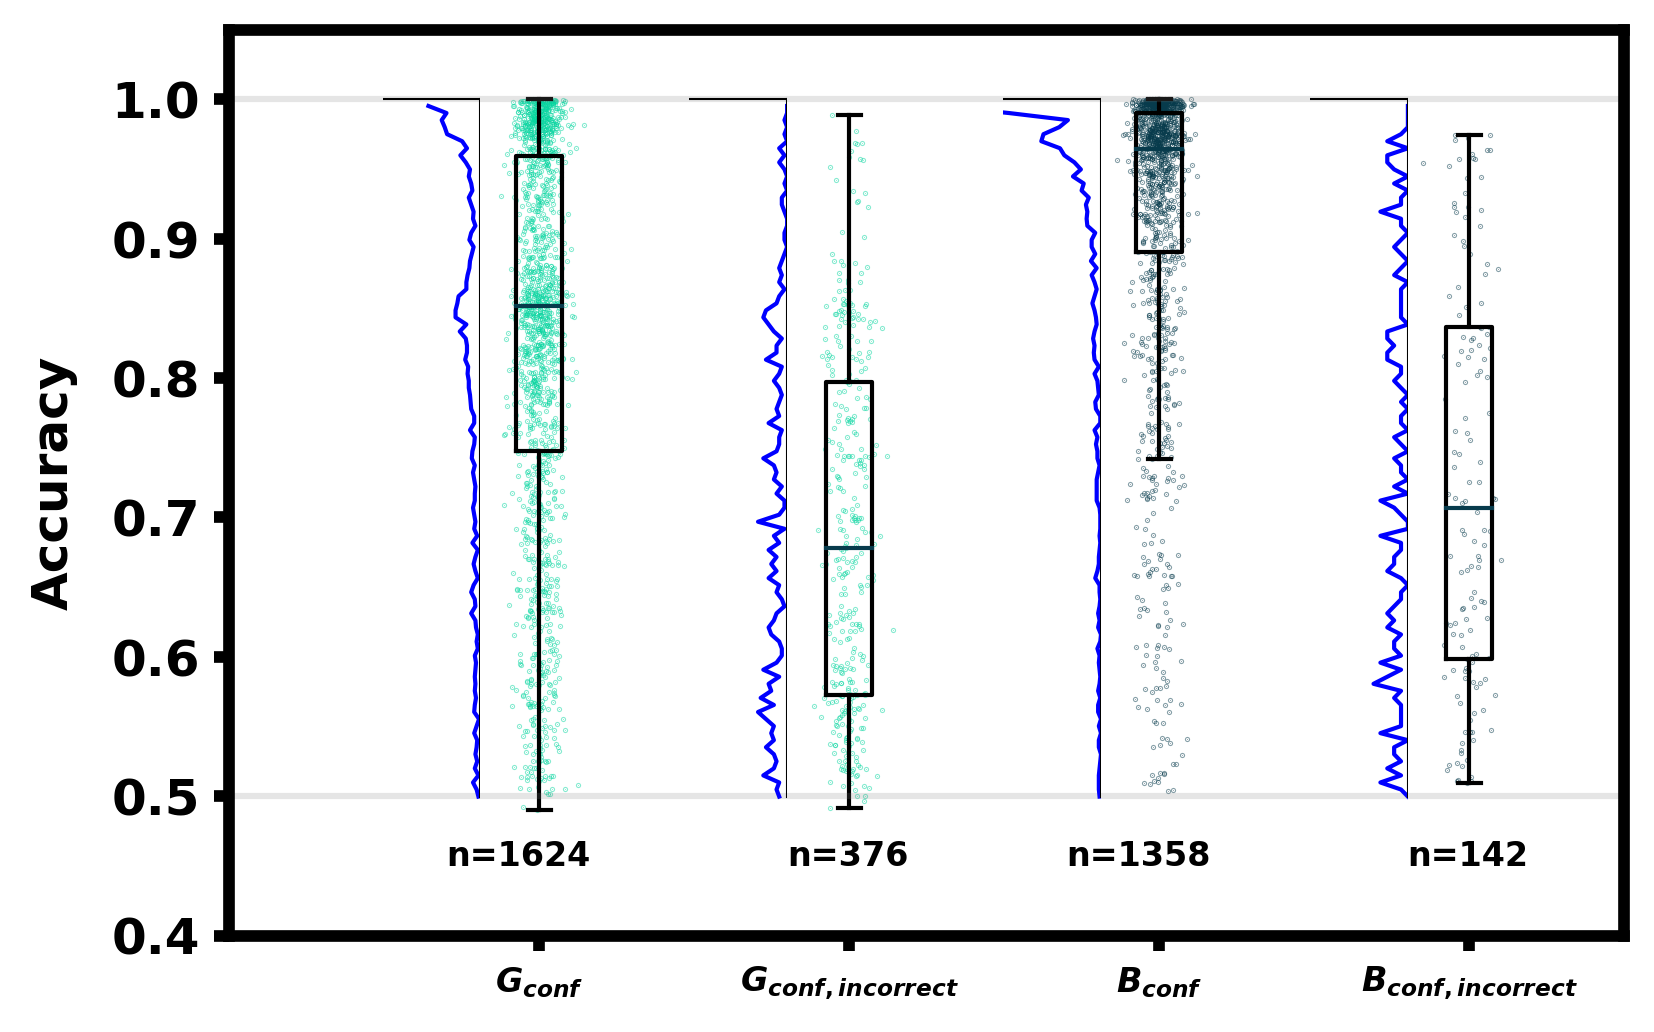

In [ ]:
#@title confidence box plots vs accuracy
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(111)


g_true_nonoise_labels_50 = g_true_labels_50[:2000]
b_true_nonoise_labels_50 = b_true_labels_50[:1500]
g_labels_predicted_50_nonoise = g_labels_predicted_50[:2000]
b_labels_predicted_50_nonoise = b_labels_predicted_50[:1500]
g_confidence_50_nonoise = g_confidence_50[:2000]
b_confidence_50_nonoise = b_confidence_50[:1500]

ys = [np.array(g_confidence_50_nonoise)[np.where(g_true_nonoise_labels_50 == g_labels_predicted_50_nonoise)],
      np.array(g_confidence_50_nonoise)[np.where(g_true_nonoise_labels_50 != g_labels_predicted_50_nonoise)],
      np.array(b_confidence_50_nonoise)[np.where(b_true_nonoise_labels_50 == b_labels_predicted_50_nonoise)],
      np.array(b_confidence_50_nonoise)[np.where(b_true_nonoise_labels_50 != b_labels_predicted_50_nonoise)],]

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=axisbg)  # matplotlib 2.0+

    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

for i in [0,1,2,3]:
  x = np.random.normal(i, 0.04, size=len(ys[i]))+1
  ax1.plot(x, ys[i], '.', alpha=0.5, markersize=.5, color=[colors[2],colors[2], colors[1], colors[1] ][i])

  xx,yy = np.histogram(ys[i], np.linspace(.5,1,100), density=True)
  
  axsub = add_subplot_axes(ax1,[[.11,.115,.07,.847], [.33,.115,.07,.847], [.555,.115,.07,.847], [.775,.115,.07,.847]][i])
  axsub.plot(xx/xx.sum(),yy[:-1],'b-',lw=1)
  axsub.plot([0,0],[.5,1],'k-',lw=.5)
  axsub.plot([0,.1],[1,1],'k-',lw=.5)
  axsub.set_xlim([0,.1])
  #axsub.invert_yaxis()
  axsub.invert_xaxis()
  axsub.axis('off')


ax1.boxplot(np.array(g_confidence_50_nonoise)[np.where(g_true_nonoise_labels_50 == g_labels_predicted_50_nonoise)])
ax1.boxplot(np.array(g_confidence_50_nonoise)[np.where(g_true_nonoise_labels_50 != g_labels_predicted_50_nonoise)], positions=[2])

ax1.boxplot(np.array(b_confidence_50_nonoise)[np.where(b_true_nonoise_labels_50 == b_labels_predicted_50_nonoise)], positions=[3], showfliers=False)
ax1.boxplot(np.array(b_confidence_50_nonoise)[np.where(b_true_nonoise_labels_50 != b_labels_predicted_50_nonoise)], positions=[4])
ax1.plot([0,4.5],[.5,.5],color='gray',alpha=.2)
ax1.plot([0,4.5],[1,1],color='gray',alpha=.2)

ax1.set_ylim([.4,1.05])
ax1.set_xlim([0,4.5])

ax1.set_xticklabels([r'$G_{conf}$',r'$G_{conf, incorrect}$', r'$B_{conf}$',r'$B_{conf, incorrect}$'], fontsize=8)
ax1.set_ylabel('Accuracy')
ax1.text(.7,.45,'n=%s'%(int(len(ys[0])) ), fontsize=8)
ax1.text(1.8,.45,'n=%s'%(int(len(ys[1])) ), fontsize=8)
ax1.text(2.7,.45,'n=%s'%(int(len(ys[2])) ), fontsize=8)
ax1.text(3.8,.45,'n=%s'%(int(len(ys[3])) ), fontsize=8)

plt.savefig('acc.svg')

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


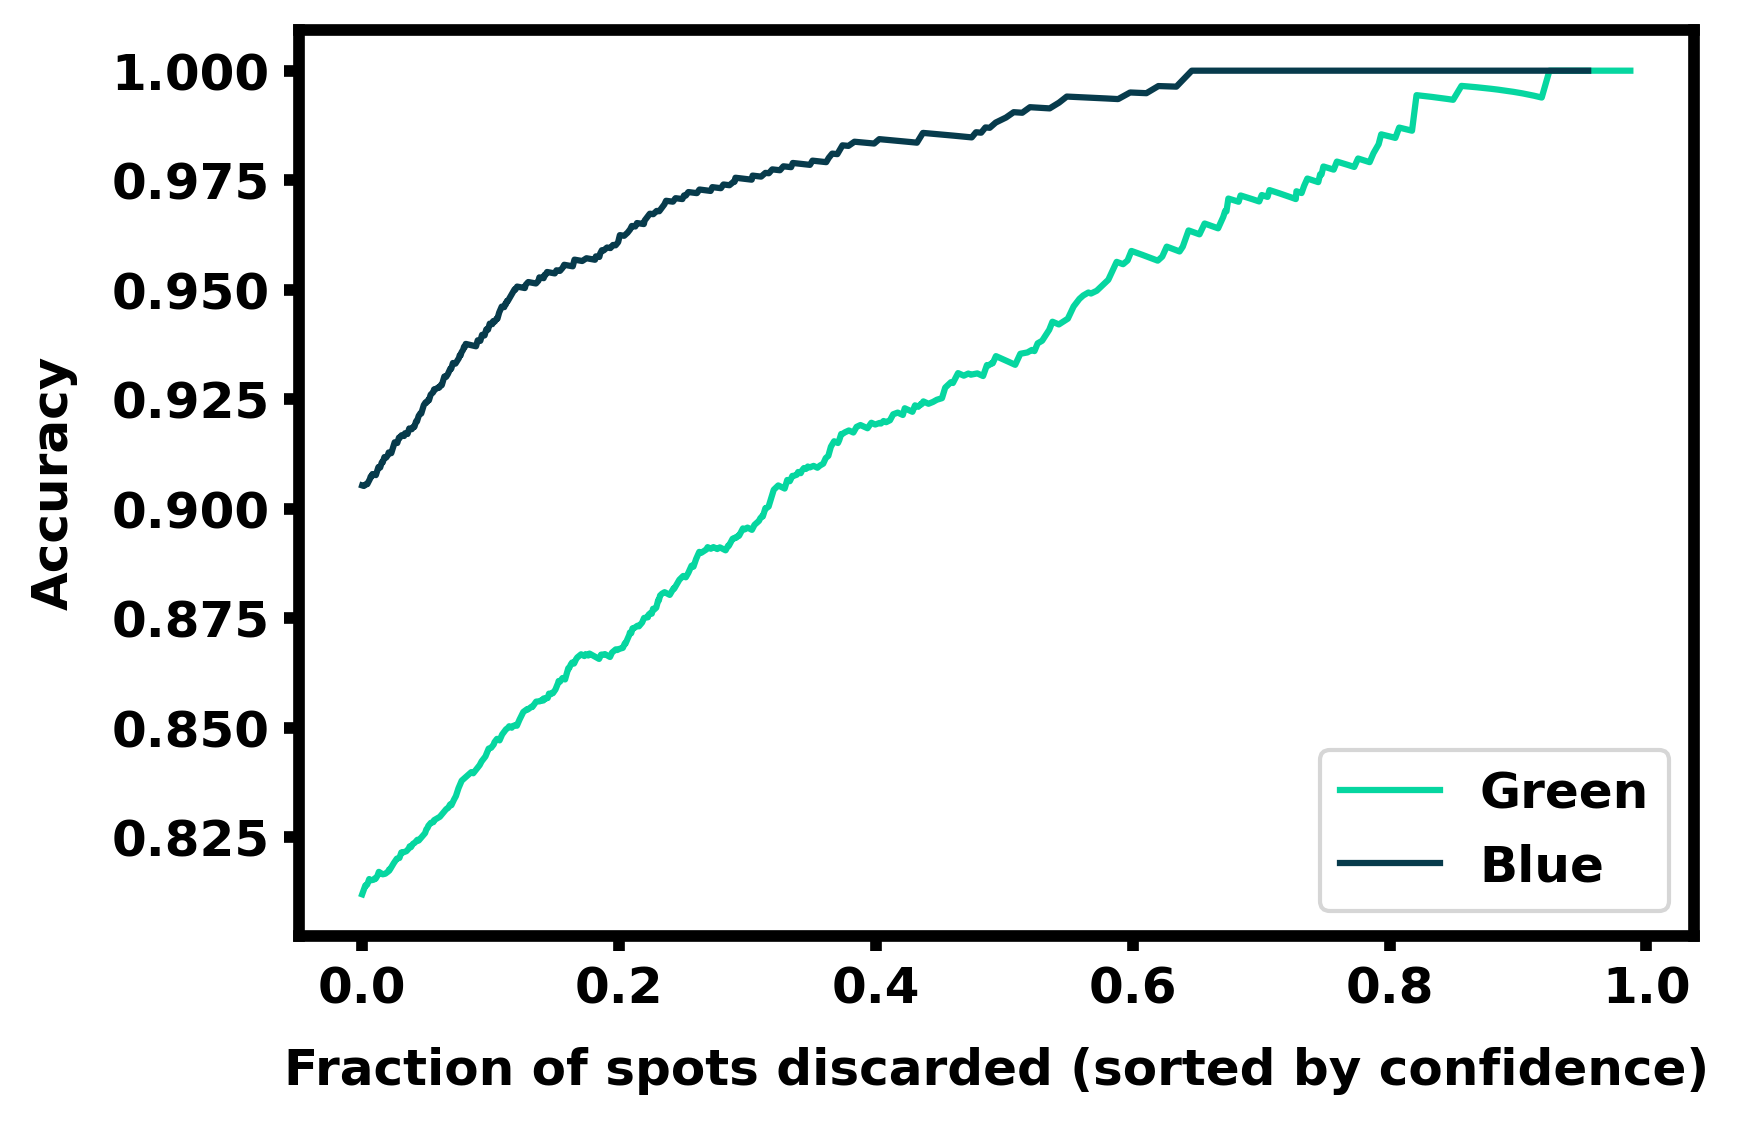

In [ ]:
#@title Accuracy discarding the fraction of unconfident spots
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(111)

g_true_nonoise_labels_50 = g_true_labels_50[:2000]
b_true_nonoise_labels_50 = b_true_labels_50[:1500]
g_labels_predicted_50_nonoise = g_labels_predicted_50[:2000]
b_labels_predicted_50_nonoise = b_labels_predicted_50[:1500]
g_confidence_50_nonoise = g_confidence_50[:2000]
b_confidence_50_nonoise = b_confidence_50[:1500]


threshes = np.linspace(0,1,1000)

ys = np.array([(len(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh]), accuracy_score(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh],g_labels_predicted_50_nonoise[np.array(g_confidence_50_nonoise) > thresh])) for thresh in threshes])
plt.plot((2000-ys[:,0])/2000,ys[:,1], color=colors[2])

ys = np.array([(len(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh]), accuracy_score(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh],b_labels_predicted_50_nonoise[np.array(b_confidence_50_nonoise) > thresh])) for thresh in threshes])
plt.plot((1500-ys[:,0])/1500,ys[:,1], color=colors[1])

plt.xlabel('Fraction of spots discarded (sorted by confidence)')
plt.ylabel('Accuracy')
plt.legend(['Green','Blue'])
plt.savefig('accvconf.svg')

Text(0, 0.5, 'Prob Predicted')

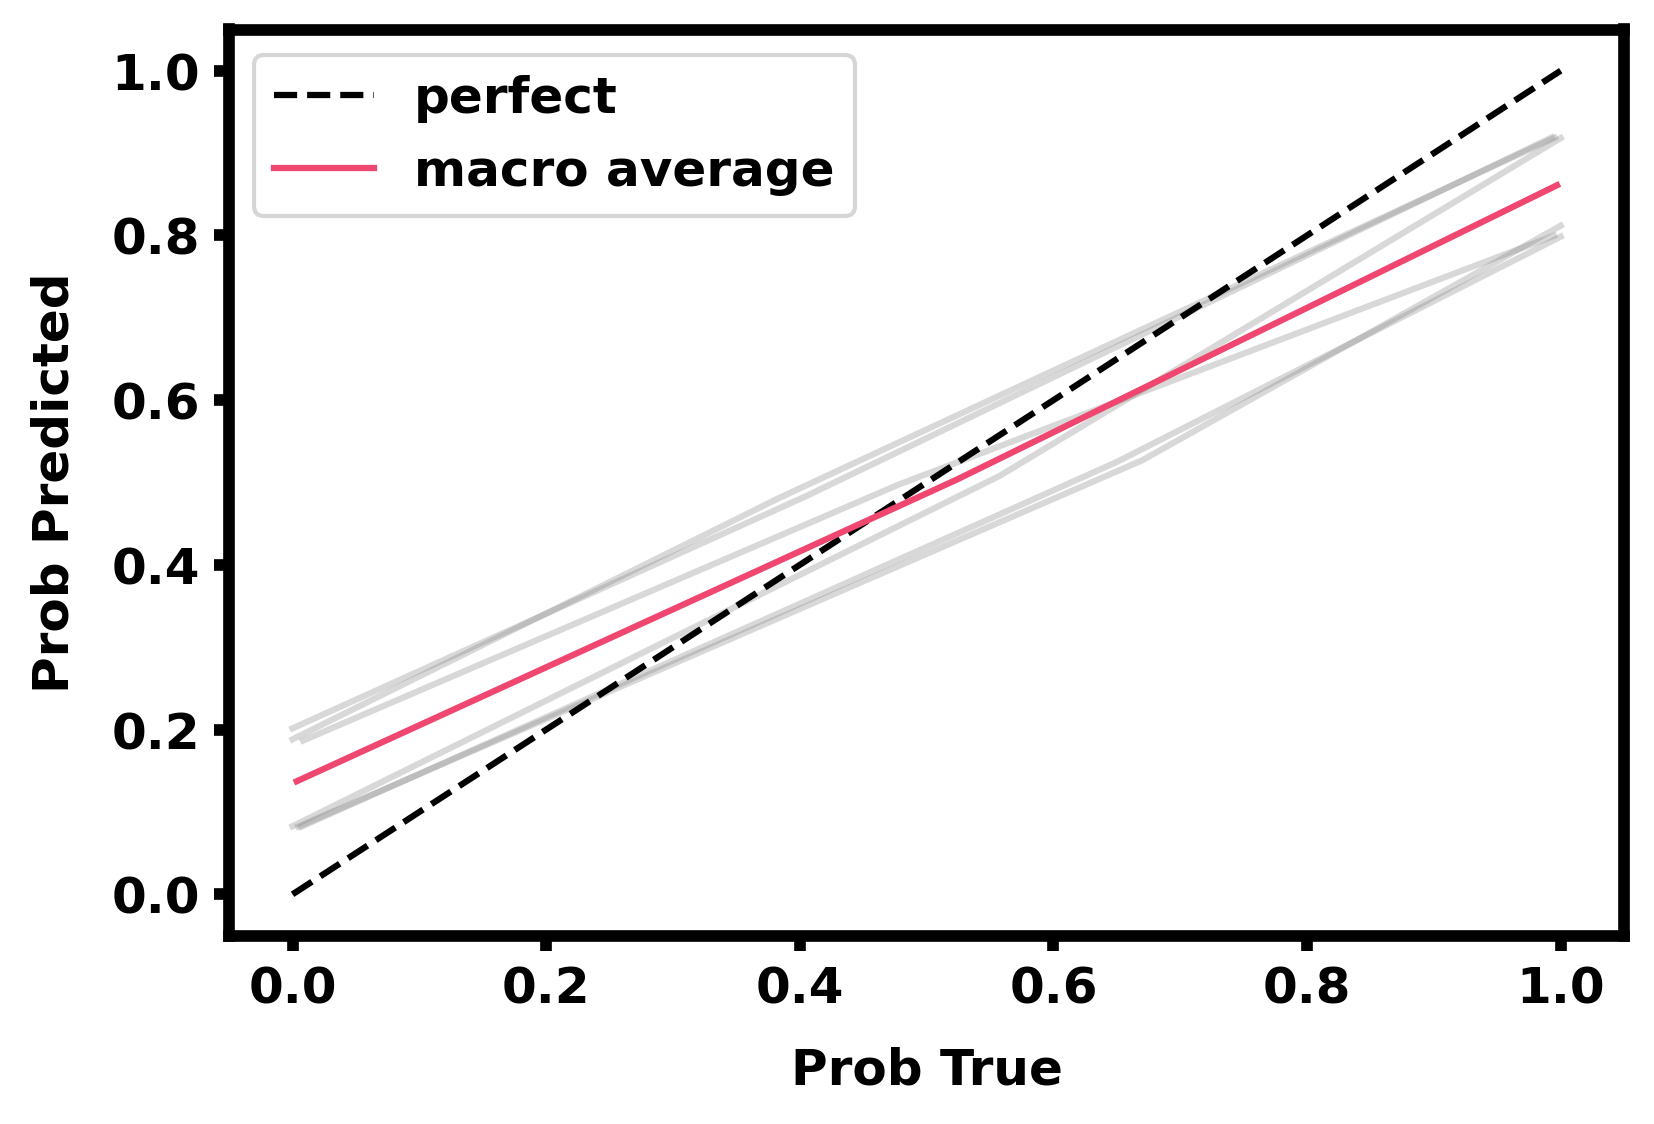

In [ ]:
#@title Confidence Calibration curve G channel
from sklearn.calibration import calibration_curve
xs = []
ys = []
for i in range(0,6):
  combos = [(0,1), (1,2), (2,3), (0,2), (0,3), (1,3)][i]
  sub = [0,1,2,1,2,2]
  true_labels = g_true_nonoise_labels_50[(g_true_nonoise_labels_50 == combos[0]) + (g_true_nonoise_labels_50 == combos[1])] - sub[i] 

  true_labels[true_labels < 0] = 0

  pos_conf = np.array(g_confidence_50_nonoise)[(g_true_nonoise_labels_50 == combos[0]) + (g_true_nonoise_labels_50 == combos[1])]
  neg_conf = 1 - np.array(g_confidence_50_nonoise)[(g_true_nonoise_labels_50 == combos[0]) + (g_true_nonoise_labels_50 == combos[1])]

  cc = []
  for i in range(len(pos_conf)):
    if true_labels[i] == 0:
      cc.append(neg_conf[i])
    else:
      cc.append(pos_conf[i])
  x,y = calibration_curve(true_labels,cc, n_bins=3)
  xs.append(x)
  ys.append(y)
  plt.plot(x,y,color='gray', alpha=.3, label='_nolegend_')
plt.plot([0,1],[0,1],'k--')
plt.plot(np.mean(np.array(xs),axis=0), np.mean(np.array(ys),axis=0) )
plt.legend(['perfect','macro average'])
plt.xlabel('Prob True')
plt.ylabel('Prob Predicted')

Text(0, 0.5, 'Prob Predicted')

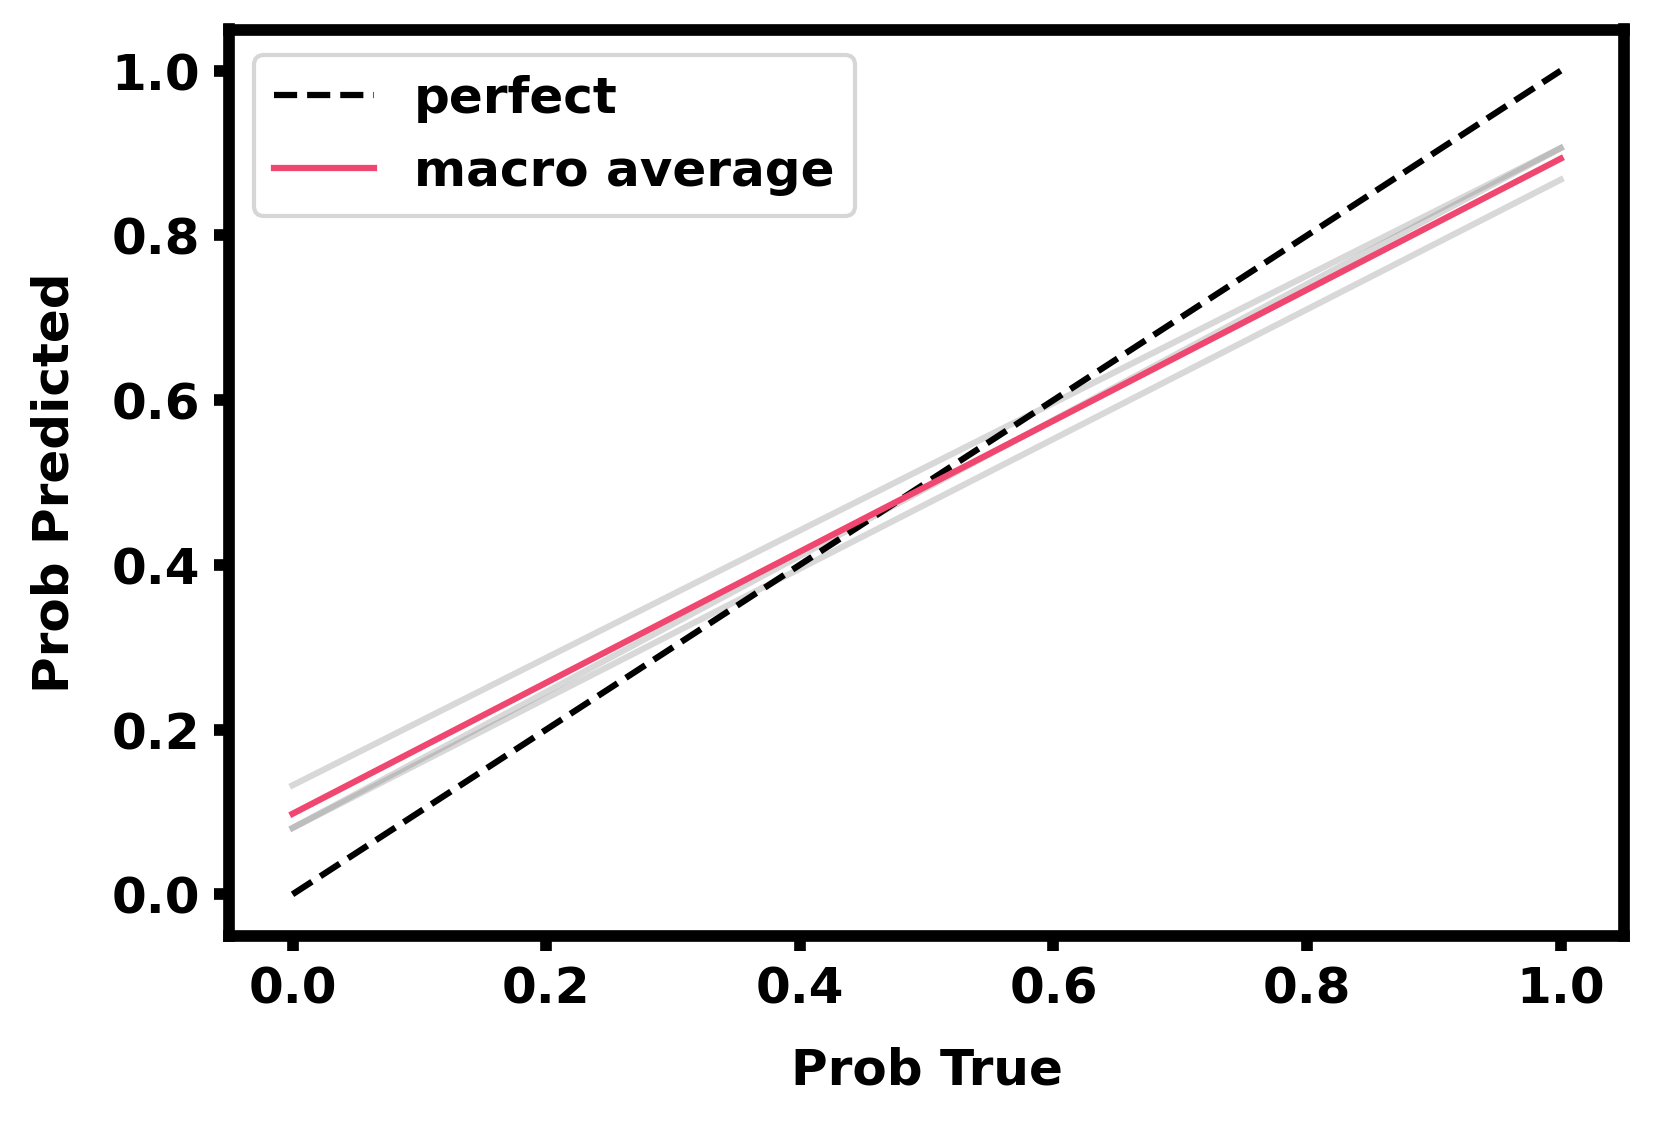

In [ ]:
#@title Confidence Calibration curve B channel
xs = []
ys = []
for i in range(0,3):
  true_labels = b_true_nonoise_labels_50[b_true_nonoise_labels_50 != i] - [1,1,0][i]
  if i == 1:
    true_labels[true_labels < 0] = 0
  pos_conf = np.array(b_confidence_50_nonoise)[b_true_nonoise_labels_50 != i]
  neg_conf = 1 - np.array(b_confidence_50_nonoise)[b_true_nonoise_labels_50 != i]
  cc = []
  for i in range(len(pos_conf)):
    if true_labels[i] == 0:
      cc.append(neg_conf[i])
    else:
      cc.append(pos_conf[i])
  x,y = calibration_curve(true_labels,cc, n_bins=2)
  xs.append(x)
  ys.append(y)
  plt.plot(x,y,color='gray', alpha=.3, label='_nolegend_')
plt.plot([0,1],[0,1],'k--')
plt.plot(np.mean(np.array(xs),axis=0), np.mean(np.array(ys),axis=0) )
plt.legend(['perfect','macro average'])
plt.xlabel('Prob True')
plt.ylabel('Prob Predicted')

### Brier multi score

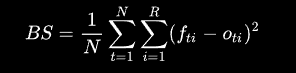

In [ ]:
def brier_multi(y_true, y_pred):
  return np.mean(np.sum((y_true - y_pred)**2, axis=1))

print('Green BS:')
print(brier_multi(g_onehot_true,g_onehot_predicted_50 ))
print('Blue BS:')
print(brier_multi(b_onehot_true,b_onehot_predicted_50 ))

Green BS:
0.21210606634192822
Blue BS:
0.10415664184077233


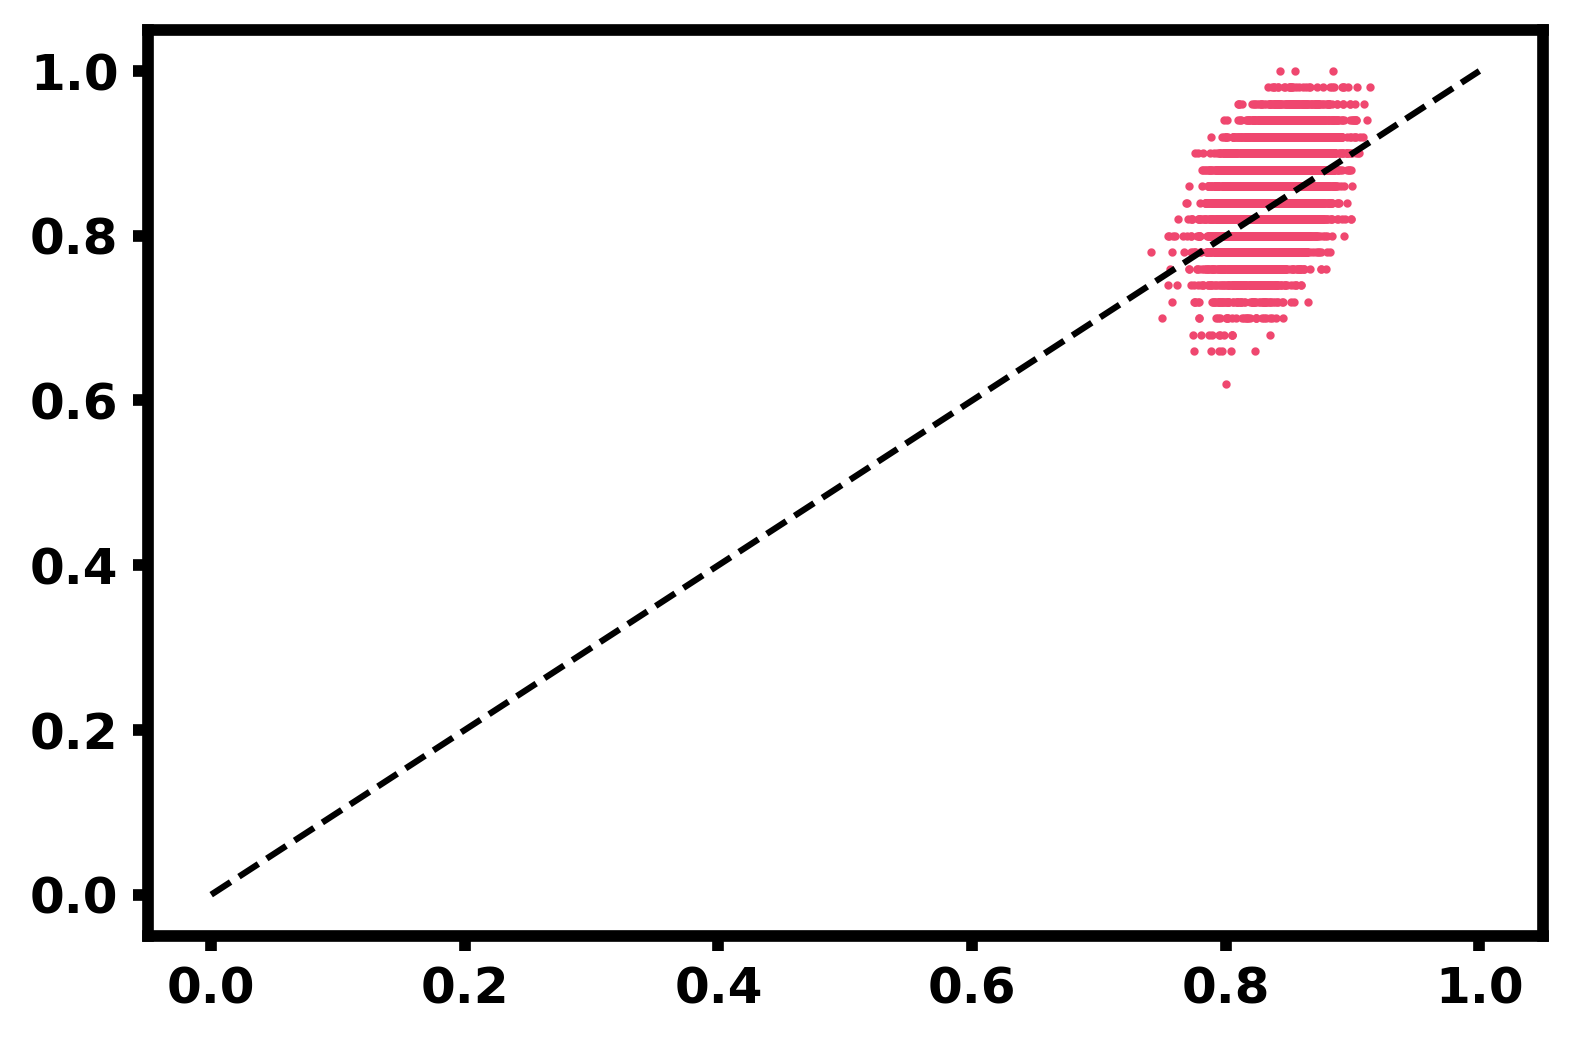

In [ ]:
gcc = np.array([g_confidence_50, g_right_50])
bcc = np.array([b_confidence_50, b_right_50])
rng = np.random.default_rng(0)
rng.choice(gcc,axis=1,replace=False)

binsize = 50
acc_s = []
conf_s = []
for i in range(10000):
  conf_bin,acc_bin = np.mean(rng.choice(gcc,axis=1,replace=False, size=binsize),axis=1)
  
  acc_s.append(acc_bin)
  conf_s.append(conf_bin)



plt.scatter(conf_s,acc_s,s=1)
plt.plot([0,1],[0,1],'k--')

(array([  4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,  88.,  85.,  85.,  83.,  86.,  94., 121.,
        100., 144., 210., 165., 127., 108., 145., 852.]),
 array([3.2411338e-11, 3.3320751e-02, 6.6641502e-02, 9.9962249e-02,
        1.3328300e-01, 1.6660376e-01, 1.9992450e-01, 2.3324525e-01,
        2.6656601e-01, 2.9988676e-01, 3.3320752e-01, 3.6652827e-01,
        3.9984900e-01, 4.3316975e-01, 4.6649051e-01, 4.9981126e-01,
        5.3313202e-01, 5.6645274e-01, 5.9977353e-01, 6.3309425e-01,
        6.6641504e-01, 6.9973576e-01, 7.3305655e-01, 7.6637727e-01,
        7.9969800e-01, 8.3301878e-01, 8.6633950e-01, 8.9966029e-01,
        9.3298101e-01, 9.6630180e-01, 9.9962252e-01], dtype=float32),
 <a list of 30 Patch objects>)

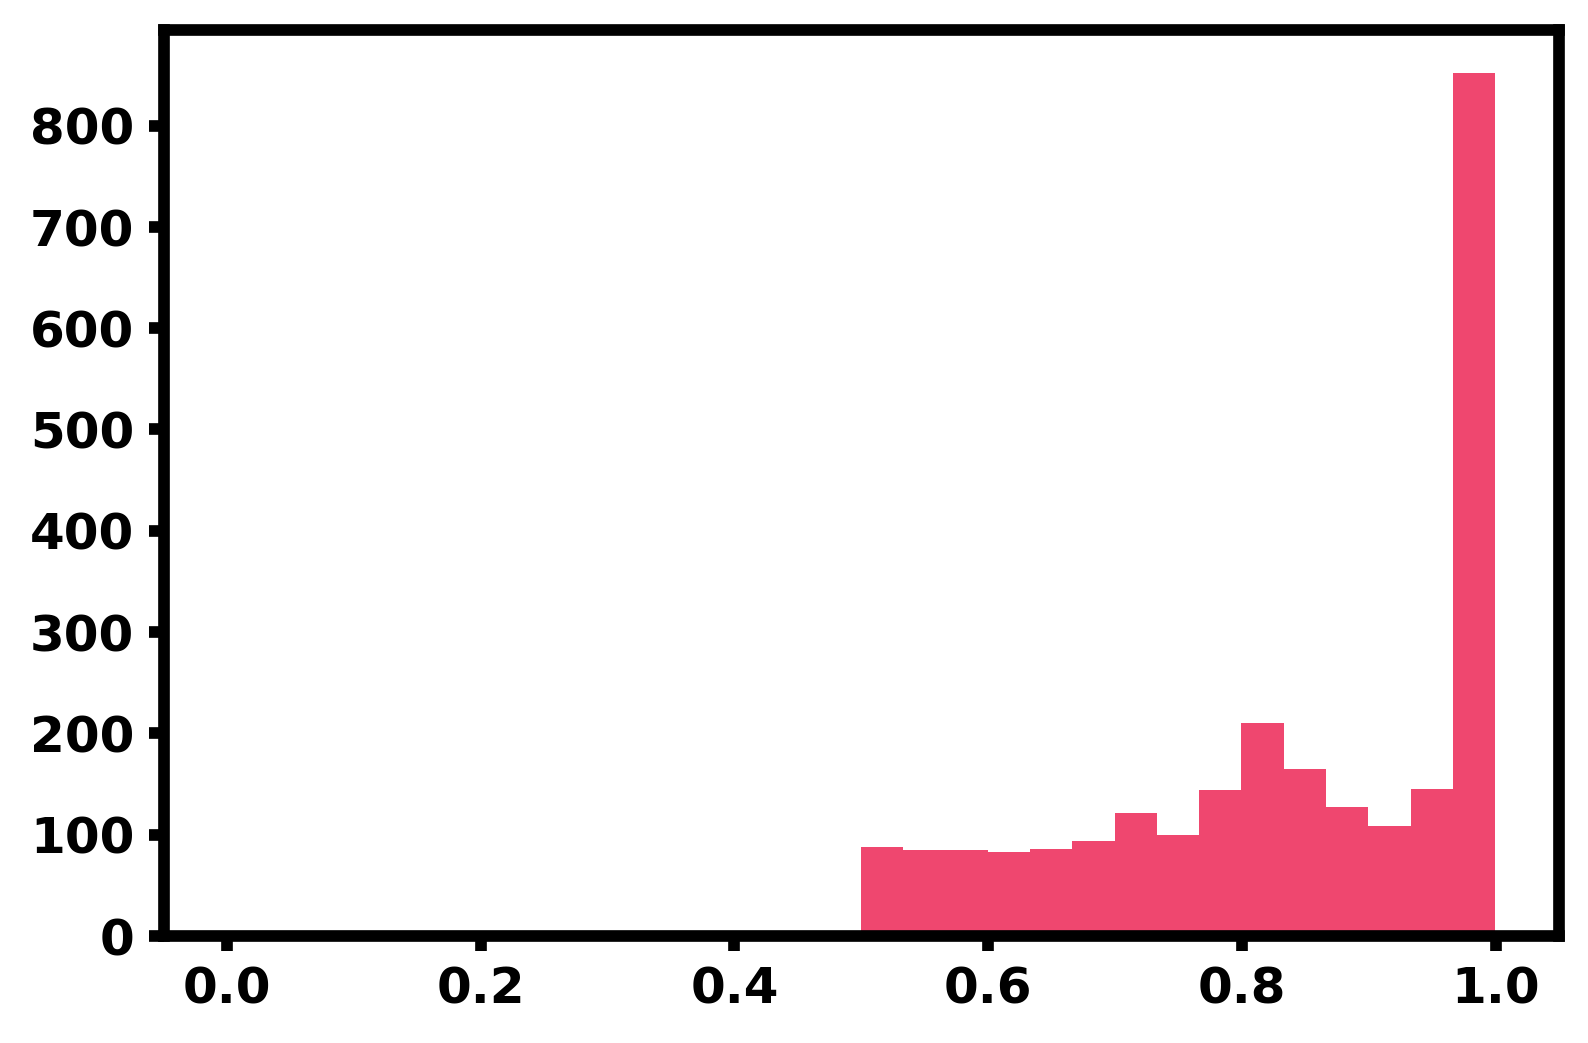

In [ ]:
plt.hist(g_confidence_50,bins=30)

(array([ 0.68516104,  0.4433411 ,  0.48364309,  0.52394668,  0.60455604,
         0.64485745,  0.48364309,  0.72546463,  0.4433411 ,  0.72546463,
         0.56425027,  0.32242989,  0.76576822,  0.76576822,  0.72546463,
         0.96728966,  0.52394668,  0.80607181,  1.12850461,  1.53153645,
         1.24941131,  1.41063076,  1.2897149 ,  1.69275081,  1.93457932,
         2.90185853,  3.94975189,  5.6425027 ,  9.99532651, 16.52447218]),
 array([0.50376284, 0.52030396, 0.536845  , 0.55338615, 0.5699273 ,
        0.58646834, 0.60300946, 0.6195506 , 0.6360917 , 0.6526328 ,
        0.6691739 , 0.685715  , 0.7022561 , 0.7187972 , 0.73533833,
        0.75187945, 0.7684205 , 0.78496164, 0.80150276, 0.8180438 ,
        0.83458495, 0.8511261 , 0.86766714, 0.88420826, 0.9007494 ,
        0.91729045, 0.9338316 , 0.9503727 , 0.9669138 , 0.9834549 ,
        0.999996  ], dtype=float32),
 <a list of 30 Patch objects>)

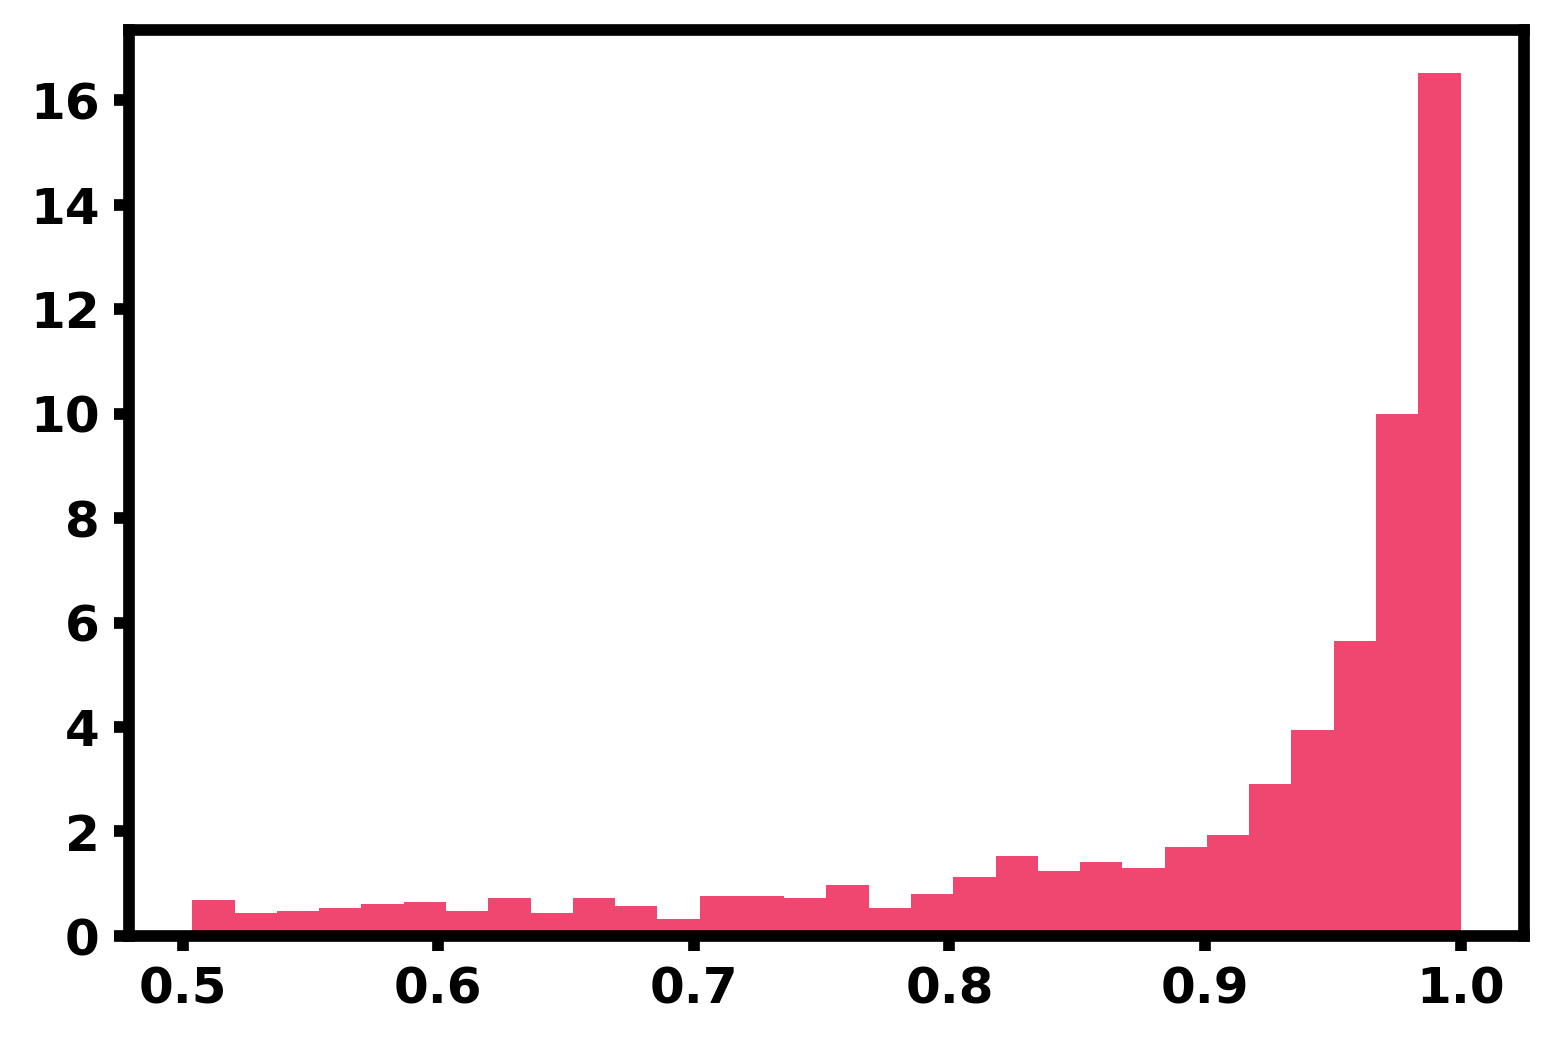

In [ ]:
plt.hist(b_confidence_50_nonoise,bins=30, density=True)

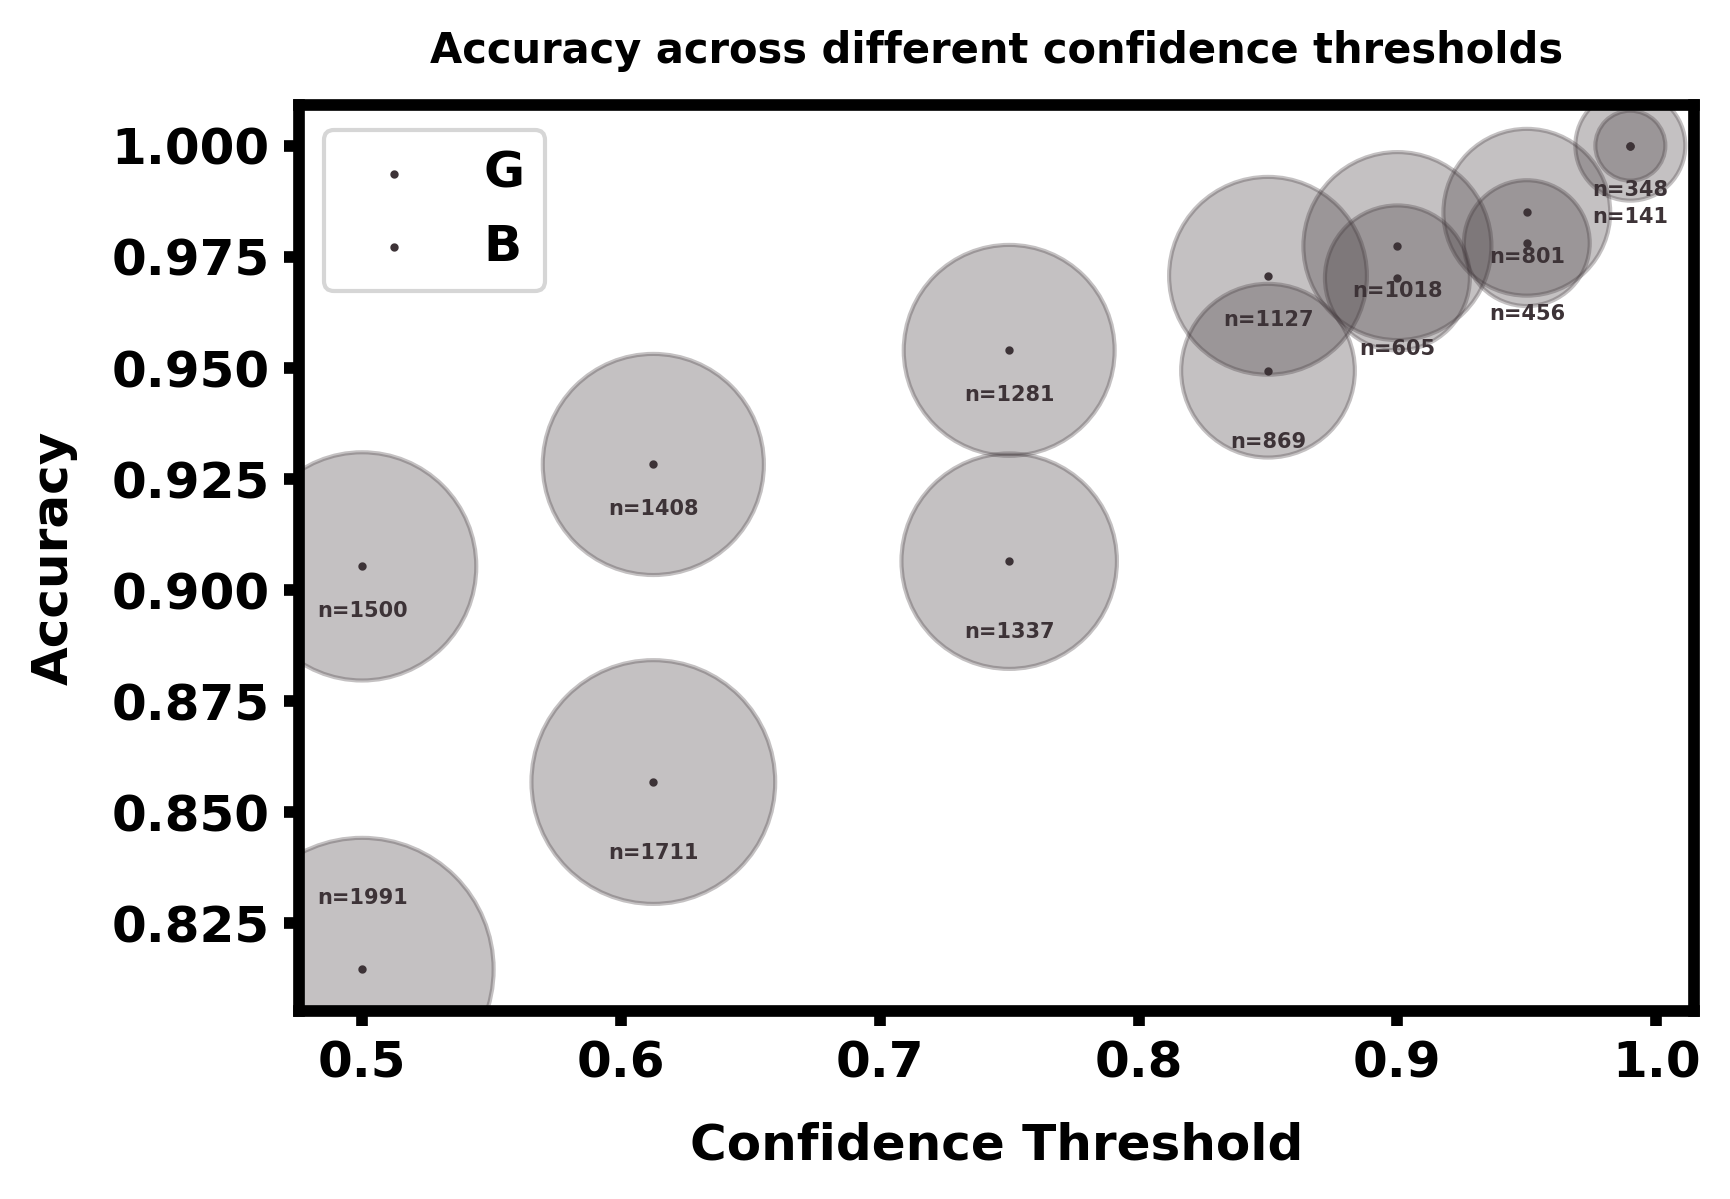

In [ ]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(111)


g_true_nonoise_labels_50 = g_true_labels_50[:2000]
b_true_nonoise_labels_50 = b_true_labels_50[:1500]
g_labels_predicted_50_nonoise = g_labels_predicted_50[:2000]
b_labels_predicted_50_nonoise = b_labels_predicted_50[:1500]
g_confidence_50_nonoise = g_confidence_50[:2000]
b_confidence_50_nonoise = b_confidence_50[:1500]


confidence_thresh = [.5,.6125,.75,.85,.9,.95,.99]

ys = np.array([(len(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh]), accuracy_score(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh],g_labels_predicted_50_nonoise[np.array(g_confidence_50_nonoise) > thresh])) for thresh in confidence_thresh])

plt.scatter(confidence_thresh,ys[:,1], s = ys[:,0]*2,zorder=1, facecolor=colors[2], alpha=.3,  label='_nolegend_')
plt.scatter(confidence_thresh,ys[:,1], s = 1, zorder=0, facecolor=colors[2], alpha=1)
for i in range(len(confidence_thresh)):
  if i == 0:
    t = .016
  else:
    t = -.016
  plt.text(confidence_thresh[i],ys[i,1]+t, 'n=%s'%(int(ys[i,0])), color=colors[2],ha='center',va='center', fontsize=5  )

ys = np.array([(len(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh]), accuracy_score(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh],b_labels_predicted_50_nonoise[np.array(b_confidence_50_nonoise) > thresh])) for thresh in confidence_thresh])

plt.scatter(confidence_thresh,ys[:,1], s = ys[:,0]*2, zorder=0, facecolor=colors[1], alpha=.3, label='_nolegend_')
plt.scatter(confidence_thresh,ys[:,1], s = 1, zorder=0, facecolor=colors[1], alpha=1,)
for i in range(len(confidence_thresh)):
  plt.text(confidence_thresh[i],ys[i,1]-.01, 'n=%s'%(int(ys[i,0])), color=colors[1],ha='center',va='center', fontsize=5  )

plt.legend(['G','B'])
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy across different confidence thresholds')
plt.savefig('conf_acc_spots.svg')

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


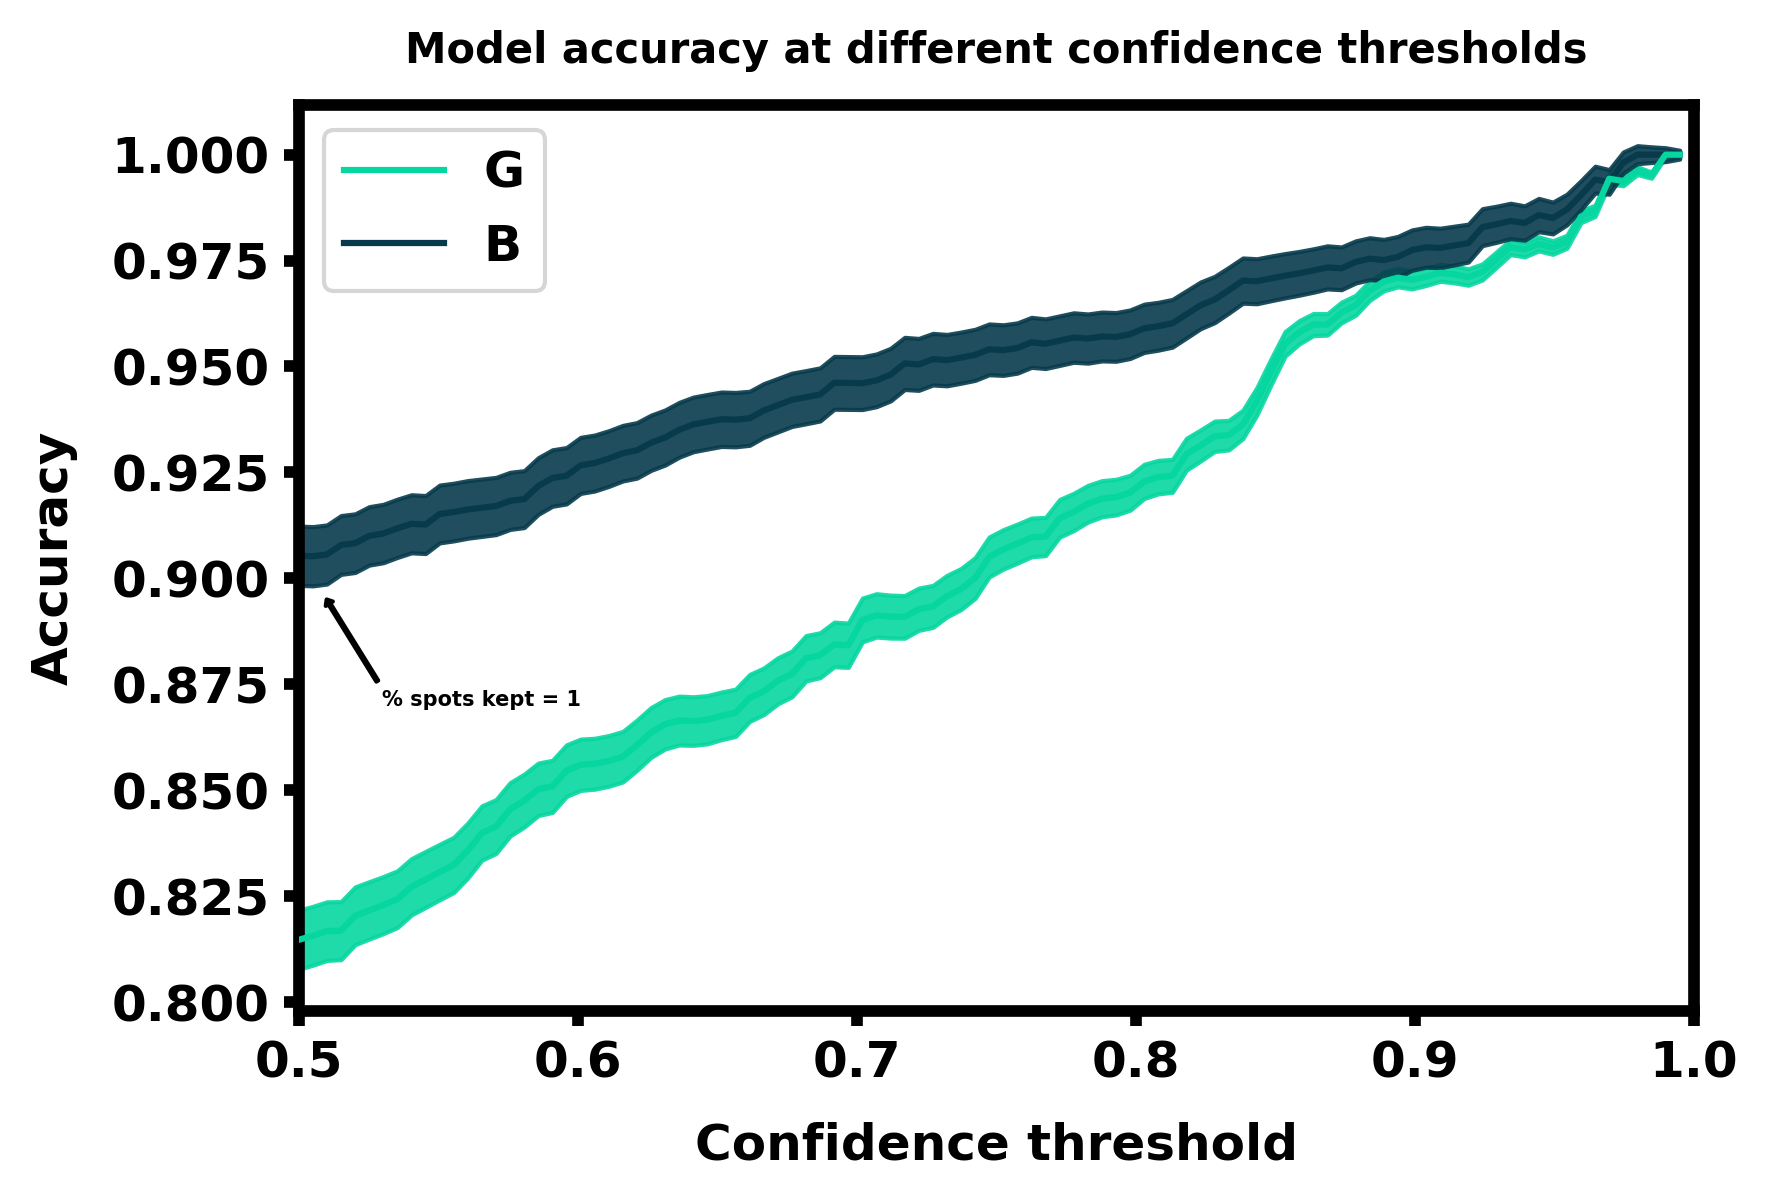

In [ ]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(111)


g_true_nonoise_labels_50 = g_true_labels_50[:2000]
b_true_nonoise_labels_50 = b_true_labels_50[:1500]
g_labels_predicted_50_nonoise = g_labels_predicted_50[:2000]
b_labels_predicted_50_nonoise = b_labels_predicted_50[:1500]
g_confidence_50_nonoise = g_confidence_50[:2000]
b_confidence_50_nonoise = b_confidence_50[:1500]


threshes = np.linspace(.5,1,100)

ys = np.array([(len(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh]), accuracy_score(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh],g_labels_predicted_50_nonoise[np.array(g_confidence_50_nonoise) > thresh])) for thresh in threshes])

#plt.scatter(threshes,ys[:,1], s = ys[:,0]*2,zorder=1, facecolor=colors[2], alpha=.1)
plt.plot(threshes,ys[:,1], zorder=3, color=colors[2], alpha=1)
plt.fill_between(threshes, ys[:,1] + .007*ys[:,0]/2000, ys[:,1] - .007*ys[:,0]/2000, color = colors[2], alpha=.9, label='_nolegend_')

ys = np.array([(len(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh]), accuracy_score(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh],b_labels_predicted_50_nonoise[np.array(b_confidence_50_nonoise) > thresh])) for thresh in threshes])

#plt.scatter(threshes,ys[:,1], s = ys[:,0]*2, zorder=0, facecolor=colors[1], alpha=.1)
plt.plot(threshes,ys[:,1], zorder=2, color=colors[1], alpha=1)
plt.fill_between(threshes, ys[:,1] + .007*ys[:,0]/1500, ys[:,1] - .007*ys[:,0]/1500, color = colors[1], alpha=.9, label='_nolegend_')

plt.legend(['G','B'])
plt.xlim([.5,1])
plt.ylabel('Accuracy')
plt.xlabel('Confidence threshold')
plt.title('Model accuracy at different confidence thresholds')
ax1.annotate('% spots kept = 1', xy=(0.51, 0.895),  xycoords='data',
            xytext=(0.53, 0.87), textcoords='data',
            arrowprops=dict(facecolor='black', width=.5, headlength=1.2, headwidth=2),
             fontsize=5
            
            )
plt.savefig('conf_acc_lw.svg')

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


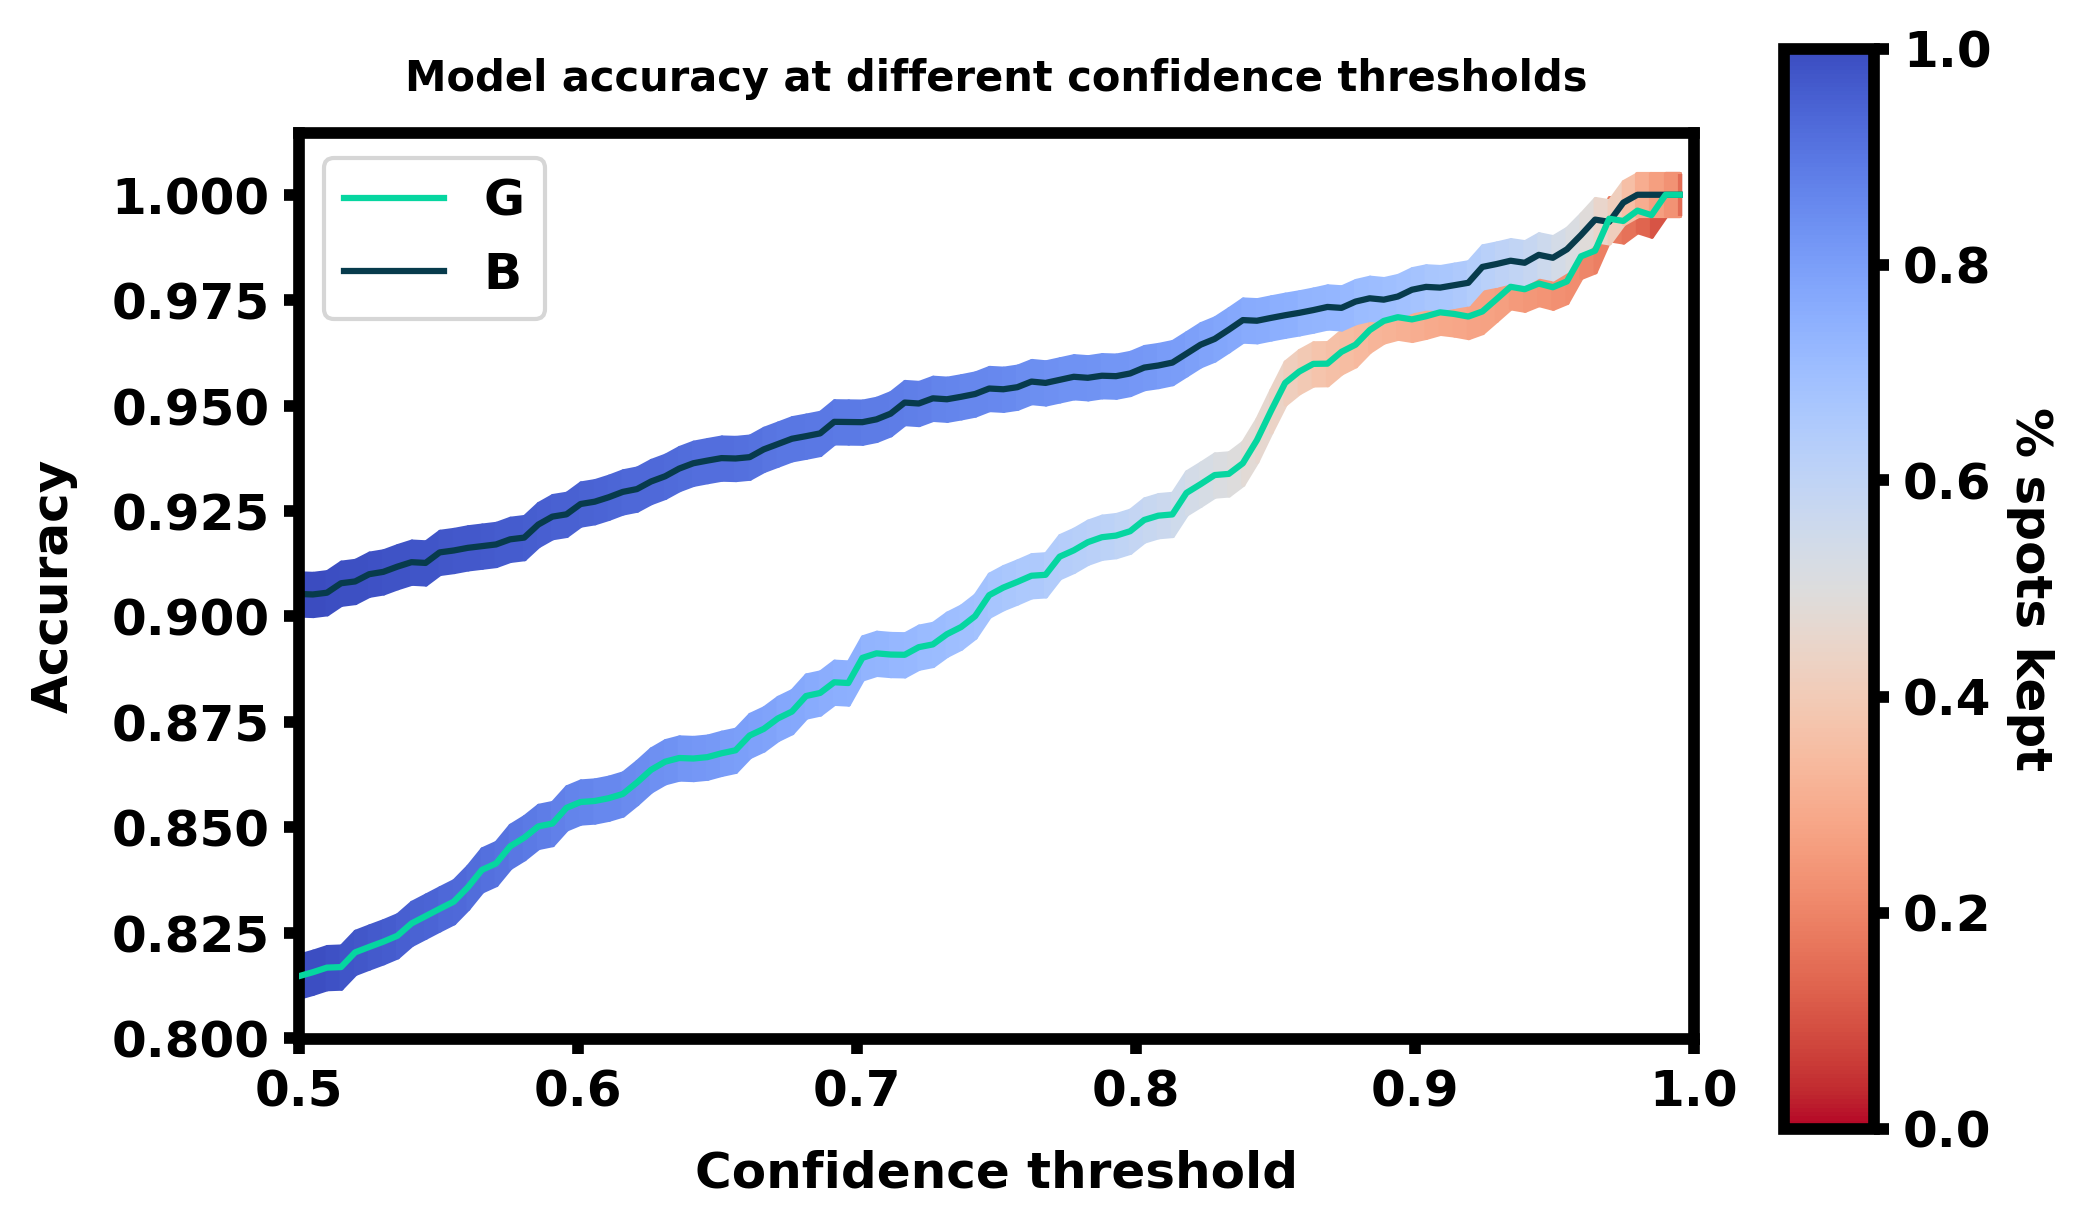

In [ ]:
from scipy.stats import norm
import matplotlib as mpl
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(111)

cmap = mpl.cm.coolwarm_r
g_true_nonoise_labels_50 = g_true_labels_50[:2000]
b_true_nonoise_labels_50 = b_true_labels_50[:1500]
g_labels_predicted_50_nonoise = g_labels_predicted_50[:2000]
b_labels_predicted_50_nonoise = b_labels_predicted_50[:1500]
g_confidence_50_nonoise = g_confidence_50[:2000]
b_confidence_50_nonoise = b_confidence_50[:1500]

threshes = np.linspace(.5,1,100)

ys = np.array([(len(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh]), accuracy_score(g_true_nonoise_labels_50[np.array(g_confidence_50_nonoise) > thresh],g_labels_predicted_50_nonoise[np.array(g_confidence_50_nonoise) > thresh])) for thresh in threshes])

#plt.scatter(threshes,ys[:,1], s = ys[:,0]*2,zorder=1, facecolor=colors[2], alpha=.1)
plt.plot(threshes,ys[:,1], zorder=3, color=colors[2], alpha=1)
#plt.fill_between(threshes, ys[:,1] + .007*ys[:,0]/2000, ys[:,1] - .007*ys[:,0]/2000, color = colors[2], alpha=.9, label='_nolegend_')

npots = 100
normalize = mpl.colors.Normalize(vmin=0, vmax=2000)
x = threshes
y1 = ys[:,1] + .005
y2 = ys[:,1] - .005
z = ys[:,0]
for i in range(npots - 1):
  #plt.fill_between(threshes, ys[:,1] + .007*ys[:,0]/1500, ys[:,1] - .007*ys[:,0]/1500, color = colors[1], alpha=.9, label='_nolegend_')
  plt.fill_between([x[i], x[i+1]], [y1[i], y1[i+1]], [y2[i], y2[i+1]], color=cmap(normalize(z[i])), label='_nolegend_')


ys = np.array([(len(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh]), accuracy_score(b_true_nonoise_labels_50[np.array(b_confidence_50_nonoise) > thresh],b_labels_predicted_50_nonoise[np.array(b_confidence_50_nonoise) > thresh])) for thresh in threshes])

#plt.scatter(threshes,ys[:,1], s = ys[:,0]*2, zorder=0, facecolor=colors[1], alpha=.1)
plt.plot(threshes,ys[:,1], zorder=2, color=colors[1], alpha=1)
#plt.fill_between(threshes, ys[:,1] + .007*ys[:,0]/1500, ys[:,1] - .007*ys[:,0]/1500, color = colors[1], alpha=.9, label='_nolegend_')

plt.legend(['G','B'])
plt.xlim([.5,1])
plt.ylabel('Accuracy')
plt.xlabel('Confidence threshold')
plt.title('Model accuracy at different confidence thresholds')


npots = 100
normalize = mpl.colors.Normalize(vmin=0, vmax=1500)
x = threshes
y1 = ys[:,1] + .005
y2 = ys[:,1] - .005
z = ys[:,0]
for i in range(npots - 1):
  #plt.fill_between(threshes, ys[:,1] + .007*ys[:,0]/1500, ys[:,1] - .007*ys[:,0]/1500, color = colors[1], alpha=.9, label='_nolegend_')
  plt.fill_between([x[i], x[i+1]], [y1[i], y1[i+1]], [y2[i], y2[i+1]], color=cmap(normalize(z[i])), label='_nolegend_')


cbax = fig.add_axes([0.95, 0.05, 0.05, 0.9])
cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, orientation='vertical')
cb.set_label("% spots kept", rotation=270, labelpad=15)

plt.savefig('conf_acc_cmap.svg')

# Confusion Matrices

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<Figure size 1800x1200 with 0 Axes>

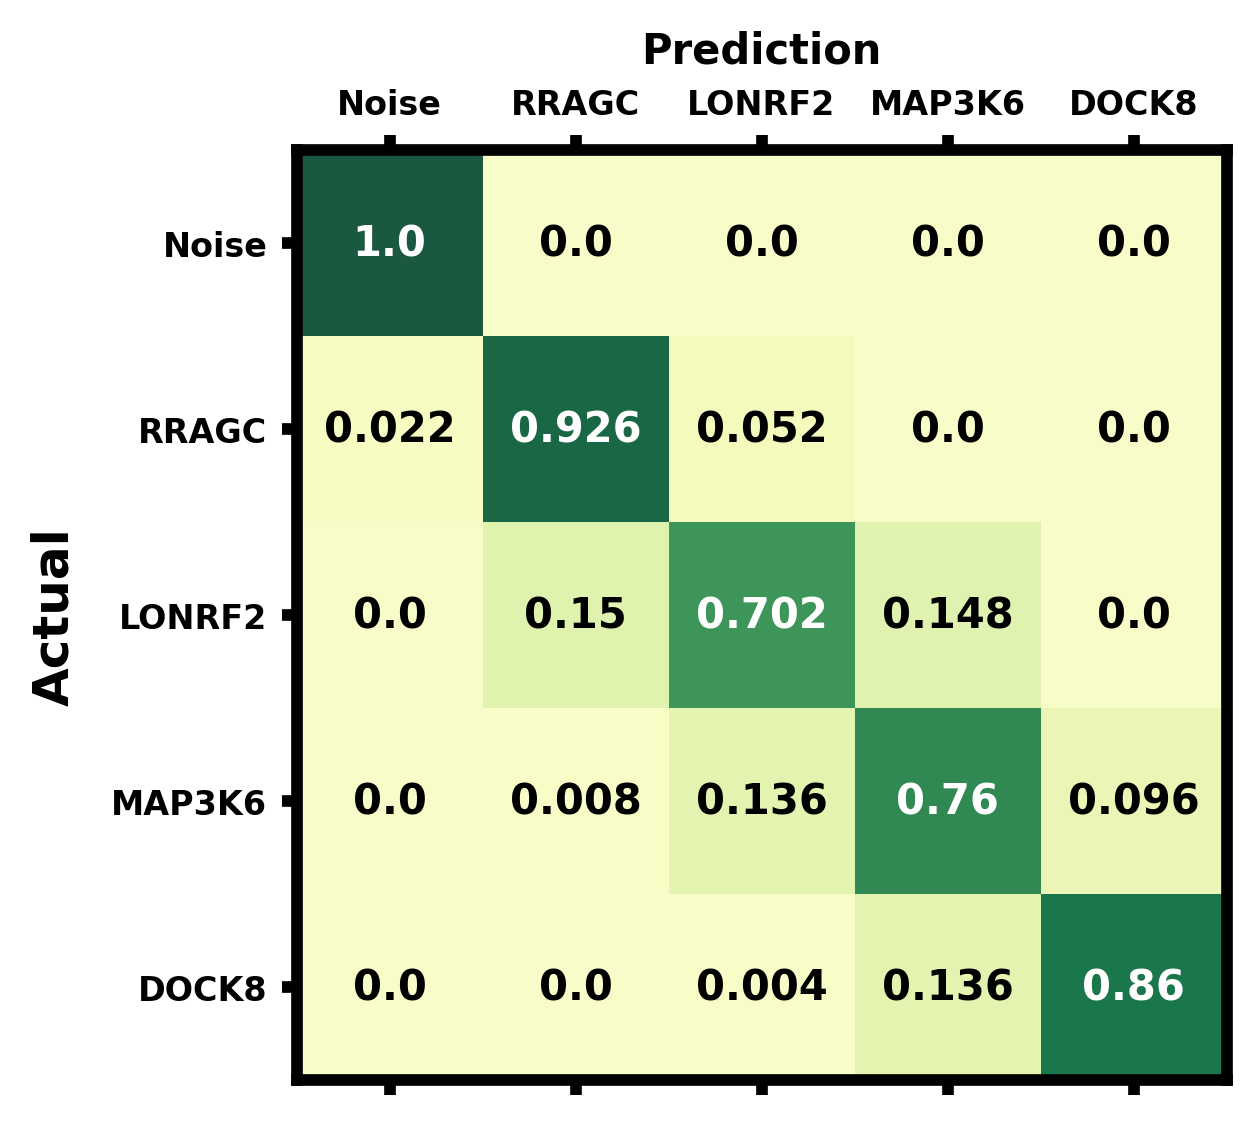

<Figure size 1800x1200 with 0 Axes>

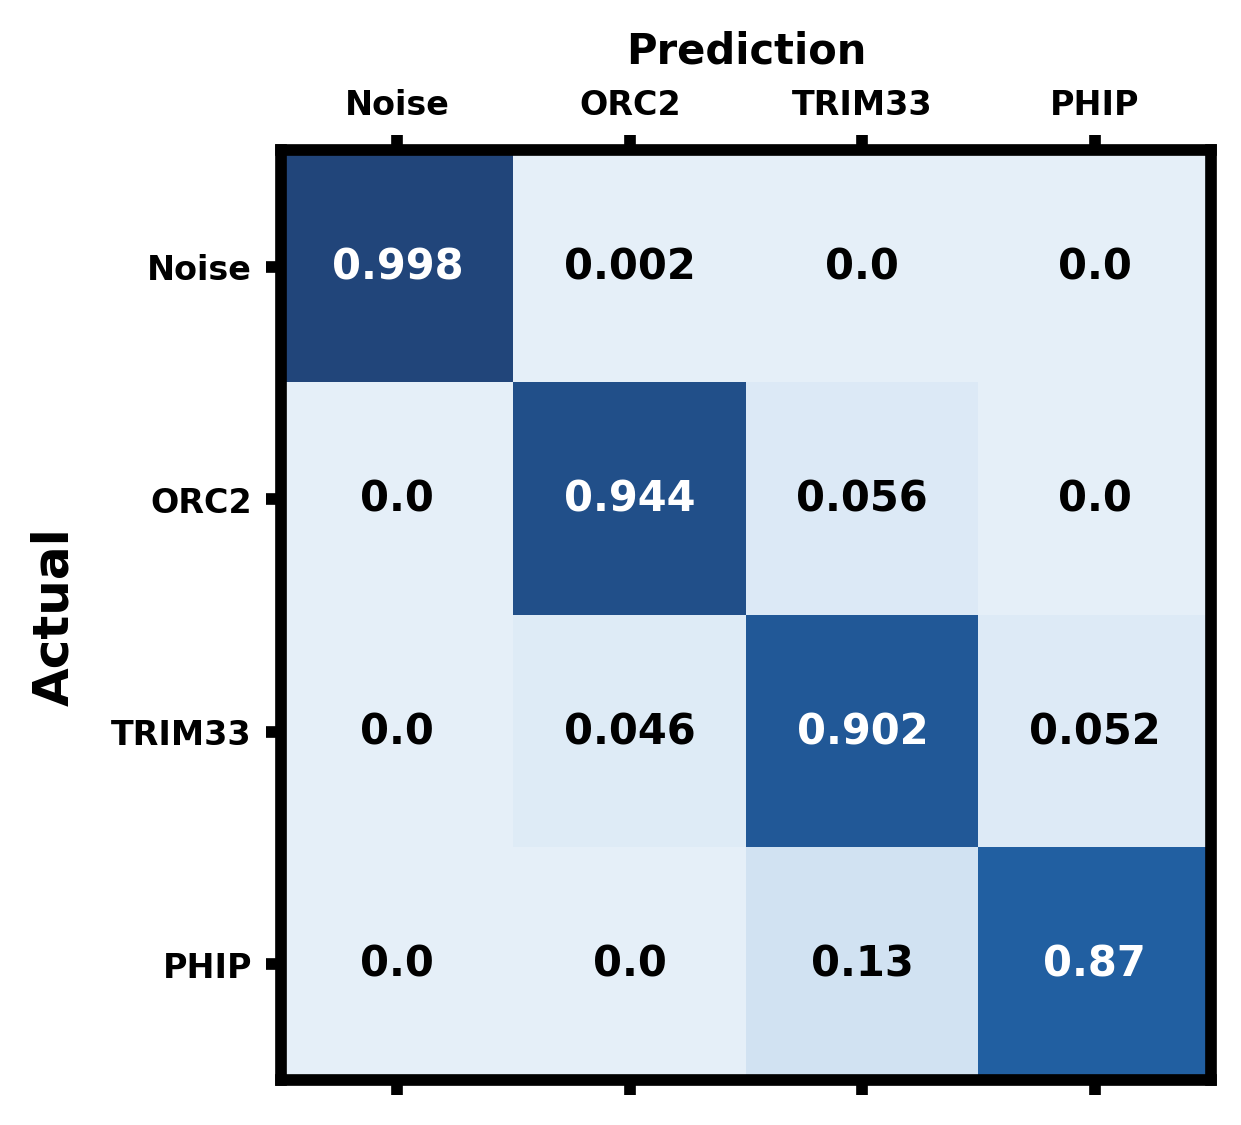

In [ ]:
#@title Confusion mat
plt.figure(dpi=300)
cmap = plt.get_cmap('YlGn')
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(cmap, 0.1, 1)
my_cmap = new_cmap(np.arange(cmap.N))
my_cmap[:, -1] = .9
my_cmap = ListedColormap(my_cmap)


gtl = g_true_labels_50+1
gpl = g_labels_predicted_50+1
gtl[gtl == 5] = 0
gpl[gpl == 5] = 0

btl = b_true_labels_50+1
bpl = b_labels_predicted_50+1
btl[btl == 4] = 0
bpl[bpl == 4] = 0

g_mat = confusion_matrix(gtl, gpl)
g_mat = g_mat / g_mat.astype(np.float).sum(axis=1)

b_mat = confusion_matrix(btl, bpl)
b_mat = b_mat / b_mat.astype(np.float).sum(axis=1)
plt.matshow(g_mat, cmap =my_cmap,)
for i in range(5):
  for j in range(5):
    if i != j:
      plt.text(j,i, str(g_mat[i,j]),
                horizontalalignment='center',
                verticalalignment='center',
                size=10)   
    else:
      plt.text(j,i, str(g_mat[i,j]),
                horizontalalignment='center',
                verticalalignment='center',
                size=10, color='w')     

plt.gca().set_xticklabels(['','Noise','RRAGC', 'LONRF2','MAP3K6','DOCK8'], fontsize=8)
plt.gca().set_yticklabels(['','Noise','RRAGC', 'LONRF2','MAP3K6','DOCK8',], fontsize=8)
plt.title('Prediction'); plt.ylabel('Actual')
###########################################
plt.savefig('conf_G.svg')

cmap = plt.get_cmap('Blues')
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(cmap, 0.1, 1)
my_cmap = new_cmap(np.arange(cmap.N))
my_cmap[:, -1] = .9
my_cmap = ListedColormap(my_cmap)


plt.figure(dpi=300)
plt.matshow(b_mat, cmap =my_cmap,)

for i in range(4):
  for j in range(4):
    if i != j:
      plt.text(j,i, str(b_mat[i,j]),
                horizontalalignment='center',
                verticalalignment='center',
                size=10)   
    else:
      plt.text(j,i, str(b_mat[i,j]),
                horizontalalignment='center',
                verticalalignment='center',
                size=10, color='w')  
      
plt.gca().set_xticklabels(['','Noise','ORC2','TRIM33','PHIP',], fontsize=8)
plt.gca().set_yticklabels(['','Noise','ORC2','TRIM33','PHIP',], fontsize=8)
plt.title('Prediction'); plt.ylabel('Actual')
plt.savefig('conf_B.svg')

# Load in test video and classify

In [ ]:
data_file = '/content/drive/MyDrive/multiplexing_7_cell0.csv.csv'
simulated_cell_dataframe = pandas.read_csv(data_file)

shape = (70,1000)

int_g_cell1 = simulated_cell_dataframe['green_int_mean'].values.reshape(shape)[3*10:,:]
int_b_cell1 = simulated_cell_dataframe['blue_int_mean'].values.reshape(shape)[:30,:]

int_g_bg_cell1 = simulated_cell_dataframe['blue_int_mean'].values.reshape(shape)[3*10:,:]
int_b_bg_cell1 = simulated_cell_dataframe['green_int_mean'].values.reshape(shape)[:30,:]

labels_cell1 = simulated_cell_dataframe['Classification'].values.reshape(shape)

x_cell1 = simulated_cell_dataframe['x'].values.reshape(shape) 
y_cell1 = simulated_cell_dataframe['y'].values.reshape(shape)

def slice_arr(array, FR, Nframes,axis=1):
    total_time = FR*Nframes
    if total_time > 3000:
        print('WARNING: desired slicing regime is not possible, making as many frames as possible')
        return array[:,::FR]
    return array[:,::FR][:,:Nframes]

int_g_cell1_64 = slice_arr(int_g_cell1,5,64)
scaler = MinMaxScaler()
scaler.fit(int_g_g)
int_g_cell1_64_minmax = scaler.transform(int_g_cell1_64)


int_b_cell1_64 = slice_arr(int_b_cell1,5,64)
scaler = MinMaxScaler()
scaler.fit(int_b_g)
int_b_cell1_64_minmax = scaler.fit_transform(int_b_cell1_64)



#predicted_labels_cell1 = cae.predict(int_g_cell1_64_minmax)
#predicted_labels_cell1_proba = cae.predict_proba(int_g_cell1_64_minmax)


Text(0.5, 1.0, 'Blue Channel Intensity Means')

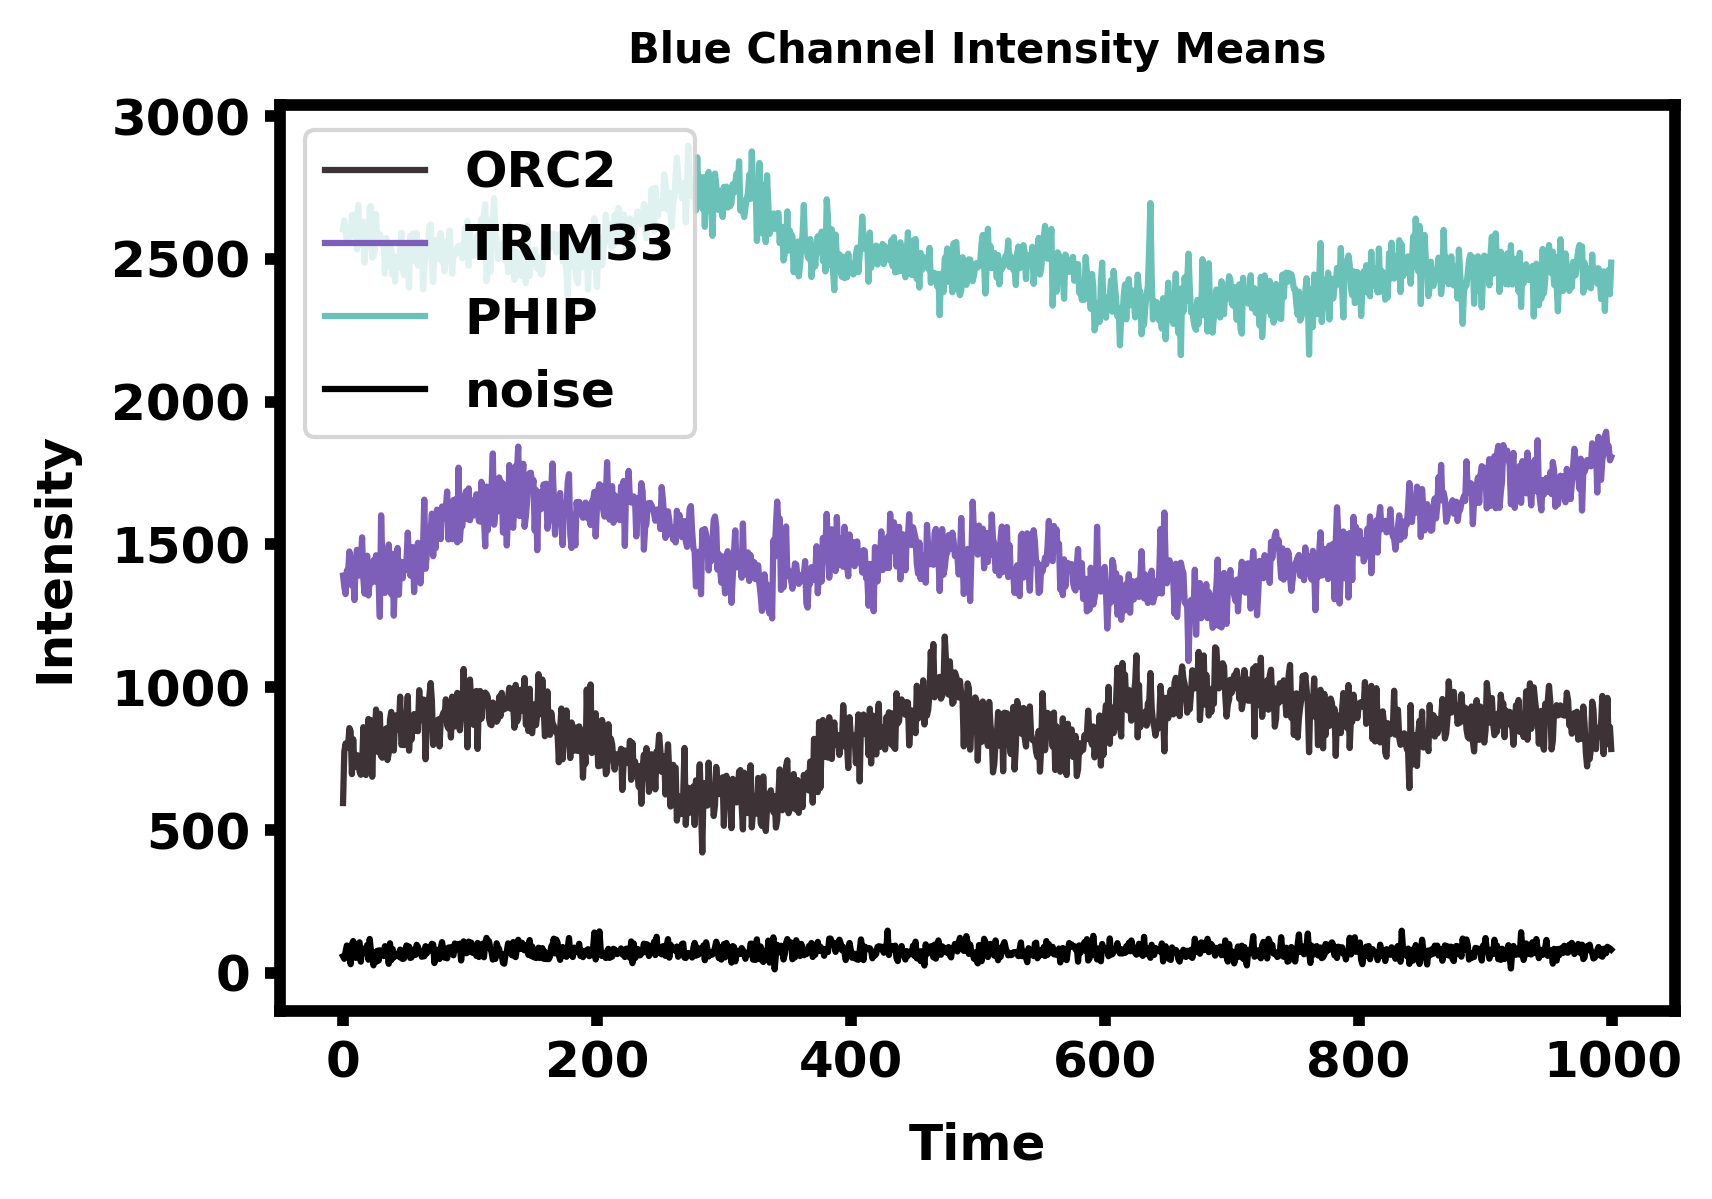

In [ ]:

c = ['#3D3337', '#7D5EB8', '#6AC1B8', '#BD571F', '#35b779', '#90d743', '#fde725']
plt.plot(np.mean(int_b_cell1.T[:,:10],axis=1),color=c[0])
plt.plot(np.mean(int_b_cell1.T[:,10:20],axis=1),color=c[1])
plt.plot(np.mean(int_b_cell1.T[:,20:30],axis=1),color=c[2])
plt.plot(np.mean(int_b_bg_cell1.T[:],axis=1),color='k')
plt.legend(['ORC2','TRIM33','PHIP','noise'])
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Blue Channel Intensity Means')

Text(0.5, 1.0, 'Green Channel Intensity Means')

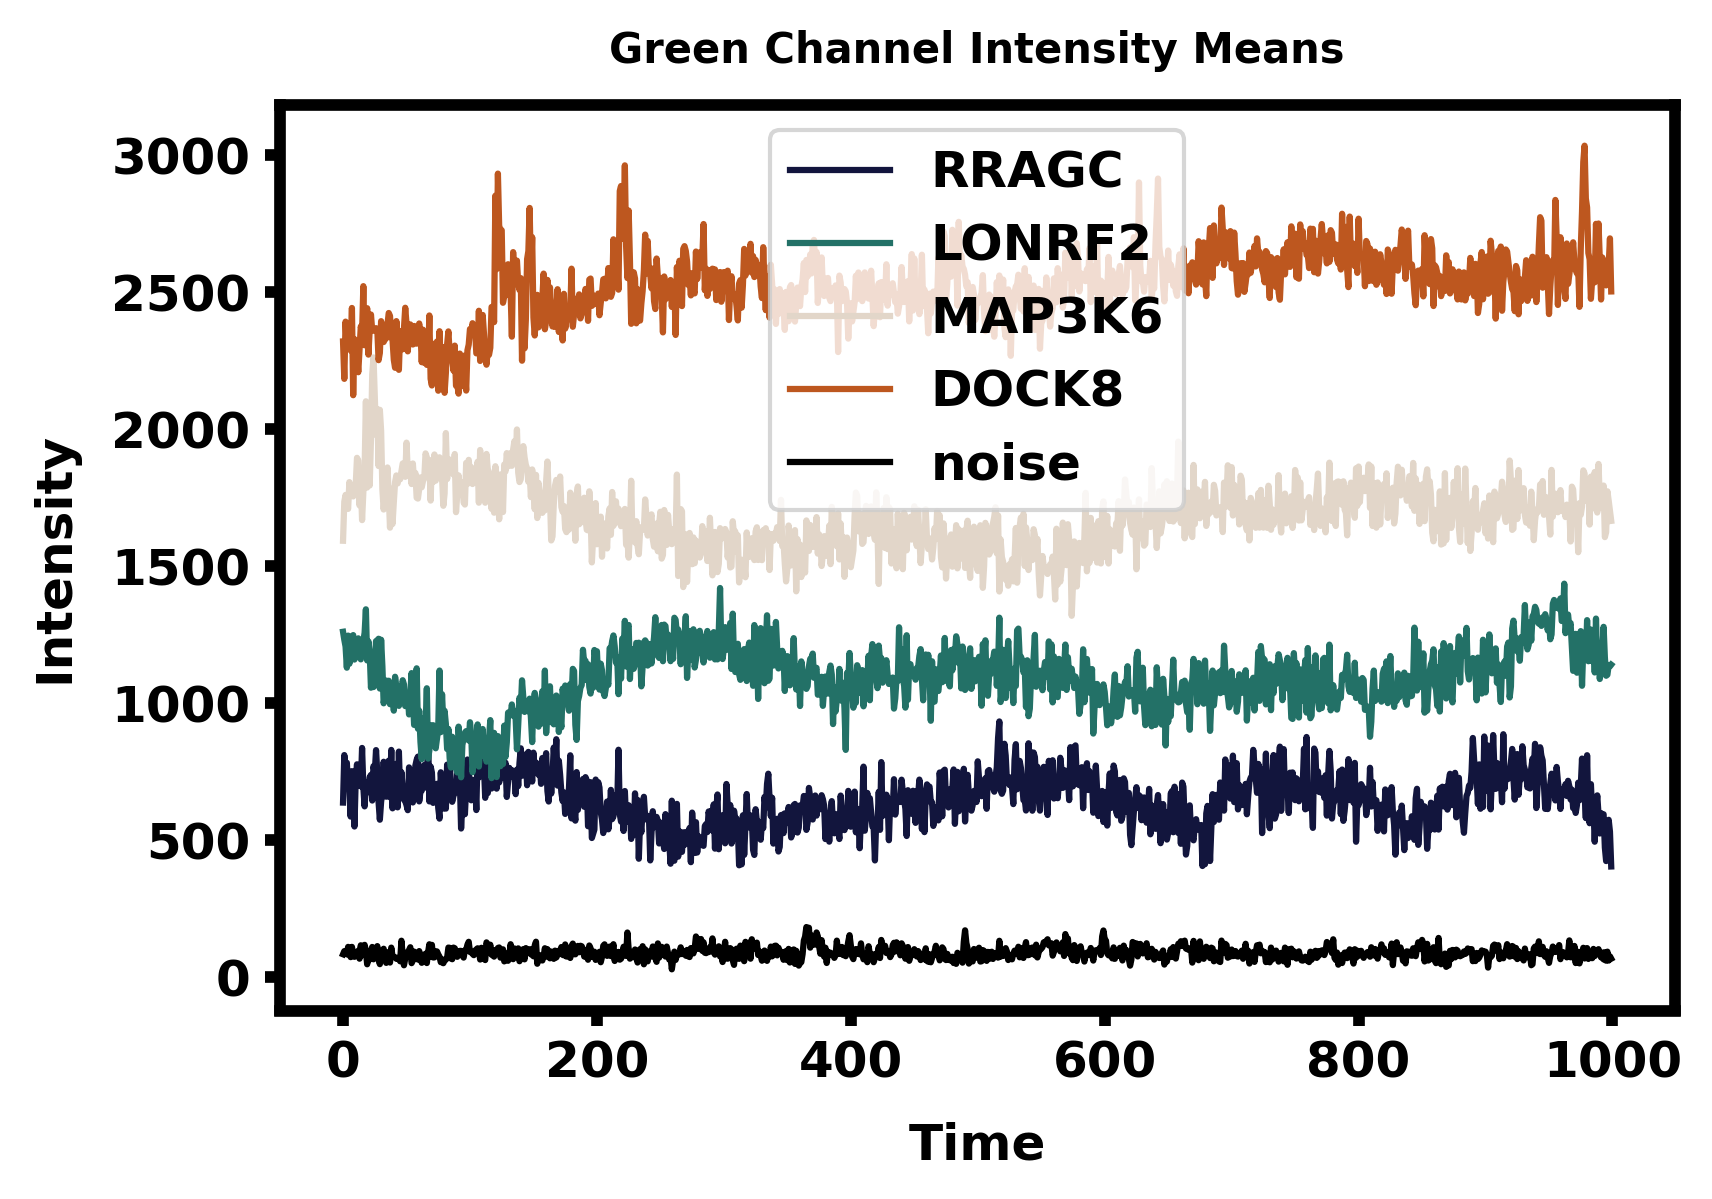

In [ ]:
c = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#35b779', '#90d743', '#fde725']
plt.plot(np.mean(int_g_cell1.T[:,:10],axis=1),color=c[0])
plt.plot(np.mean(int_g_cell1.T[:,10:20],axis=1),color=c[1])
plt.plot(np.mean(int_g_cell1.T[:,20:30],axis=1),color=c[2])
plt.plot(np.mean(int_g_cell1.T[:,30:40],axis=1),color=c[3])
plt.plot(np.mean(int_g_bg_cell1.T[:],axis=1),color='k')
plt.legend(['RRAGC','LONRF2','MAP3K6','DOCK8', 'noise'])
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Green Channel Intensity Means')


In [ ]:
mc = multiplexing_core()
labels = [0,]*10 + [1,]*10 + [2,]*10 + [3,]*10 
data, data_acc_g = mc.process_test_data(int_g_cell1_64, include_acc=True )

int_g_64_5 = np.concatenate((data, data_acc_g),axis=1)
int_g_64_5_labels = labels

int_g_64_5_array = np.array(int_g_64_5_labels).astype(int)
int_g_64_5_labels = np.zeros((int_g_64_5_array.size, int_g_64_5_array.max()+1))
int_g_64_5_labels[np.arange(int_g_64_5_array.size), int_g_64_5_array] = 1


labels = [0,]*10 + [1,]*10 + [2,]*10
data, data_acc_b = mc.process_test_data(int_b_cell1_64, include_acc=True )

int_b_64_5 = np.concatenate((data, data_acc_b),axis=1)
int_b_64_5_labels = labels

int_b_64_5_array = np.array(int_b_64_5_labels).astype(int)
int_b_64_5_labels = np.zeros((int_b_64_5_array.size, int_b_64_5_array.max()+1))
int_b_64_5_labels[np.arange(int_b_64_5_array.size), int_b_64_5_array] = 1


In [ ]:
scaler = MinMaxScaler()
scaler.fit(int_g_g)
int_g_cell1_64_transform = scaler.transform(int_g_cell1_64)  
int_g_64_5 = np.concatenate((np.expand_dims(int_g_cell1_64_transform,-1), data_acc_g),axis=1)


scaler = MinMaxScaler()
scaler.fit(int_b_g)
int_b_cell1_64_transform = scaler.transform(int_b_cell1_64)  
int_b_64_5 = np.concatenate((np.expand_dims(int_b_cell1_64_transform,-1), data_acc_b),axis=1)


g_labels_predicted = np.argmax((green_model.predict(int_g_64_5) > .5).astype(int),axis=1)
b_labels_predicted = np.argmax((blue_model.predict(int_b_64_5) > .5).astype(int),axis=1)

g_predict = green_model.predict(int_g_64_5)
b_predict = blue_model.predict(int_b_64_5)

g_labels_predicted = np.argmax((green_model.predict(int_g_64_5) > .5).astype(int),axis=1)
b_labels_predicted = np.argmax((blue_model.predict(int_b_64_5) > .5).astype(int),axis=1)

g_predict = green_model.predict(int_g_64_5)
b_predict = blue_model.predict(int_b_64_5)

g_confidence = []
b_confidence = []
i = 0
for label in g_labels_predicted:
  g_confidence.append(g_predict[i,label])
  i+=1
i = 0
for label in b_labels_predicted:
  b_confidence.append(b_predict[i,label])
  i+=1
  
predicted_labels_blue = b_labels_predicted
predicted_labels_green = g_labels_predicted

Text(0.5, 1.0, 'Green Channel Intensity Trajectories')

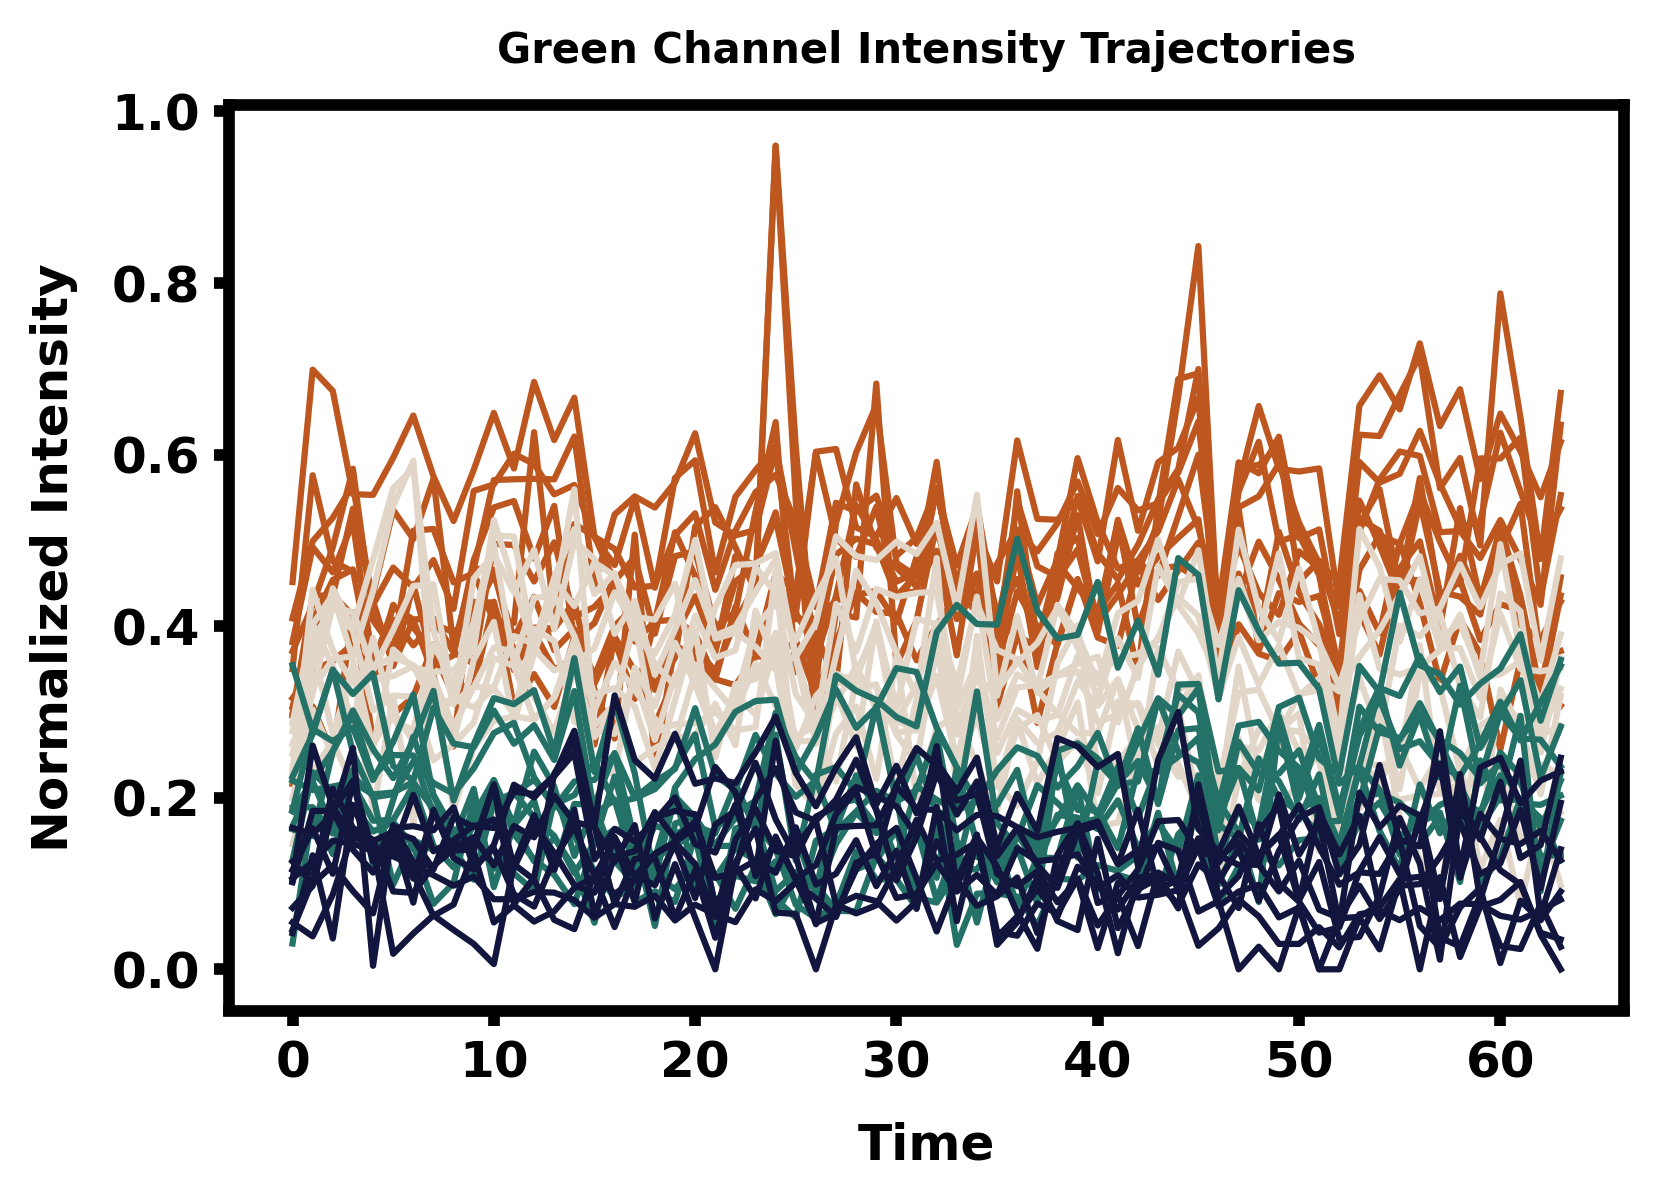

In [ ]:
c = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#35b779', '#90d743', '#fde725']
plt.plot(int_g_cell1_64_transform.T[:,30:40],color=c[3])
plt.plot(int_g_cell1_64_transform.T[:,20:30],color=c[2])
plt.plot(int_g_cell1_64_transform.T[:,10:20],color=c[1])
plt.plot(int_g_cell1_64_transform.T[:,0:10],color=c[0])

#plt.plot(int_g_bg_cell1[:],color='k')
#plt.legend(['RRAGC','LONRF2','MAP3K6','DOCK8', 'noise'])
plt.xlabel('Time')
plt.ylabel('Normalized Intensity')
plt.title('Green Channel Intensity Trajectories')


Text(0.5, 1.0, 'Green Channel Intensity Trajectories')

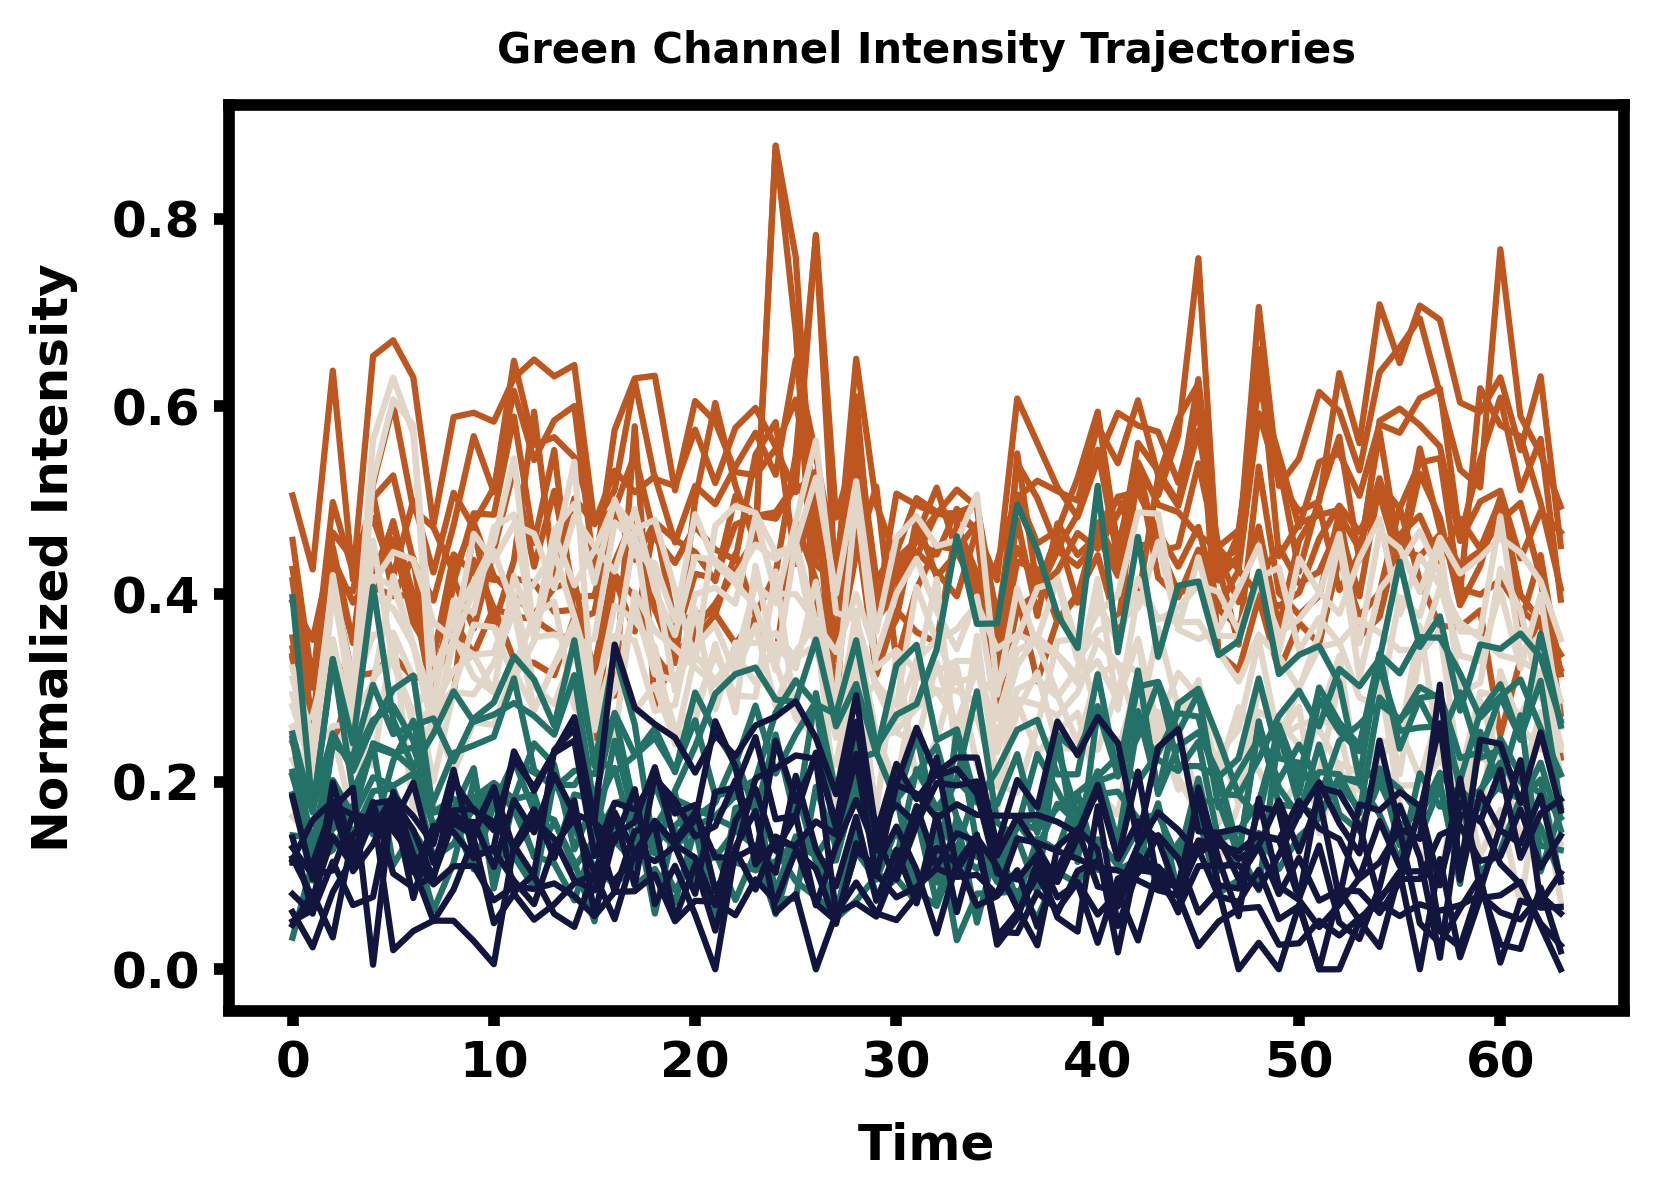

In [ ]:
c = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#35b779', '#90d743', '#fde725']
plt.plot(scaler.transform(int_g_cell1[:,::5][:,:64]).T[:,30:40],color=c[3])
plt.plot(scaler.transform(int_g_cell1[:,::5][:,:64]).T[:,20:30],color=c[2])
plt.plot(scaler.transform(int_g_cell1[:,::5][:,:64]).T[:,10:20],color=c[1])
plt.plot(scaler.transform(int_g_cell1[:,::5][:,:64]).T[:,0:10],color=c[0])

#plt.plot(int_g_bg_cell1[:],color='k')
#plt.legend(['RRAGC','LONRF2','MAP3K6','DOCK8', 'noise'])
plt.xlabel('Time')
plt.ylabel('Normalized Intensity')
plt.title('Green Channel Intensity Trajectories')


Text(0.5, 1.0, 'Green Channel Intensity Trajectories')

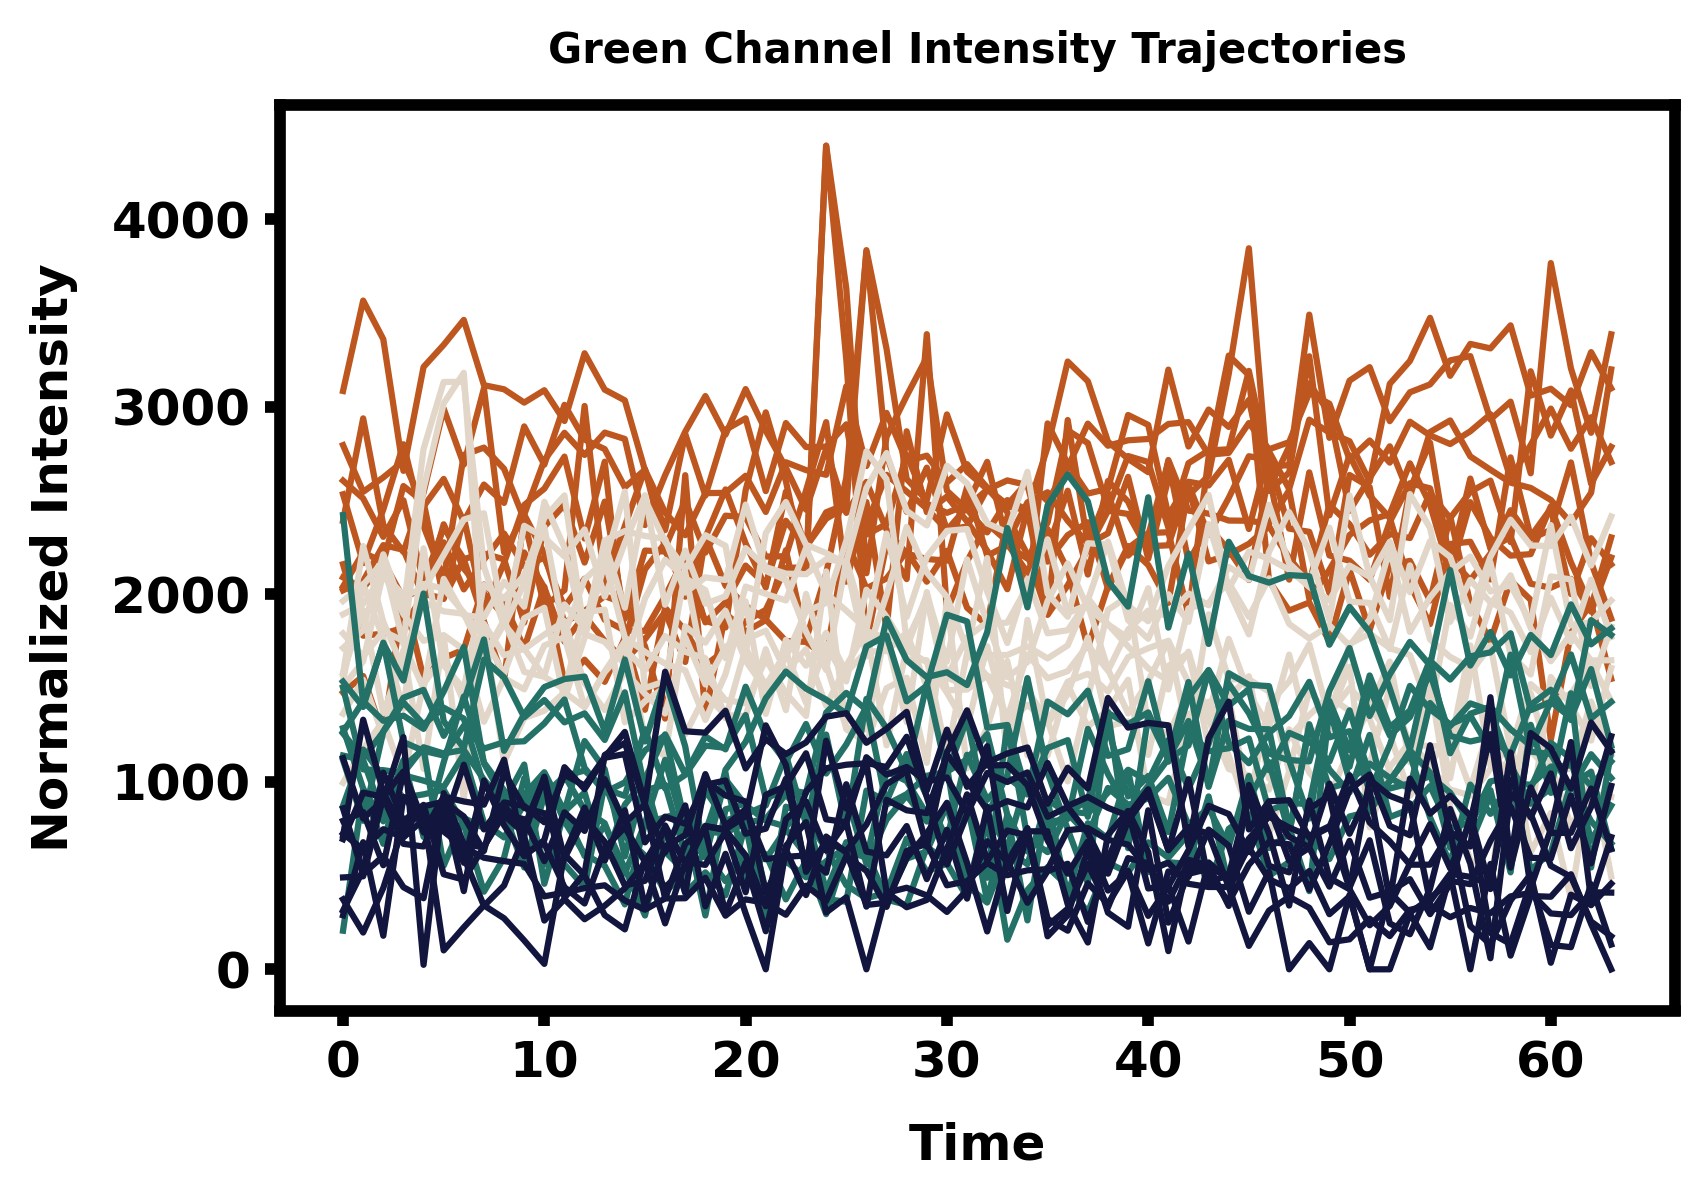

In [ ]:
c = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#35b779', '#90d743', '#fde725']
plt.plot(int_g_cell1[:,::5][:,:64].T[:,30:40],color=c[3])
plt.plot(int_g_cell1[:,::5][:,:64].T[:,20:30],color=c[2])
plt.plot(int_g_cell1[:,::5][:,:64].T[:,10:20],color=c[1])
plt.plot(int_g_cell1[:,::5][:,:64].T[:,0:10],color=c[0])

#plt.plot(int_g_bg_cell1[:],color='k')
#plt.legend(['RRAGC','LONRF2','MAP3K6','DOCK8', 'noise'])
plt.xlabel('Time')
plt.ylabel('Normalized Intensity')
plt.title('Green Channel Intensity Trajectories')


Text(0.5, 1.0, 'Blue Channel Intensity Trajectories')

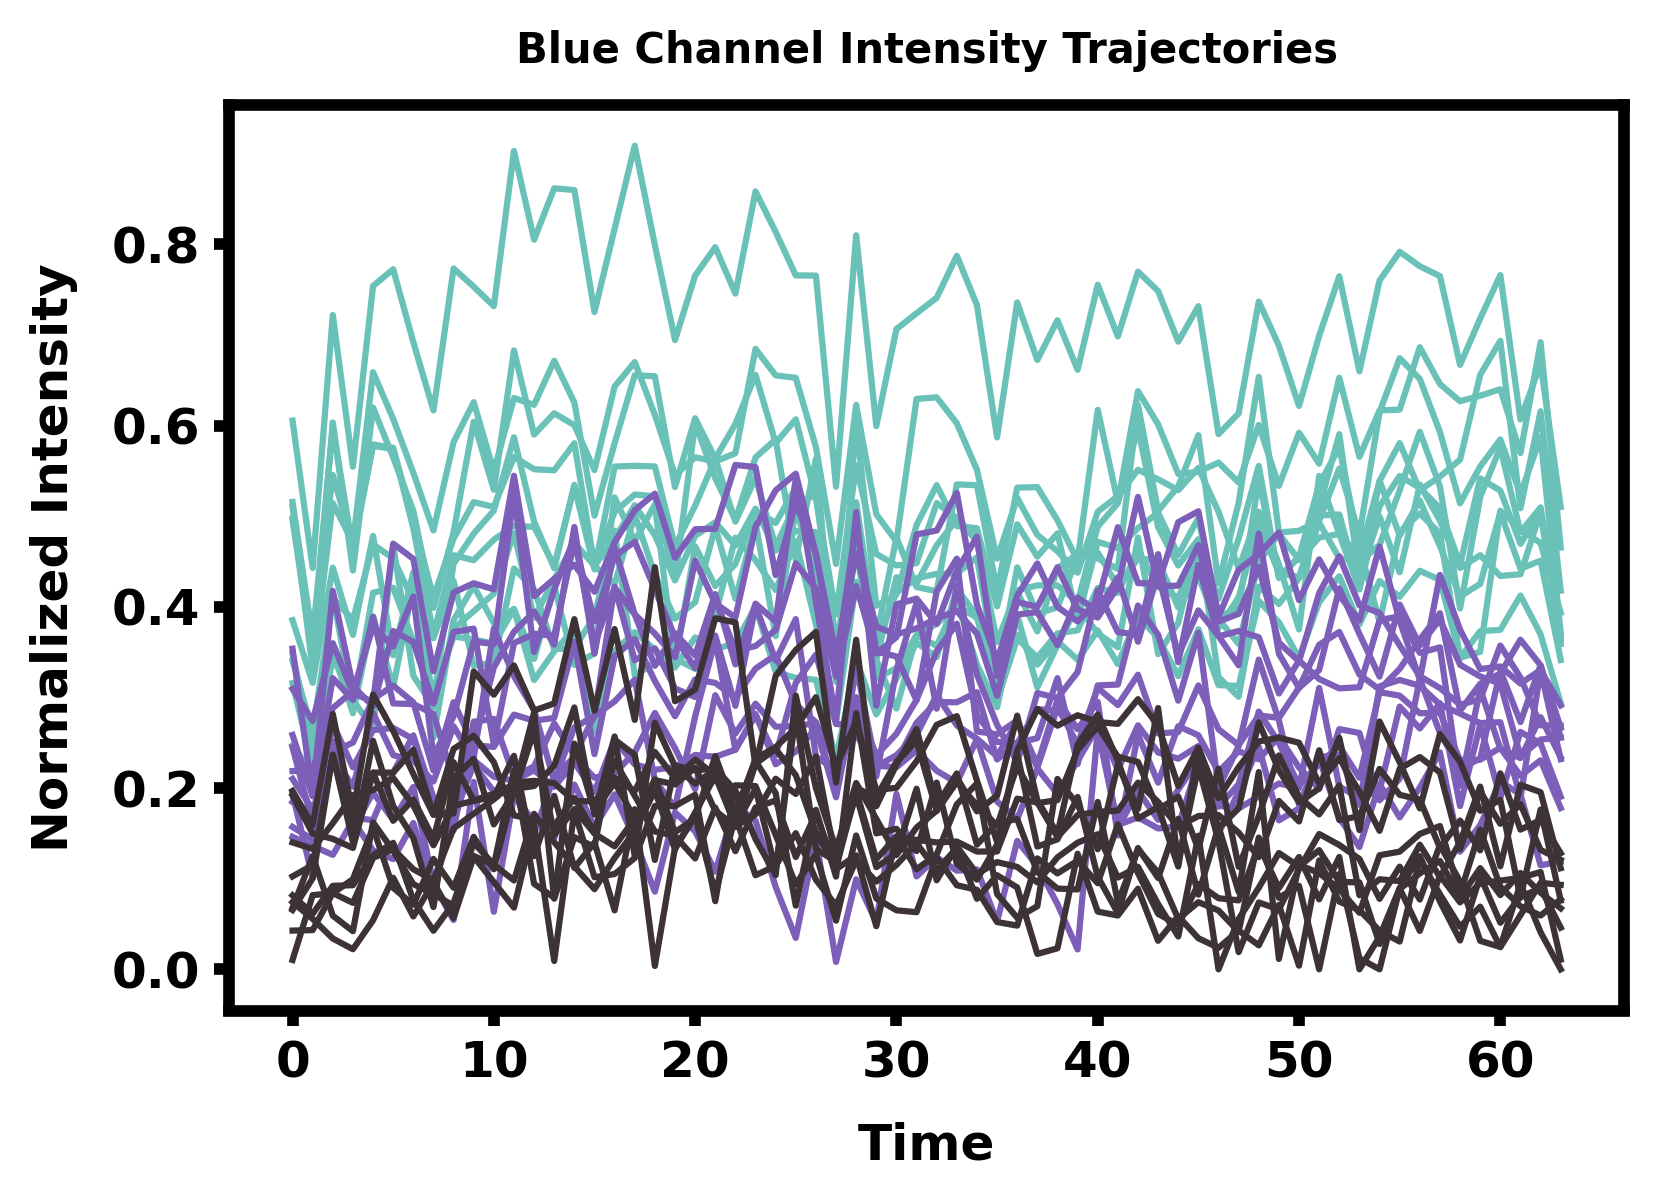

In [ ]:
c = ['#3D3337', '#7D5EB8', '#6AC1B8', '#BD571F', '#35b779', '#90d743', '#fde725']

plt.plot(int_b_cell1_64_transform.T[:,20:30],color=c[2])
plt.plot(int_b_cell1_64_transform.T[:,10:20],color=c[1])
plt.plot(int_b_cell1_64_transform.T[:,0:10],color=c[0])

plt.xlabel('Time')
plt.ylabel('Normalized Intensity')
plt.title('Blue Channel Intensity Trajectories')

In [ ]:
#@title Load Video and normalize
val_video = io.imread('/content/drive/MyDrive/multiplexing_7_1.tif')
val_video.shape

def quantile_norm(movie, q ):
   max_val = np.quantile(movie, q)
   min_val = np.quantile(movie, .005)
   print(min_val)
   norm_movie = (movie - min_val)/(max_val - min_val)
   norm_movie[norm_movie > 1] = 1
   norm_movie[norm_movie < 0] = 0
   return norm_movie

maxquant = .99
green_vid = quantile_norm(val_video[:,:,:,1], maxquant)
blue_vid = quantile_norm(val_video[:,:,:,2], maxquant)

(1000, 512, 512, 3)

In [ ]:
#@title Slider Visualization

labels_cell1 = [[0]*10,[1]*10,[2]*10,[3]*10,]
labels_cell1 = [item for sublist in labels_cell1 for item in sublist]

predicted_labels_cell1 = predicted_labels_green.tolist()

def plot_frame_labeled(frame):
  if len(val_video) < 100:
    frames = [0,49,99,149,199]
  else:
    frames = list(range(0,3000))
  
  fig, axes = plt.subplots(1,2,dpi=120, tight_layout=True)

  vid_frame = green_vid[frame,:,:]
  axes[0].imshow(vid_frame,cmap=cm.Greens_r)
  c = ['#440154', '#443983', '#31688e', '#21918c', '#35b779', '#90d743', '#fde725']

  colors = [c[int(predicted_labels_cell1[i])] for i in range(0,len(predicted_labels_cell1))]

  for i in range(len(colors)):
    if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
      colors[i] = 'r'

    #if np.max(predicted_labels_cell1_proba[i,:]) < .75:
      #colors[i] = 'm'


  axes[0].scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=colors, s=15)
  axes[0].set_title('Predicted labels')

  axes[1].imshow(vid_frame,cmap=cm.Greens_r)

  colors = [c[int(labels_cell1[i])] for i in range(0,len(labels_cell1))]

  
  axes[1].scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=colors, s=15)
  axes[1].set_title('True labels')
  percent_correct = np.sum(labels_cell1 == np.array(predicted_labels_cell1))/len(np.array(predicted_labels_cell1))
  axes[0].text(10,40,'Acc %1.4f '%percent_correct, color='white')

f = lambda frame: plot_frame_labeled(frame)
interact(f, frame=widgets.IntSlider(min=0, max=val_video.shape[0]-1, step=1, value=10));




labels_cell1 = [ [0,]*10, [1]*10, [2]*10, ]
labels_cell1 = [item for sublist in labels_cell1 for item in sublist]

predicted_labels_cell1 = predicted_labels_blue.tolist() 

def plot_frame_labeled(frame):
  if len(val_video) < 100:
    frames = [0,49,99,149,199]
  else:
    frames = list(range(0,3000))
  
  fig, axes = plt.subplots(1,2,dpi=120)

  vid_frame = blue_vid[frame,:,:]
  axes[0].imshow(vid_frame,cmap=cm.Blues_r)
  c = ['#440154', '#443983', '#31688e', '#21918c', '#35b779', '#90d743', '#fde725']

  colors = [c[int(predicted_labels_cell1[i])] for i in range(0,len(predicted_labels_cell1))]

  for i in range(len(colors)):
    if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
      colors[i] = 'r'

    #if np.max(predicted_labels_cell1_proba[i,:]) < .75:
      #colors[i] = 'm'

  axes[0].scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=colors, s=15)
  axes[0].set_title('Predicted labels')

  axes[1].imshow(vid_frame,cmap=cm.Blues_r)

  colors = [c[int(labels_cell1[i])] for i in range(0,len(labels_cell1))]

  axes[1].scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=colors, s=15)
  axes[1].set_title('True labels')
  percent_correct = np.sum(labels_cell1 == np.array(predicted_labels_cell1))/len(np.array(predicted_labels_cell1))
  axes[0].text(10,40,'Acc %1.4f '%percent_correct, color='white')

f = lambda frame: plot_frame_labeled(frame)
interact(f, frame=widgets.IntSlider(min=0, max=val_video.shape[0]-1, step=1, value=10));

interactive(children=(IntSlider(value=10, description='frame', max=999), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=10, description='frame', max=999), Output()), _dom_classes=('widget-inte…

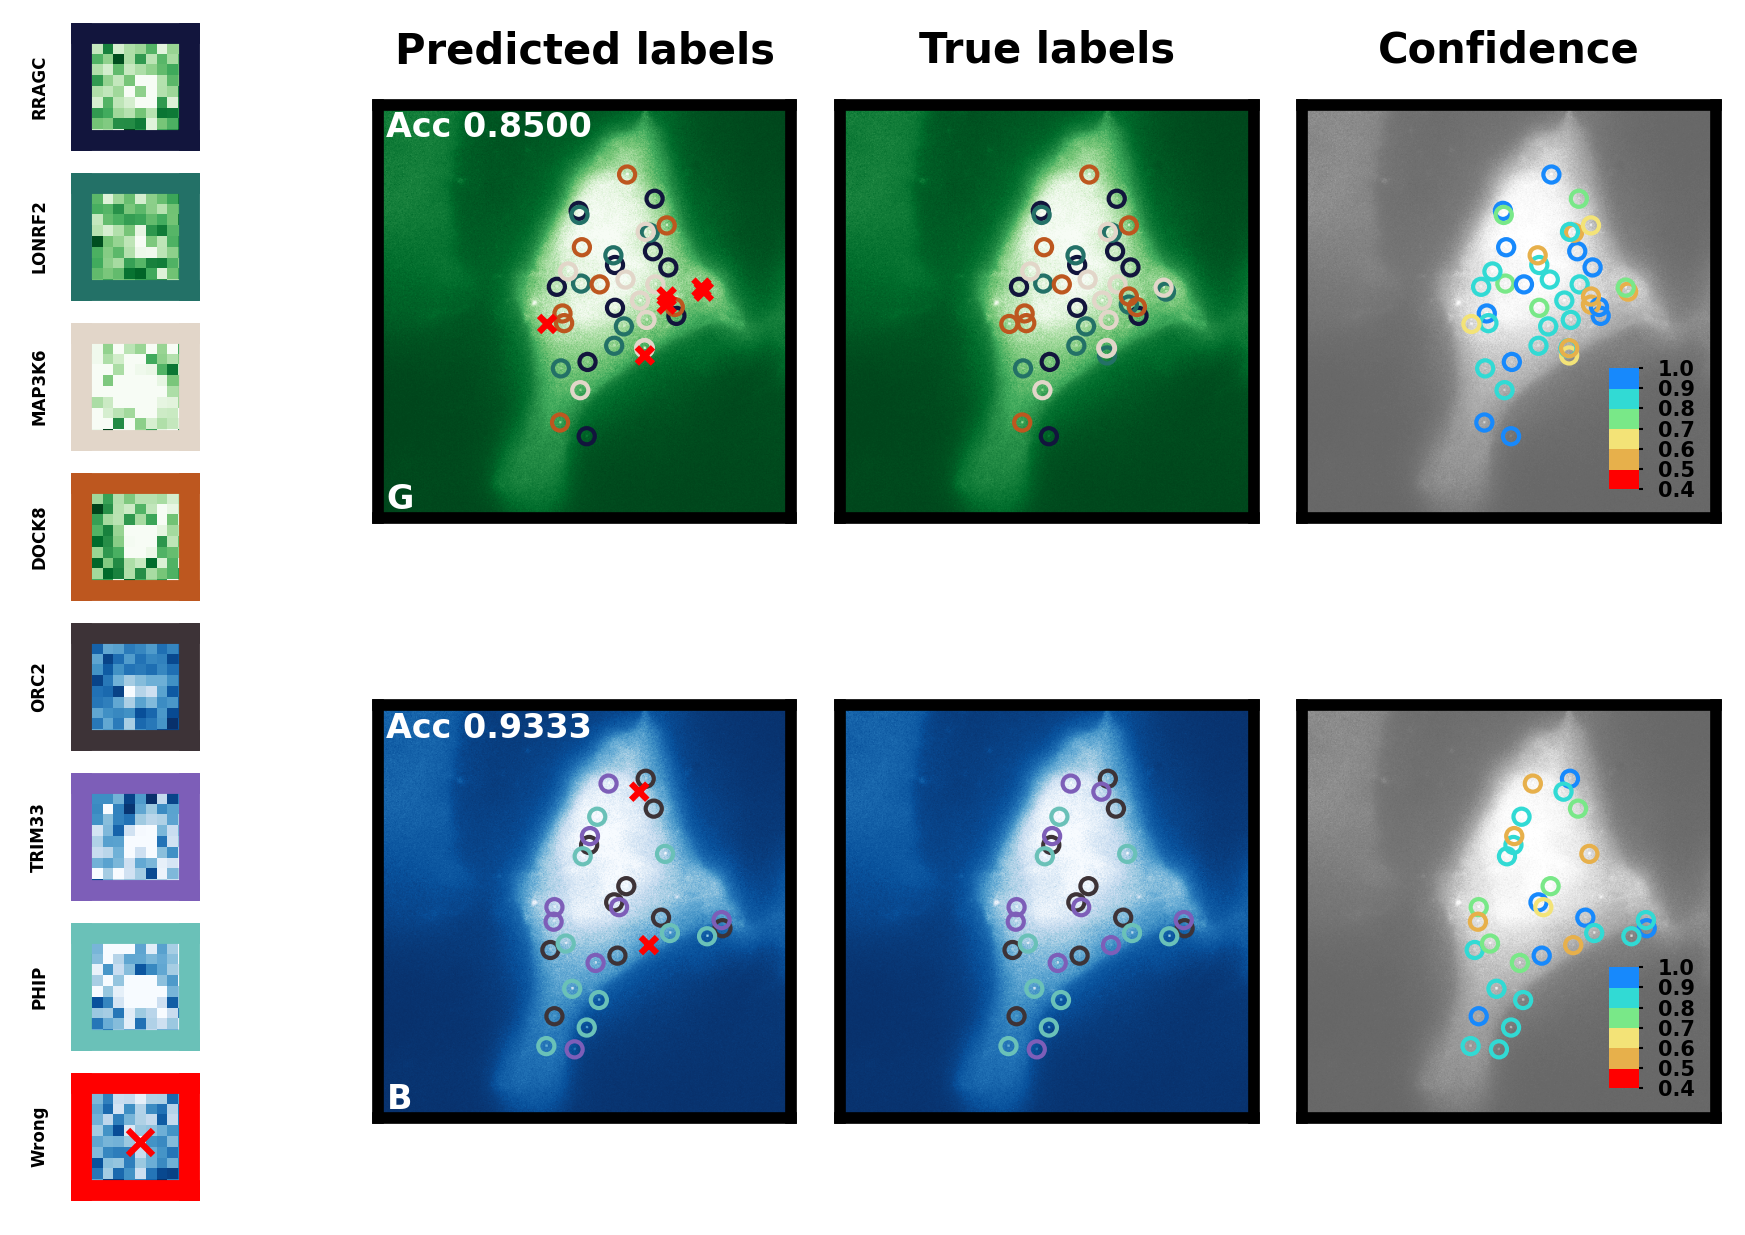

In [ ]:
#@title Single Frame
frame = 0 #@param {type:"integer"}


def inside_subplot(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  
    subax = fig.add_axes([x,y,width,height],facecolor='white') 
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


frame = 30
fig = plt.figure( dpi=300, constrained_layout=True)
gs = GridSpec(8,4,figure=fig )

gp_ax =  fig.add_subplot(gs[ 0:4, 1])
gl_ax =  fig.add_subplot(gs[ 0:4, 2])
gc_ax =  fig.add_subplot(gs[0:4, 3])

bp_ax =  fig.add_subplot(gs[ 4: , 1])
bl_ax =  fig.add_subplot(gs[ 4: , 2])
bc_ax =  fig.add_subplot(gs[ 4: , 3])

rragc_ax = fig.add_subplot(gs[0,0])
lonrf2_ax = fig.add_subplot(gs[1,0])
map3k6_ax = fig.add_subplot(gs[2,0])
dock8_ax = fig.add_subplot(gs[3,0])

orc2_ax = fig.add_subplot(gs[4,0])
trim33_ax = fig.add_subplot(gs[5,0])
phip_ax = fig.add_subplot(gs[6,0])
wrong_ax = fig.add_subplot(gs[7,0])



conf_cmap  = (mpl.colors.ListedColormap(['r','r','r','r','r','#E7B04B', '#F3E377', '#79E888', '#31DAD4','#1789FC']))
predicted_labels_cell1 = predicted_labels_green.tolist()
vid_frame = green_vid[frame,:,:]
gp_ax.imshow(vid_frame,cmap=cm.Greens_r)
c = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#35b779', '#90d743', '#fde725']

labels_cell1 = [[0]*10,[1]*10,[2]*10,[3]*10,]
labels_cell1 = [item for sublist in labels_cell1 for item in sublist]
colors = [c[int(predicted_labels_cell1[i])] for i in range(0,len(predicted_labels_cell1))]
blank_colors = [[0,0,0,0],]*len(colors)
for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    colors[i] = [0,0,0,0]

for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    blank_colors[i] = 'r'

  #if np.max(predicted_labels_cell1_proba[i,:]) < .75:
    #colors[i] = 'm'


gp_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=colors, s=15)
gp_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors=blank_colors, edgecolors=blank_colors, s=15,  marker='x')
gp_ax.set_title('Predicted labels')

gl_ax.imshow(vid_frame,cmap=cm.Greens_r)

colors = [c[int(labels_cell1[i])] for i in range(0,len(labels_cell1))]


gl_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=colors, s=15)
gl_ax.set_title('True labels')
percent_correct = np.sum(labels_cell1 == np.array(predicted_labels_cell1))/len(np.array(predicted_labels_cell1))
gp_ax.text(10,40,'Acc %1.4f '%percent_correct, color='white', fontsize=8)
gp_ax.text(10,500,'G', color='white', fontsize=8)

gc_ax.imshow(vid_frame,cmap=cm.Greys_r,  alpha=.6)
gc_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=conf_cmap(g_confidence), s=15)
gc_ax.set_title('Confidence')

gp_ax.axes.xaxis.set_visible(False)
gp_ax.axes.yaxis.set_visible(False)
gl_ax.axes.xaxis.set_visible(False)
gl_ax.axes.yaxis.set_visible(False)
gc_ax.axes.xaxis.set_visible(False)
gc_ax.axes.yaxis.set_visible(False)
gp_ax.set_ylabel('Green Channel')
labels_cell1 = [ [0,]*10, [1]*10, [2]*10, ]
labels_cell1 = [item for sublist in labels_cell1 for item in sublist]
predicted_labels_cell1 = predicted_labels_blue.tolist()
vid_frame = blue_vid[frame,:,:]
bp_ax.imshow(vid_frame,cmap=cm.Blues_r)


cax = inside_subplot(gc_ax, [1.2,.15,.1,.4] )

cmap = (mpl.colors.ListedColormap(['r','r','r','r','r','#E7B04B', '#F3E377', '#79E888', '#31DAD4','#1789FC']))

bounds = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds[4:],
    spacing='uniform',
    orientation='vertical',
)
cax.set_ylim([.4,1])
cb.outline.set_linewidth(0)
cb.ax.tick_params(labelsize=5, width=.5, length=1)



##############################

c2 = ['#3D3337', '#7D5EB8', '#6AC1B8', '#BD571F', '#35b779', '#90d743', '#fde725']

colors = [c2[int(predicted_labels_cell1[i])] for i in range(0,len(predicted_labels_cell1))]
blank_colors = [[0,0,0,0],]*len(colors)
for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    colors[i] = [0,0,0,0]

for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    blank_colors[i] = 'r'

  #if np.max(predicted_labels_cell1_proba[i,:]) < .75:
    #colors[i] = 'm'


bp_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=colors, s=15)
bp_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors=blank_colors, edgecolors=blank_colors, s=15, marker='x')
bp_ax.set_ylabel('Blue Channel')

bl_ax.imshow(vid_frame,cmap=cm.Blues_r)

colors = [c2[int(labels_cell1[i])] for i in range(0,len(labels_cell1))]


bl_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=colors, s=15)
#bl_ax.set_title('True labels')
percent_correct = np.sum(labels_cell1 == np.array(predicted_labels_cell1))/len(np.array(predicted_labels_cell1))
bp_ax.text(10,40,'Acc %1.4f '%percent_correct, color='white', fontsize=8)

bp_ax.text(10,500,'B', color='white', fontsize=8)

bc_ax.imshow(vid_frame,cmap=cm.Greys_r, alpha=.6)
a = bc_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=conf_cmap(g_confidence), s=15)
#bc_ax.set_title('Confidence')

bp_ax.axes.xaxis.set_visible(False)
bp_ax.axes.yaxis.set_visible(False)
bl_ax.axes.xaxis.set_visible(False)
bl_ax.axes.yaxis.set_visible(False)
bc_ax.axes.xaxis.set_visible(False)
bc_ax.axes.yaxis.set_visible(False)


cax = inside_subplot(bc_ax, [1.2,-.3,.1,.4] )

cmap = (mpl.colors.ListedColormap(['r','r','r','r','r','#E7B04B', '#F3E377', '#79E888', '#31DAD4','#1789FC']))

bounds = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds[4:],
    spacing='uniform',
    orientation='vertical',
)
cax.set_ylim([.4,1])
cb.outline.set_linewidth(0)
cb.ax.tick_params(labelsize=5, width=.5, length=1)


spots = [rragc_ax, lonrf2_ax, map3k6_ax, dock8_ax, orc2_ax, trim33_ax, phip_ax]
spot_inds = [30, 30+12, 30+22, 25+32, 3, 1+12, 1+22]
cc = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#3D3337', '#7D5EB8', '#6AC1B8']
labels = ['RRAGC', 'LONRF2','MAP3K6','DOCK8','ORC2','TRIM33','PHIP']
channels = [1,1,1,1,2,2,2]
def subplot_spot(tmpax, index, color, channel, label):
  if channel == 1:
    vid_frame = green_vid[frame,:,:]
  if channel == 2:
    vid_frame = blue_vid[frame,:,:]
  x,y = x_cell1[index,frame],y_cell1[index,frame]
  cmap = ['Reds_r','Greens_r','Blues_r'][channel]
  tmpax.imshow(vid_frame[y-5:y+5,x-5:x+5], cmap=cmap)
  tmpax.axes.xaxis.set_visible(False)
  tmpax.axes.set_yticks([])
  tmpax.set_ylabel(label, fontsize=4)
  for spine in tmpax.spines.values():
      spine.set_edgecolor(color)
      spine.set_linewidth(5)

[subplot_spot(spots[i], spot_inds[i], cc[i], channels[i], labels[i]) for i in range(7)]

subplot_spot(wrong_ax, 8,'r' ,2,'Wrong')
wrong_ax.scatter(5,5,color='r', marker='x')

#plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('multiplexing_7.svg')



629.0
629.0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1035: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


AxesImage(150,639.745;202.174x64.2553)


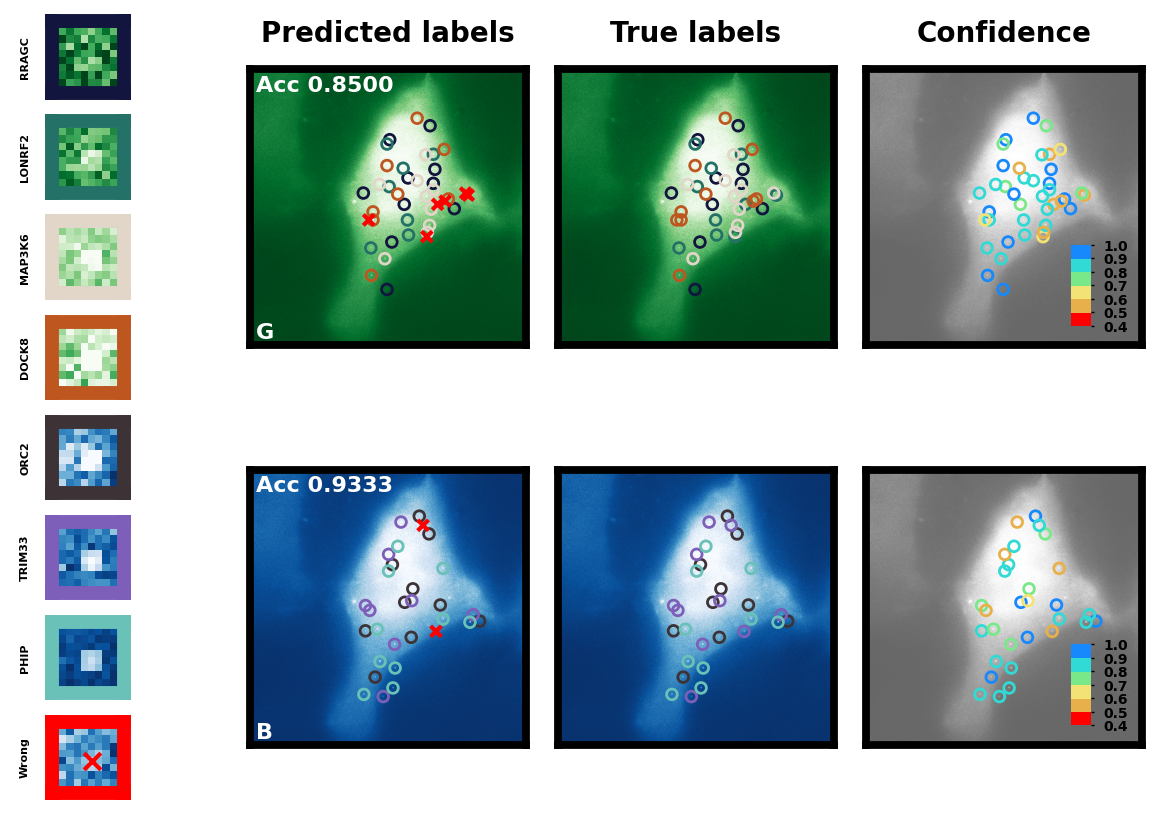

In [ ]:
#@title Make Video
def inside_subplot(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  
    subax = fig.add_axes([x,y,width,height],facecolor='white') 
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax



frame = 0
fig = plt.figure( dpi=200, constrained_layout=True)
gs = GridSpec(8,4,figure=fig )

gp_ax =  fig.add_subplot(gs[ 0:4, 1])
gl_ax =  fig.add_subplot(gs[ 0:4, 2])
gc_ax =  fig.add_subplot(gs[0:4, 3])

bp_ax =  fig.add_subplot(gs[ 4: , 1])
bl_ax =  fig.add_subplot(gs[ 4: , 2])
bc_ax =  fig.add_subplot(gs[ 4: , 3])

rragc_ax = fig.add_subplot(gs[0,0])
lonrf2_ax = fig.add_subplot(gs[1,0])
map3k6_ax = fig.add_subplot(gs[2,0])
dock8_ax = fig.add_subplot(gs[3,0])

orc2_ax = fig.add_subplot(gs[4,0])
trim33_ax = fig.add_subplot(gs[5,0])
phip_ax = fig.add_subplot(gs[6,0])
wrong_ax = fig.add_subplot(gs[7,0])



conf_cmap  = (mpl.colors.ListedColormap(['r','r','r','r','r','#E7B04B', '#F3E377', '#79E888', '#31DAD4','#1789FC']))
predicted_labels_cell1 = predicted_labels_green.tolist()


#vid_frame = cv2.normalize( val_video[frame,:,:,1], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)



gp_im = gp_ax.imshow(green_vid[0],cmap=cm.Greens_r)
c = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#35b779', '#90d743', '#fde725']

labels_cell1 = [[0]*10,[1]*10,[2]*10,[3]*10,]
labels_cell1 = [item for sublist in labels_cell1 for item in sublist]
colors = [c[int(predicted_labels_cell1[i])] for i in range(0,len(predicted_labels_cell1))]
blank_colors = [[0,0,0,0],]*len(colors)
for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    colors[i] = [0,0,0,0]

for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    blank_colors[i] = 'r'

  #if np.max(predicted_labels_cell1_proba[i,:]) < .75:
    #colors[i] = 'm'


gp_1_sc = gp_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=colors, s=15)
gp_2_sc = gp_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors=blank_colors, edgecolors=blank_colors, s=15,  marker='x')
gp_ax.set_title('Predicted labels')

gl_im =gl_ax.imshow(green_vid[0],cmap=cm.Greens_r)

colors = [c[int(labels_cell1[i])] for i in range(0,len(labels_cell1))]


gl_sc = gl_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=colors, s=15)
gl_ax.set_title('True labels')
percent_correct = np.sum(labels_cell1 == np.array(predicted_labels_cell1))/len(np.array(predicted_labels_cell1))
gp_ax.text(10,40,'Acc %1.4f '%percent_correct, color='white', fontsize=8)
gp_ax.text(10,500,'G', color='white', fontsize=8)

gc_im = gc_ax.imshow(green_vid[0],cmap=cm.Greys_r,  alpha=.6)
gc_sc = gc_ax.scatter(x_cell1[30:,frame],y_cell1[30:,frame],facecolors='none', edgecolors=conf_cmap(g_confidence), s=15)
gc_ax.set_title('Confidence')

gp_ax.axes.xaxis.set_visible(False)
gp_ax.axes.yaxis.set_visible(False)
gl_ax.axes.xaxis.set_visible(False)
gl_ax.axes.yaxis.set_visible(False)
gc_ax.axes.xaxis.set_visible(False)
gc_ax.axes.yaxis.set_visible(False)
gp_ax.set_ylabel('Green Channel')
labels_cell1 = [ [0,]*10, [1]*10, [2]*10, ]
labels_cell1 = [item for sublist in labels_cell1 for item in sublist]
predicted_labels_cell1 = predicted_labels_blue.tolist()

#vid_frame = cv2.normalize( val_video[frame,:,:,2], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)

bp_im = bp_ax.imshow(blue_vid[0],cmap=cm.Blues_r)


cax = inside_subplot(gc_ax, [1.2,.15,.1,.4] )

cmap = (mpl.colors.ListedColormap(['r','r','r','r','r','#E7B04B', '#F3E377', '#79E888', '#31DAD4','#1789FC']))

bounds = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds[4:],
    spacing='uniform',
    orientation='vertical',
)
cax.set_ylim([.4,1])
cb.outline.set_linewidth(0)
cb.ax.tick_params(labelsize=5, width=.5, length=1)



##############################

c2 = ['#3D3337', '#7D5EB8', '#6AC1B8', '#BD571F', '#35b779', '#90d743', '#fde725']

colors = [c2[int(predicted_labels_cell1[i])] for i in range(0,len(predicted_labels_cell1))]
blank_colors = [[0,0,0,0],]*len(colors)
for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    colors[i] = [0,0,0,0]

for i in range(len(colors)):
  if int(predicted_labels_cell1[i]) != int(labels_cell1[i]):
    blank_colors[i] = 'r'

  #if np.max(predicted_labels_cell1_proba[i,:]) < .75:
    #colors[i] = 'm'


bp_1_sc = bp_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=colors, s=15)
bp_2_sc = bp_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors=blank_colors, edgecolors=blank_colors, s=15, marker='x')
bp_ax.set_ylabel('Blue Channel')

bl_im = bl_ax.imshow(blue_vid[0],cmap=cm.Blues_r)

colors = [c2[int(labels_cell1[i])] for i in range(0,len(labels_cell1))]


bl_sc = bl_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=colors, s=15)
#bl_ax.set_title('True labels')
percent_correct = np.sum(labels_cell1 == np.array(predicted_labels_cell1))/len(np.array(predicted_labels_cell1))
bp_ax.text(10,40,'Acc %1.4f '%percent_correct, color='white', fontsize=8)

bp_ax.text(10,500,'B', color='white', fontsize=8)

bc_im = bc_ax.imshow(blue_vid[0],cmap=cm.Greys_r, alpha=.6)
bc_sc = bc_ax.scatter(x_cell1[:30,frame],y_cell1[:30,frame],facecolors='none', edgecolors=conf_cmap(g_confidence), s=15)
#bc_ax.set_title('Confidence')

bp_ax.axes.xaxis.set_visible(False)
bp_ax.axes.yaxis.set_visible(False)
bl_ax.axes.xaxis.set_visible(False)
bl_ax.axes.yaxis.set_visible(False)
bc_ax.axes.xaxis.set_visible(False)
bc_ax.axes.yaxis.set_visible(False)


cax = inside_subplot(bc_ax, [1.2,-.3,.1,.4] )

cmap = (mpl.colors.ListedColormap(['r','r','r','r','r','#E7B04B', '#F3E377', '#79E888', '#31DAD4','#1789FC']))

bounds = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds[4:],
    spacing='uniform',
    orientation='vertical',
)
cax.set_ylim([.4,1])
cb.outline.set_linewidth(0)
cb.ax.tick_params(labelsize=5, width=.5, length=1)





spots = [rragc_ax, lonrf2_ax, map3k6_ax, dock8_ax, orc2_ax, trim33_ax, phip_ax, wrong_ax]
spot_inds = [31, 32+10, 31+20, 31+30, 3, 1+10, 1+20, 8]
cc = ['#12153D', '#237167', '#E2D6C9', '#BD571F', '#3D3337', '#7D5EB8', '#6AC1B8','r']
labels = ['RRAGC', 'LONRF2','MAP3K6','DOCK8','ORC2','TRIM33','PHIP','Wrong']
channels = [1,1,1,1,2,2,2,2]

def subplot_spot(tmpax, index, color, channel, label):
  vid_frame = cv2.normalize( val_video[frame,:,:,channel], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
  x,y = x_cell1[index,frame],y_cell1[index,frame]
  cmap = ['Reds_r','Greens_r','Blues_r'][channel]
  im = tmpax.imshow(vid_frame[y-5:y+5,x-5:x+5], cmap=cmap)
  tmpax.axes.xaxis.set_visible(False)
  tmpax.axes.set_yticks([])
  tmpax.set_ylabel(label, fontsize=4)
  for spine in tmpax.spines.values():
      spine.set_edgecolor(color)
      spine.set_linewidth(5)
  return im


#spot_ims = [subplot_spot(spots[i], spot_inds[i], cc[i], channels[i], labels[i]) for i in range(7)]



k = 0
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)

x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim0 = spots[k].imshow(green_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)
spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)


k = 1
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim1 = spots[k].imshow(green_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)
spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)

k = 2
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim2 = spots[k].imshow(green_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)
spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)

k = 3
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim3 = spots[k].imshow(green_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)
spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)

k = 4
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim4 = spots[k].imshow(blue_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)
#sim4 = spots[k].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap=cmap)
spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)

k = 5
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim5 = spots[k].imshow(blue_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)

spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)

k = 6
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim6 = spots[k].imshow(blue_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)
spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)

k = 7
#vid_frame = cv2.normalize( val_video[frame,:,:,channels[k]], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
x,y = x_cell1[spot_inds[k],frame],y_cell1[spot_inds[k],frame]
cmap = ['Reds_r','Greens_r','Blues_r'][channels[k]]
sim7 = wrong_ax.imshow(blue_vid[0,y-5:y+5,x-5:x+5], cmap=cmap)
spots[k].axes.xaxis.set_visible(False)
spots[k].axes.set_yticks([])
spots[k].set_ylabel(labels[k], fontsize=4)
for spine in spots[k].spines.values():
    spine.set_edgecolor(cc[k])
    spine.set_linewidth(5)


#sim_7 = subplot_spot(wrong_ax, 8,'r' ,2,'Wrong')
wrong_ax.scatter(5,5,color='r', marker='x')

print(sim0)
#plt.close() # this is required to not display the generated image

def init():
    pass



#green_vid = cv2.normalize( val_video[:,:,:,1], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
#blue_vid = cv2.normalize( val_video[:,:,:,2], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)



def animate(i):
    #green_frame = vid_frame = cv2.normalize( val_video[i,:,:,1], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
    #blue_frame = vid_frame = cv2.normalize( val_video[i,:,:,2], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
    green_frame = green_vid[i,:,:]
    blue_frame = blue_vid[i,:,:]

    gp_im.set_data(green_frame)
    gl_im.set_data(green_frame)
    gc_im.set_data(green_frame)
    bp_im.set_data(blue_frame)
    bl_im.set_data(blue_frame)
    bc_im.set_data(blue_frame)


    g_array = np.array([x_cell1[30:,i],y_cell1[30:,i]]).T
    b_array = np.array([x_cell1[:30,i], y_cell1[:30,i]]).T

    gp_1_sc.set_offsets(g_array)
    gp_2_sc.set_offsets(g_array)
    gl_sc.set_offsets(g_array)
    gc_sc.set_offsets(g_array)

    bp_1_sc.set_offsets(b_array)
    bp_2_sc.set_offsets(b_array)
    bl_sc.set_offsets(b_array)
    bc_sc.set_offsets(b_array)

    j = 0
    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim0.set_data(green_frame[y-5:y+5,x-5:x+5])

    j = 1
    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim1.set_data(green_frame[y-5:y+5,x-5:x+5])

    j = 2
    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim2.set_data(green_frame[y-5:y+5,x-5:x+5])

    j = 3
    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim3.set_data(green_frame[y-5:y+5,x-5:x+5])

    j = 4
    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim4.set_data(blue_frame[y-5:y+5,x-5:x+5])

    j = 5
    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim5.set_data(blue_frame[y-5:y+5,x-5:x+5])
    #sim5.set_data(blue_frame[y-5:y+5,x-5:x+5])

    j = 6

    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim6.set_data(blue_frame[y-5:y+5,x-5:x+5])
    j = 7
    x,y = x_cell1[spot_inds[j],i], y_cell1[spot_inds[j],i]
    sim7.set_data(blue_frame[y-5:y+5,x-5:x+5])

    

    return gp_im, gl_im, gc_im, bp_im, bl_im, bc_im, sim0, sim1, sim2, sim3, sim4, sim5, sim6, sim7 

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100,
                               interval=50)
plt.close()
HTML(anim.to_html5_video())

In [ ]:
#@title Single Spot
spot_ind = 46 #@param {type:"slider", min:0, max:69, step:1}
width = 12 #@param {type:"slider", min:0, max:25, step:1}
fig,ax = plt.subplots(1,1,dpi=120)
t = 0
if spot_ind < 30:
  vid_frame = blue_vid
  cmap = 'Blues_r'
else:
  vid_frame = green_vid
  cmap = 'Greens_r'
y,x = x_cell1[spot_ind,t], y_cell1[spot_ind,t]
spot = vid_frame[t,x+1-width:x+width,y-width+1:y+width]
spotax = ax.imshow(spot,vmin=0,vmax=1,cmap = cmap)



def init():
    pass

def animate(i):
  y,x = x_cell1[spot_ind,i], y_cell1[spot_ind,i]
  spot = vid_frame[i,x+1-width:x+width,y-width+1:y+width]
  spotax.set_data(spot)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100,
                               interval=50)
plt.title(['ORC2','TRIM33','PHIP','RRAGC','LONRF2','MAP3K6','DOCK8'][int(spot_ind%10)])
plt.close()
HTML(anim.to_html5_video())

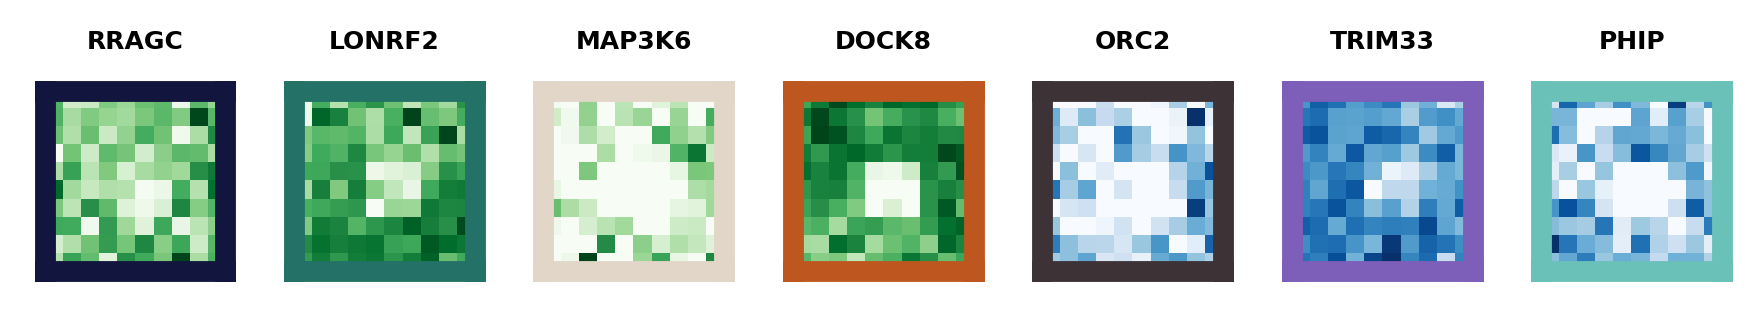

In [ ]:
#@title Random spots of all types
fig, axes = plt.subplots(1,7,dpi=300, tight_layout=True)

frame = 30
vid_frame = green_vid[frame]

k = np.random.randint(low=30,high=39)
x,y = x_cell1[k,frame],y_cell1[k,frame]
axes[0].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap='Greens_r')
axes[0].axes.xaxis.set_visible(False)
axes[0].axes.yaxis.set_visible(False)
axes[0].set_title('RRAGC', fontsize=6)
for spine in axes[0].spines.values():
    spine.set_edgecolor(c[0])
    spine.set_linewidth(5)

k = np.random.randint(low=40,high=49)
x,y = x_cell1[k,frame],y_cell1[k,frame]
axes[1].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap='Greens_r')
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)
axes[1].set_title('LONRF2', fontsize=6)
for spine in axes[1].spines.values():
    spine.set_edgecolor(c[1])
    spine.set_linewidth(5)

k = np.random.randint(low=50,high=59)
x,y = x_cell1[k,frame],y_cell1[k,frame]
axes[2].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap='Greens_r')
axes[2].axes.xaxis.set_visible(False)
axes[2].axes.yaxis.set_visible(False)
axes[2].set_title('MAP3K6', fontsize=6)
for spine in axes[2].spines.values():
    spine.set_edgecolor(c[2])
    spine.set_linewidth(5)

k = np.random.randint(low=60,high=69)
x,y = x_cell1[k,frame],y_cell1[k,frame]
axes[3].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap='Greens_r')
axes[3].axes.xaxis.set_visible(False)
axes[3].axes.yaxis.set_visible(False)
axes[3].set_title('DOCK8', fontsize=6)
for spine in axes[3].spines.values():
    spine.set_edgecolor(c[3])
    spine.set_linewidth(5)

vid_frame = blue_vid[frame]

k = np.random.randint(low=0,high=9)
x,y = x_cell1[k,frame],y_cell1[k,frame]
axes[4].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap='Blues_r')
axes[4].axes.xaxis.set_visible(False)
axes[4].axes.yaxis.set_visible(False)
axes[4].set_title('ORC2', fontsize=6)
for spine in axes[4].spines.values():
    spine.set_edgecolor(c2[0])
    spine.set_linewidth(5)


k = np.random.randint(low=10,high=19)
x,y = x_cell1[k,frame],y_cell1[k,frame]
axes[5].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap='Blues_r')
axes[5].axes.xaxis.set_visible(False)
axes[5].axes.yaxis.set_visible(False)
axes[5].set_title('TRIM33', fontsize=6)
for spine in axes[5].spines.values():
    spine.set_edgecolor(c2[1])
    spine.set_linewidth(5)

k = np.random.randint(low=20,high=29)
x,y = x_cell1[k,frame],y_cell1[k,frame]
axes[6].imshow(vid_frame[y-5:y+5,x-5:x+5], cmap='Blues_r')
axes[6].axes.xaxis.set_visible(False)
axes[6].axes.yaxis.set_visible(False)
axes[6].set_title('PHIP', fontsize=6)
for spine in axes[6].spines.values():
    spine.set_edgecolor(c2[2])
    spine.set_linewidth(5)

plt.savefig('spots.svg')

In [ ]:
#@title unused code
1/0
#unused code
g_true_nonoise_labels_50 = g_true_labels_50[:2000]
b_true_nonoise_labels_50 = b_true_labels_50[:1500]
g_labels_predicted_50_nonoise = g_labels_predicted_50[:2000]
b_labels_predicted_50_nonoise = b_labels_predicted_50[:1500]
g_confidence_50_nonoise = g_confidence_50[:2000]
b_confidence_50_nonoise = b_confidence_50[:1500]


b = plt.bar([0,1,2,3], [g_50_conf, g_50_iconf, b_50_conf, b_50_iconf], yerr=[g_50_conf_std, g_50_iconf_std, b_50_conf_std, b_50_iconf_std], capsize=3, color = [colors[2], colors[2], colors[1],colors[1]] )
plt.ylim([0.5,1])
plt.xlabel('Accuracy')
plt.ylabel('G')